<a href="https://colab.research.google.com/github/chrisdbuck/BoE-Beacon/blob/main/BEACON_LSE_EP_Assignment3_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style = "background-color:#3cd7d9; color:#12273f; padding:5px; text-align:center;">
<h1>Bank of England (BoE) Employer Project</h1>
<p style= "text-align:center; font-weight:bold; font-size:20px" >Team 7: BEACON</p>
</div>

#### Styles

In [6]:
%%html
<style>
    .markdown {
        background-color: #dfe9e9;
    }
</style>

<style>
    .darkbluefont {
        color: #12273f;
    }
</style>

# Notebook Use Advice

<ul>
    <li>Use Table of Contents to navigate through the notebook.</li>
    <li>This notebook was compiled by multiple members of the BEACON team, thus user defined functions and imported/installed libraries appear in the order of the analysis scope.</li>
    <li>The sentiment model acquisition and implementation code is commented out and replaced with an import of ready .csv for optimisation of processing time:<br>The inference pipeline was adapted to utilise available hardware — executing on GPU (1hr 3mins processing time) when available for significant speed-up, and falling back to CPU otherwise (7hrs 40 mins processing time).<br>This hardware-agnostic implementation allows to scale the sentiment labelling process efficiently across large batches of speech data, ensuring consistency in results while reducing processing bottlenecks.</li>
    <li>The 1st data analysis (DA) process stage - 'Define the Questions' - breaking down the business objective into DA questions - is provided in the 'Beacon_LSE_EP_Assignment1.pdf.</li>
</ul>

# BoE Notes

The [Kaggle data set](https://www.kaggle.com/datasets/davidgauthier/central-bank-speeches/data) used in this project use speeches from senior central bankers of various influential central banks. The corpus runs from 1997 until 2022. Central banks are institutions that define monetary policy. As such, central bank speeches are widely followed and have a major influence on financial markets.

You can also refer to the raw data set and article used [here](https://www.kaggle.com/datasets/magnushansson/central-bank-speeches).

Note that, due to the large number of speeches contained in the data set, you can expect long running times for processing intensive steps such as sentiment analysis when using the full data set (30-60 mins). It is recommended that you reduce the subset of data under review when creating your prototype and then run the full data set through, if required, once the code behaves as expected. You can reduce the data set to, for example, only process data from the United Kingdom (or other countries) or by looking at specific date ranges.

The code is not extensive and you will be expected to use the provided code as a starting point only. You will also need to use your own creativity and logic to identify useful patterns in the data. You can explore sentiment, polarity and entities/keywords, and should use appropriate levels of granularity and aggregation in order to analyse patterns contained in the data.

# Work Station Setup

## Import

In [13]:
# Install the necessary libraries.
!pip install gdown

In [5]:
# Import relevant libraries.
import gdown # activate for local download of .csv from Google Drive
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import datetime
import shutil
import subprocess

In [7]:
# IPython's magic to plot inline
%matplotlib inline

# Optional - Ignore warnings.
import warnings
warnings.filterwarnings('ignore')

# Identify empty cells as NA or NaN for missing values checks.
pd.options.mode.use_inf_as_na = True

## Set up work station for NLP

In [17]:
!pip install fsspec==2024.3.1
!pip install transformers
!pip install torch
!pip install ipywidgets
!pip install snorkel nltk scikit-learn -q
!pip install snorkel -q

In [18]:
!jupyter lab --version

4.3.7


In [19]:
import re
import torch
import torch.nn.functional as F
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
from tqdm.notebook import tqdm
import pandas as pd
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")
from nltk.tokenize import sent_tokenize
from snorkel.labeling import labeling_function, PandasLFApplier, LFAnalysis
from snorkel.labeling.model import LabelModel
import ipywidgets as widgets
widgets.IntSlider() # just checking whether it finally works

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\victo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


IntSlider(value=0)

In [20]:
# print(torch.__version__)
# print(torch.cuda.is_available())   # Should return True
# print(torch.cuda.get_device_name(0))  # Shows the GPU name

## User Defined Functions

In [22]:
def columns_miss_count(df):
    """
    Only for columns with missing values count total number of missing values;
    renders shorter list than 'df.isnull().sum()')
    """
    null_columns_list = df.isnull().sum()[df.columns[df.isnull().any()]]
    if null_columns_list.empty:
        return f"No missing values"
    else:
        return null_columns_list

In [23]:
def df_dup(x):
    """
    Only list those rows that are duplicated or notify that there are none
    """
    dup_rows = x[x.duplicated()]
    if dup_rows.empty:
        return f"No duplicated rows"
    else:
        return f"{len(dup_rows)} duplicate row(s) based on all columns:\n"

In [24]:
def check_date_dtype(df, column_name):
    """
    Check if a column is Pythonic datetime type.
     Parameters:
    df : pd.DataFrame
        The DataFrame containing the column.
    column_name : str
        The name of the column to check.
     Returns:
    str : A message indicating whether the column is datetime type.
    """
    if column_name not in df.columns:
        return f"Column '{column_name}' does not exist in the DataFrame."

    is_datetime = pd.api.types.is_datetime64_any_dtype(df[column_name])
    return f"Column '{column_name}' is Pythonic datetime type: {is_datetime}"

In [25]:
# ________________________________________________________________________
# DELETE as unnecessary if no more numeric metrics are involved
def format_numbers(x):
    """
    Introduce thousands separators and reduce decimals to zero
    (to be applied before .reset_index())
    """
    if isinstance(x, (int, float)):
        return "{:,.0f}".format(x)
    else:
        return x
    return x

In [26]:
def wrap_text(text, width=30):
    """Wrap lengthy lines of text"""
    return "\n".join(textwrap.wrap(text, width=width))

In [13]:
def wrap_text_narrow(text, width=15):
    """Wrap lengthy lines of text"""
    return "\n".join(textwrap.wrap(text, width=width))

# Collect the Data

### df_ini_sp_csv: 'all_speeches.csv'

<div class="darkbluefont">
    <p><b>Import provided speeches .csv</b></p>
</div>

**Google Quotas**

In [ ]:
df_ini_sp_csv = pd.read_csv(all_speeches_local.csv)

In [ ]:
# # Provide the Google Drive file ID
# # https://drive.google.com/file/d/1z2_7CecaCTi7Fl7Zg9kdv-tBaF0NOunJ/view?usp=drive_link
# file_id = '1z2_7CecaCTi7Fl7Zg9kdv-tBaF0NOunJ'

# # Create the direct download link
# download_url = f"https://drive.google.com/uc?id={file_id}"

# # Download the file locally
# output_path = 'all_speeches_local.csv'
# gdown.download(download_url, output_path, quiet=False)

# # Read the downloaded CSV
# df_ini_sp_csv = pd.read_csv(output_path)

Downloading...
From (original): https://drive.google.com/uc?id=1z2_7CecaCTi7Fl7Zg9kdv-tBaF0NOunJ
From (redirected): https://drive.google.com/uc?id=1z2_7CecaCTi7Fl7Zg9kdv-tBaF0NOunJ&confirm=t&uuid=986caf16-2ea6-4dc8-bfdb-fcfa3d5404fe
To: C:\Users\victo\BoE-Beacon\all_speeches_local.csv
100%|███████████████████████████████████████████████████████████████████████████████| 151M/151M [00:09<00:00, 16.4MB/s]


In [ ]:
# Sense-check and dtypes check
print(df_ini_sp_csv.info())
df_ini_sp_csv.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7721 entries, 0 to 7720
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   reference  7721 non-null   object
 1   country    7721 non-null   object
 2   date       7721 non-null   object
 3   title      7721 non-null   object
 4   author     7721 non-null   object
 5   is_gov     7721 non-null   int64 
 6   text       7721 non-null   object
dtypes: int64(1), object(6)
memory usage: 422.4+ KB
None


reference    country        date                               title  \
0  r901128a_BOA  australia  1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia  1991-10-03                                       
2  r920314a_BOA  australia  1992-03-14                                       
3  r920529a_BOA  australia  1992-05-29                                       
4  r920817a_BOA  australia  1992-08-17                                       

   author  is_gov                                               text  
0  fraser       0  They would no doubt argue that to have two obj...  
1  fraser       0  Today I wish to talk about real interest rates...  
2  fraser       0  I welcome this opportunity to talk about prosp...  
3  fraser       0  It is a pleasure to have this opportunity to a...  
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...

In [ ]:
# Consider the following and check whether some cells could have hit
# the Excel limit for further conclusions

![image.png](attachment:3ce803ba-628a-44a6-a22b-2e5480faf835.png)

In [ ]:
# String length per speech
df_ini_sp_csv['len'] = df_ini_sp_csv['text'].str.len()
df_ini_sp_csv.sort_values('len', ascending=False).head()

reference         country        date  \
6035  r200903a_BOE  united kingdom  2020-09-03   
6038  r200909a_BOE  united kingdom  2020-09-09   
6048  r201026a_BOE  united kingdom  2020-10-26   
6087  r210513a_BOE  united kingdom  2021-05-13   
6026  r200701a_BOE  united kingdom  2020-07-01   

                                                  title    author  is_gov  \
6035       Reinventing the wheel (with more automation)    bailey       1   
6038  Paving the way forward: managing climate risk ...   sweeney       0   
6048                      Is home working good for you?   haldane       0   
6087                         Do we need ‘public money’?  cunliffe       0   
6026  Leading the change: climate action in the fina...   breeden       0   

                                                   text     len  
6035  The Covid-19 pandemic is having a severely dis...  239461  
6038  The Covid-19 pandemic is having a severely dis...  239461  
6048  Does good work have a positive effect on produ...  217543  
6087  The Access to Cash Review was commissioned as ...  172730  
6026  Executive summary Insurance industry and clima...  164221

In [ ]:
# Drop 'len' column for now
df_ini_sp_csv = df_ini_sp_csv.drop(columns=['len'])
df_ini_sp_csv.head(1)

reference    country        date                               title  \
0  r901128a_BOA  australia  1990-11-28   A Proper Role for Monetary Policy   

   author  is_gov                                               text  
0  fraser       0  They would no doubt argue that to have two obj...

In [ ]:
# Check descriptive statistics
df_ini_sp_csv.describe(include = ['O'])

reference    country        date    title   author  \
count           7721       7721        7721     7721     7721   
unique          7721          8        4410     6218      325   
top     r901128a_BOA  euro area  2020-02-27  NO_INFO  no_info   
freq               1       2351           8      237      342   

                                                     text  
count                                                7721  
unique                                               7692  
top     Thank you for inviting me to speak today. Whil...  
freq                                                    3

In [ ]:
# Double-ckeck for missing values and duplicates
print(columns_miss_count(df_ini_sp_csv))
print(df_dup(df_ini_sp_csv))

No missing values
No duplicated rows


### df_ws_sp: 'recent speeches_v2.xlsx'

<div class="darkbluefont">
    <p><b>Import web scraped speeches</b></p>
</div>

**Google Quotas**

In [ ]:
# # Provide the Google Drive file ID
# # https://docs.google.com/spreadsheets/d/11pIjrqTPARatBSnuMY3lkQtc12d5RQUX/edit?usp=drive_link&ouid=107888084113442386234&rtpof=true&sd=true
# file_id_ws_sp = '11pIjrqTPARatBSnuMY3lkQtc12d5RQUX'

# # Create the direct export link
# download_url_ws_sp = f"https://docs.google.com/spreadsheets/d/{file_id_ws_sp}/export?format=xlsx"

# # Read the downloaded CSV
# df_ws_sp = pd.read_excel(download_url_ws_sp)

In [ ]:
# Or import dataset from the user's local machine if ran locally
df_ws_sp = pd.read_excel('recent speeches_v2.xlsx') # specify the path

In [ ]:
# Sense-check and dtypes check
print(df_ws_sp.info())
df_ws_sp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    165 non-null    datetime64[ns]
 1   title   165 non-null    object        
 2   author  165 non-null    object        
 3   is_gov  165 non-null    int64         
 4   text    165 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 6.6+ KB
None


date                                              title  \
0 2022-10-27   Growth and competitiveness − speech by Sam Woods   
1 2022-11-02  Building trust in macroprudential policy − spe...   
2 2022-11-04  Thirteen days in October:  how central bank ba...   
3 2022-11-07  Risks from leverage: how did a small corner of...   
4 2022-11-11  Recent UK monetary policy in a changing econom...   

            author  is_gov                                               text  
0        Sam Woods       0  Speech  It’s a great pleasure to be here in th...  
1     Colette Bowe       0  Speech  I am delighted to be here today to spe...  
2    Andrew Hauser       0  Speech Introduction What a difference a month ...  
3    Sarah Breeden       0  Speech  On the afternoon of 28 September, I fo...  
4  Jonathan Haskel       0  Bank of England Page 1 Recent UK monetary poli...

In [ ]:
# Check descriptive statistics
df_ws_sp.describe(include = ['O'])

title         author  \
count                                                165            165   
unique                                               165             47   
top     Growth and competitiveness − speech by Sam Woods  Andrew Bailey   
freq                                                   1             18   

                                                     text  
count                                                 165  
unique                                                165  
top     Speech  It’s a great pleasure to be here in th...  
freq                                                    1

In [ ]:
# Double-ckeck for missing values and duplicates
print(columns_miss_count(df_ws_sp))
print(df_dup(df_ws_sp))

No missing values
No duplicated rows


In [ ]:
# Double check timeframe
df_ws_sp.sort_values('date').head(1)

date                                             title     author  \
0 2022-10-27  Growth and competitiveness − speech by Sam Woods  Sam Woods   

   is_gov                                               text  
0       0  Speech  It’s a great pleasure to be here in th...

In [ ]:
# Double check timeframe
df_ws_sp.sort_values('date').tail(1)

date                                              title  \
164 2025-03-25  Innovating wholesale payments: building a resi...   

               author  is_gov  \
164  Victoria Cleland       0   

                                                  text  
164  Speech  Introduction  Over the last quarter of...

## Findings & Insights

<ul class="markdown">
    <li>The are 7721 speeches' transcripts in the provided 'all_speeches.csv'.</li>
    <li>Speeches are provided by date, it's <b>data type needs to be checked and converted to Pythonic date if necessary</b>.</li>
    <li>They are identified by a 'reference' number/code.</li>
    <li>There are 7 columns in total with no missing values in either of them. That means that <b>empty cells in 'title'</b> need to be explored further.</li>
    <li>The most frequent value in 'title' and 'author' is 'no_info' suggesting no corresponding value was provided.</li>
    <li>There are only 7692 unique values in the text column (instead of 7721) which suggests that there are duplicate speeches in that column even though there are no rows that are entirely duplicated.</li>
    <li>165 recent speeches were web scraped and cover the period: 2022-10-27 - 2025-03-25. Datasets will be joined.</li>
</ul>

# Clean/Explore the Data

<div class="darkbluefont">
    <p><b>What is the dataset timeframe ('all_speeches.csv'): 1900-01-01 - 2022-11-10</b></p>
</div>

In [ ]:
# Check if all values are datetime objects
check_date_dtype(df_ini_sp_csv, 'date')

"Column 'date' is Pythonic datetime type: False"

In [ ]:
# Convert to datetime (non-convertible into NaT)
# Eliminate timestamp
df_ini_sp_csv['date'] = pd.to_datetime(df_ini_sp_csv['date'], errors='coerce')

# Check if all values are datetime objects
check_date_dtype(df_ini_sp_csv, 'date')

"Column 'date' is Pythonic datetime type: True"

In [ ]:
# Check desciptive statistics for all metrics
df_ini_sp_csv.describe(include = 'all')

reference    country                           date    title  \
count           7721       7721                           7721     7721   
unique          7721          8                            NaN     6218   
top     r901128a_BOA  euro area                            NaN  NO_INFO   
freq               1       2351                            NaN      237   
mean             NaN        NaN  2010-10-22 22:25:26.538013184      NaN   
min              NaN        NaN            1900-01-01 00:00:00      NaN   
25%              NaN        NaN            2005-04-02 00:00:00      NaN   
50%              NaN        NaN            2011-02-21 00:00:00      NaN   
75%              NaN        NaN            2016-11-04 00:00:00      NaN   
max              NaN        NaN            2022-11-10 00:00:00      NaN   
std              NaN        NaN                            NaN      NaN   

         author       is_gov  \
count      7721  7721.000000   
unique      325          NaN   
top     no_info          NaN   
freq        342          NaN   
mean        NaN     0.347235   
min         NaN     0.000000   
25%         NaN     0.000000   
50%         NaN     0.000000   
75%         NaN     1.000000   
max         NaN     1.000000   
std         NaN     0.476122   

                                                     text  
count                                                7721  
unique                                               7692  
top     Thank you for inviting me to speak today. Whil...  
freq                                                    3  
mean                                                  NaN  
min                                                   NaN  
25%                                                   NaN  
50%                                                   NaN  
75%                                                   NaN  
max                                                   NaN  
std                                                   NaN

In [ ]:
# Double check timeframe
df_ini_sp_csv.sort_values('date').head(1)

reference country       date                          title  \
4010  r000101a_SRB  sweden 1900-01-01  Swedish economy in transition   

         author  is_gov                                               text  
4010  backstrom       1  Thank you for inviting me to talk with you thi...

In [ ]:
# Double check timeframe
df_ini_sp_csv.sort_values('date').tail(1)

reference      country       date  \
4960  r221110a_SNB  switzerland 2022-11-10   

                                                  title  author  is_gov  \
4960  Current challenges to central banks' independence  jordan       1   

                                                   text  
4960  Ladies and gentlemen I am very grateful for th...

In [ ]:
# Edward George served as Governor of the Bank of England from 1 July 1993 to 30 June 2003.
# Provide the governor's full name
df_ini_sp_csv.loc[
    (df_ini_sp_csv['date'] >= '1993-07-01') &
    (df_ini_sp_csv['date'] <= '2003-06-30') &
    (df_ini_sp_csv['author'].str.lower() == 'george'),
    ['is_gov', 'author']
] = [1, 'Edward George']

# Check adjustments
df_ini_sp_csv[df_ini_sp_csv['author']=='Edward George'].sort_values('date')

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4966  r981119a_BOE  united kingdom 1998-11-19   
4969  r990112a_BOE  united kingdom 1999-01-12   
4970  r990118a_BOE  united kingdom 1999-01-18   
4971  r990201a_BOE  united kingdom 1999-02-01   
4972  r990210a_BOE  united kingdom 1999-02-10   
4973  r990218a_BOE  united kingdom 1999-02-18   
4974  r990224a_BOE  united kingdom 1999-02-24   
4975  r990301a_BOE  united kingdom 1999-03-01   
4977  r990514a_BOE  united kingdom 1999-05-14   
4979  r990518a_BOE  united kingdom 1999-05-18   
4982  r990610a_BOE  united kingdom 1999-06-10   
4994  r991119a_BOE  united kingdom 1999-11-19   
4997  r991207a_BOE  united kingdom 1999-12-07   
5000  r000118a_BOE  united kingdom 2000-01-18   
5001  r000126a_BOE  united kingdom 2000-01-26   
5002  r000214a_BOE  united kingdom 2000-02-14   
5003  r000216a_BOE  united kingdom 2000-02-16   
5005  r000225a_BOE  united kingdom 2000-02-25   
5009  r000328a_BOE  united kingdom 2000-03-28   
5011  r000404a_BOE  united kingdom 2000-04-04   
5018  r000613a_BOE  united kingdom 2000-06-13   
5020  r000615a_BOE  united kingdom 2000-06-15   
5025  r000826a_BOE  united kingdom 2000-08-26   
5026  r000827a_BOE  united kingdom 2000-08-27   
5028  r000928a_BOE  united kingdom 2000-09-28   
5029  r001002a_BOE  united kingdom 2000-10-02   
5032  r001107a_BOE  united kingdom 2000-11-07   
5035  r010115a_BOE  united kingdom 2001-01-15   
5036  r010116a_BOE  united kingdom 2001-01-16   
5047  r010425a_BOE  united kingdom 2001-04-25   
5048  r010507a_BOE  united kingdom 2001-05-07   
5053  r010530a_BOE  united kingdom 2001-05-30   
5056  r010620a_BOE  united kingdom 2001-06-20   
5061  r010913a_BOE  united kingdom 2001-09-13   
5066  r011016a_BOE  united kingdom 2001-10-16   
5073  r011212a_BOE  united kingdom 2001-12-12   
5075  r020114a_BOE  united kingdom 2002-01-14   
5076  r020118a_BOE  united kingdom 2002-01-18   
5077  r020122a_BOE  united kingdom 2002-01-22   
5078  r020204a_BOE  united kingdom 2002-02-04   
5079  r020212a_BOE  united kingdom 2002-02-12   
5080  r020219a_BOE  united kingdom 2002-02-19   
5083  r020319a_BOE  united kingdom 2002-03-19   
5085  r020411a_BOE  united kingdom 2002-04-11   
5092  r020626a_BOE  united kingdom 2002-06-26   
5094  r020920a_BOE  united kingdom 2002-09-20   
5096  r021015a_BOE  united kingdom 2002-10-15   
5097  r021113a_BOE  united kingdom 2002-11-13   
5101  r021206b_BOE  united kingdom 2002-12-06   
5105  r030120a_BOE  united kingdom 2003-01-20   
5109  r030324a_BOE  united kingdom 2003-03-24   
5110  r030327a_BOE  united kingdom 2003-03-27   
5115  r030618a_BOE  united kingdom 2003-06-18   

                                                  title         author  \
4961                                             Speech  Edward George   
4962                                  Britain in Europe  Edward George   
4966                                             Speech  Edward George   
4969                                             Speech  Edward George   
4970                                             Speech  Edward George   
4971                                             Speech  Edward George   
4972                                             Speech  Edward George   
4973                           The Chancellor's Lecture  Edward George   
4974                                             Speech  Edward George   
4975                                             Speech  Edward George   
4977  Leading the way towards sustainable economic g...  Edward George   
4979                               Birmingham City 2000  Edward George   
4982                               Mansion House Speech  Edward George   
4994                            Annual Cornwall Lecture  Edward George   
4997     Before the Millennium: From the City of London  Edward George   
5000                                City Council Dinner  Edward George   
5001  

In [ ]:
# What are the represented countries
df_ini_sp_csv.country.value_counts()

country
euro area         2351
united states     1551
united kingdom    1209
japan              755
canada             620
sweden             600
switzerland        351
australia          284
Name: count, dtype: int64

### speeches_1900_2025_all: 'speeches_1900_2025_all.csv'

<div class="darkbluefont">
    <p><b>Join datasets ('all_speeches.csv' + 'recent speeches_v2.xlsx'). Extended timeframe: 1900-01-01 - 2025-03-25</b></p>
</div>

In [ ]:
# Describe provided and recent speeches' datasets
print(df_ini_sp_csv.info())
print(df_ws_sp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7721 entries, 0 to 7720
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   reference  7721 non-null   object        
 1   country    7721 non-null   object        
 2   date       7721 non-null   datetime64[ns]
 3   title      7721 non-null   object        
 4   author     7721 non-null   object        
 5   is_gov     7721 non-null   int64         
 6   text       7721 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 422.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    165 non-null    datetime64[ns]
 1   title   165 non-null    object        
 2   author  165 non-null    object        
 3   is_gov  165 non-null    int64         
 4   text    165 non-null  

In [ ]:
# Aling the range of columns in the second dataset
df_ws_sp['reference'] = ''
df_ws_sp['country'] = 'united kingdom' # web scraped only UK speeches

# Reorder columns in df2 to match df1
df_ws_sp = df_ws_sp[df_ini_sp_csv.columns]

# Now safely concatenate
speeches_1900_2025_all = pd.concat([df_ini_sp_csv, df_ws_sp], ignore_index=True)

# Result
print(speeches_1900_2025_all.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7886 entries, 0 to 7885
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   reference  7886 non-null   object        
 1   country    7886 non-null   object        
 2   date       7886 non-null   datetime64[ns]
 3   title      7886 non-null   object        
 4   author     7886 non-null   object        
 5   is_gov     7886 non-null   int64         
 6   text       7886 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 431.4+ KB
None


In [ ]:
# Preview dataset
speeches_1900_2025_all.head(1)

reference    country       date                               title  \
0  r901128a_BOA  australia 1990-11-28   A Proper Role for Monetary Policy   

   author  is_gov                                               text  
0  fraser       0  They would no doubt argue that to have two obj...

In [ ]:
# Replace 'euro area' with 'EU'
speeches_1900_2025_all.loc[
    (speeches_1900_2025_all['country'] == 'euro area'),
    'country'
] = 'EU'

In [ ]:
# Replace 'united kingdom' with 'UK'
speeches_1900_2025_all.loc[
    (speeches_1900_2025_all['country'] == 'united kingdom'),
    'country'
] = 'UK'

# Check adjustments
speeches_1900_2025_all.country.value_counts()

country
EU               2351
united states    1551
UK               1374
japan             755
canada            620
sweden            600
switzerland       351
australia         284
Name: count, dtype: int64

In [ ]:
# Since BoE gained operational independence over monetary policy on May 6, 1997
# check terms of the Governors are correct:

def filter_columns_criteria(df, column1, column2, criteria1, criteria2):
    """
    Check governors terms.
    Parameters:
        df: pd.DataFrame - The DataFrame containing the criteria.
        column : str - The 'column' of interest.
        criteria: str - 'Criteria' of interst.
    Returns:
        df: The corresponding subset of the dataframe.
    """
    # Ensure full output display in Jupyter
    pd.set_option('display.max_rows', None)          # show all rows
    pd.set_option('display.max_columns', None)       # show all columns
    pd.set_option('display.width', 150)              # prevent horizontal wrap
    pd.set_option('display.max_colwidth', 60)        # truncate long text (adjust as needed)

    filtered_df = df.loc[
        (df[column1].astype(str).str.strip() == str(criteria1).strip()) &
        (df[column2].astype(str).str.strip().str.lower() == str(criteria2).strip().lower())
    ].sort_values('date')

    return filtered_df

In [ ]:
# check valid dates
print(f"Invalid date entries: {speeches_1900_2025_all['date'].isnull().sum()}")

Invalid date entries: 0


## Completing the data (Governors)
- For the speeches from the original dataset, we only have last names under the 'author' column.
- We will use the available information (BoE governors and their historic terms) to complete the data with first and last name.

According to our [information](https://www.bankofengland.co.uk/about/people/governors), the list of BoE governors for the period of this study where:

#### Bank of England Governors (1998-2025)
- Sir Edward George (July 1993 – June 2003)
- Mervyn King (July 2003 – June 2013)
- Mark Carney (July 2013 – March 2020)
- Andrew Bailey (March 2020 – Present)

We will perform some corrections to the errors spotted on visual inspection of the data


In [ ]:
# define a dictionary with each of the governors' name, last name, and dates (begin/end)
governors = [
    {"last_name": "george", "full_name": "Edward George", "start": "1993-07-01", "end": "2003-06-30"},
    {"last_name": "king", "full_name": "Mervyn King", "start": "2003-07-01", "end": "2013-06-30"},
    {"last_name": "carney", "full_name": "Mark Carney", "start": "2013-07-01", "end": "2020-03-15"},
    {"last_name": "bailey", "full_name": "Andrew Bailey", "start": "2020-03-16", "end": "2025-12-31"},
]

nongovernors = [
    {
        "last_name": "gieve",
        "full_name": "John Gieve",
        "start": "2006-01-16",
        "end": "2009-02-28"
    },
    {
        "last_name": "tucker",
        "full_name": "Paul Tucker",
        "start": "2009-03-01",
        "end": "2013-10-20"
    },
    {
        "last_name": "posen",
        "full_name": "Adam Posen",
        "start": "2009-09-01",
        "end": "2012-08-31"
    },
    {
        "last_name": "haldane",
        "full_name": "Andrew Haldane",
        "start": "2014-06-01",
        "end": "2021-06-30"
    }
]

# convert dates to datetime format
for gov in governors:
    gov['start'] = pd.to_datetime(gov['start'])
    gov['end'] = pd.to_datetime(gov['end'])

#
We can see that Mervyn King is listed as is_gov = 1 during Sir edward George's term (1993-2003)

In [ ]:
# Mervyn King is listed as is_gov = 1 incorrectly
filtered_df = speeches_1900_2025_all[
    speeches_1900_2025_all['author'].str.contains('King', case=False, na=False) &
    (speeches_1900_2025_all['country'] == 'UK')
]

filtered_df.head(3)

reference country       date  \
4963  r981021a_BOE      UK 1998-10-21   
4978  r990517a_BOE      UK 1999-05-17   
4986  r990827a_BOE      UK 1999-08-27   

                                                  title author  is_gov  \
4963  Impact of the recent turbulence in internation...   king       1   
4978                                   MPC Two Years On   king       1   
4986        Challenges for Monetary Policy: New and Old   king       1   

                                                   text  
4963  Few industries have suffered more from volatil...  
4978  Present at the creation Two years ago, when it...  
4986  The turn of the millennium seems an appropriat...

In [ ]:
# Set 'is_gov' based on each governor's terms

def set_is_governor(row):
    # Do not modify if country is not UK
    if row['country'] != 'UK':
        return row['is_gov']

    author_last = row['author'].strip().split()[-1]

    for gov in governors:
        if author_last == gov['last_name'] and gov['start'] <= row['date'] <= gov['end']:
            return 1  # Match found within UK and within governor's term

    return 0  # UK, but not matching any governor within term

# Apply function
speeches_1900_2025_all['is_gov'] = speeches_1900_2025_all.apply(set_is_governor, axis=1)

In [ ]:
# check changes
filtered_df = speeches_1900_2025_all[
    #speeches_1900_2025_all['is_gov'] &
    speeches_1900_2025_all['author'].str.contains('king', case=False, na=False) &
    (speeches_1900_2025_all['country'] == 'UK')
]

filtered_df.head(130)

reference country       date  \
4963  r981021a_BOE      UK 1998-10-21   
4978  r990517a_BOE      UK 1999-05-17   
4986  r990827a_BOE      UK 1999-08-27   
4987  r990909a_BOE      UK 1999-09-09   
4990  r991011a_BOE      UK 1999-10-11   
...            ...     ...        ...   
5502  r121023a_BOE      UK 2012-10-23   
5516  r130122a_BOE      UK 2013-01-22   
5527  r130416a_BOE      UK 2013-04-16   
5529  r130426a_BOE      UK 2013-04-26   
5543  r130619a_BOE      UK 2013-06-19   

                                                  title author  is_gov  \
4963  Impact of the recent turbulence in internation...   king       0   
4978                                   MPC Two Years On   king       0   
4986        Challenges for Monetary Policy: New and Old   king       0   
4987  Reforming the International Financial System: ...   king       0   
4990                  Interest Rates and the UK Economy   king       0   
...                                                 ...    ...     ...   
5502                                             Speech   king       1   
5516                                             Speech   king       1   
5527  Monetary policy: many targets, many instrument...   king       1   
5529                                            Remarks   king       1   
5543                              A Governor looks back   king       1   

                                                   text  
4963  Few industries have suffered more from volatil...  
4978  Present at the creation Two years ago, when it...  
4986  The turn of the millennium seems an appropriat...  
4987  One of the roles which international financial...  
4990  Twelve months or so ago, interest rates were 7...  
...                                                 ...  
5502  All speeches are available online at Of the ma...  
5516  I am delighted to be in Belfast to deliver my ...  
5527  The past five years have been an extraordinary...  
5529  Good morning everyone. I am delighted to welco...  
5543  Chancellor: thank you for those generous words...  

[64 rows x 7 columns]

#
### Adding full names
Now that we fixed the is_gov value, we will add a new column where we will add the full names of the governors:

In [ ]:
# Create a new column 'full_name'
speeches_1900_2025_all['full_name']=speeches_1900_2025_all['author']


In [ ]:
# Function to assign governor full name (preserve existing value if no match)
def assign_governor_name(row):
    if row['country'] != 'UK':
        return row['full_name']

    author_last_name = row['author'].strip().split()[-1]

    for gov in governors:
        if author_last_name == gov['last_name']:
            return gov['full_name']

    return row['full_name']

# Apply the function
speeches_1900_2025_all['full_name'] = speeches_1900_2025_all.apply(assign_governor_name, axis=1)

In [ ]:
# check changes
filtered_df = speeches_1900_2025_all[
    speeches_1900_2025_all['author'].str.contains('George', case=False, na=False) &
    (speeches_1900_2025_all['country'] == 'UK')
]

filtered_df.head(18)

reference country       date  \
4961  r980915a_BOE      UK 1998-09-15   
4962  r981021b_BOE      UK 1998-10-21   
4966  r981119a_BOE      UK 1998-11-19   
4969  r990112a_BOE      UK 1999-01-12   
4970  r990118a_BOE      UK 1999-01-18   
4971  r990201a_BOE      UK 1999-02-01   
4972  r990210a_BOE      UK 1999-02-10   
4973  r990218a_BOE      UK 1999-02-18   
4974  r990224a_BOE      UK 1999-02-24   
4975  r990301a_BOE      UK 1999-03-01   
4977  r990514a_BOE      UK 1999-05-14   
4979  r990518a_BOE      UK 1999-05-18   
4982  r990610a_BOE      UK 1999-06-10   
4994  r991119a_BOE      UK 1999-11-19   
4997  r991207a_BOE      UK 1999-12-07   
5000  r000118a_BOE      UK 2000-01-18   
5001  r000126a_BOE      UK 2000-01-26   
5002  r000214a_BOE      UK 2000-02-14   

                                                  title         author  \
4961                                             Speech  Edward George   
4962                                  Britain in Europe  Edward George   
4966                                             Speech  Edward George   
4969                                             Speech  Edward George   
4970                                             Speech  Edward George   
4971                                             Speech  Edward George   
4972                                             Speech  Edward George   
4973                           The Chancellor's Lecture  Edward George   
4974                                             Speech  Edward George   
4975                                             Speech  Edward George   
4977  Leading the way towards sustainable economic g...  Edward George   
4979                               Birmingham City 2000  Edward George   
4982                               Mansion House Speech  Edward George   
4994                            Annual Cornwall Lecture  Edward George   
4997     Before the Millennium: From the City of London  Edward George   
5000                                City Council Dinner  Edward George   
5001                                         Lunch 2000  Edward George   
5002                        Bankers Club Annual Banquet  Edward George   

      is_gov                                               text      full_name  
4961       0  Thank you, Chairman. I'm actually very pleased...  Edward George  
4962       0  It's a great pleasure to be here in the beauti...  Edward George  
4966       0  Let me put some of the recent newspaper headli...  Edward George  
4969       0  I am only too well aware of the pressure curre...  Edward George  
4970       0  It would be a masterly understatement to descr...  Edward George  
4971       0  I should like to add my personal thanks to you...  Edward George  
4972       0  Thank you, Padraic. I wasn't quite sure what y...  Edward George  
4973       0  As you would expect of a central banker I will...  Edward George  
4974       0  Some months ago, by quoting my initial reactio...  Edward George  
4975       0  I don't need to emphasise to this audience the...  Edward George  
4977       0  Sustainability of monetary and exchange rate p...  Edward George  
4979       0  Thank you, Mr Chairman. I am delighted to have...  Edward George  
4982       0  When we were last here for this splendid occas...  Edward George  
4994       0  I am genuinely delighted to be with you all th...  Edward George  
4997       0  As we approach the end of every year we natura...  Edward George  
5000       0  I read a Business Comment headline, in one of ...  Edward George  
5001       0  It seems only a very short time ago that I las...  Edward George  
5002       0  In my remarks last year I ventured to suggest ...  Edward George

#
Finally, we can substitute the names in 'author' for the ones in 'full_name':

In [ ]:
speeches_1900_2025_all['author'] = speeches_1900_2025_all['full_name']

# drop the full name column:
speeches_1900_2025_all = speeches_1900_2025_all.drop(columns=['full_name'])

# check changes:
speeches_1900_2025_all[speeches_1900_2025_all['country'] == 'UK']

reference country       date  \
4961  r980915a_BOE      UK 1998-09-15   
4962  r981021b_BOE      UK 1998-10-21   
4963  r981021a_BOE      UK 1998-10-21   
4964  r981101a_BOE      UK 1998-11-01   
4965  r981101b_BOE      UK 1998-11-01   
...            ...     ...        ...   
7881                    UK 2025-02-28   
7882                    UK 2025-03-03   
7883                    UK 2025-03-06   
7884                    UK 2025-03-24   
7885                    UK 2025-03-25   

                                                  title            author  \
4961                                             Speech     Edward George   
4962                                  Britain in Europe     Edward George   
4963  Impact of the recent turbulence in internation...       Mervyn King   
4964        Economic policy, with and without forecasts              budd   
4965  Inflation targeting in practice: the UK experi...           vickers   
...                                                 ...               ...   
7881  Surveys, forecasts and scenarios: setting UK m...      Dave Ramsden   
7882  Accountants can influence growth, competitiven...         Afua Kyei   
7883  Holding the anchor in turbulent waters – speec...           L. Mann   
7884  Growth: What does it take in today’s world? - ...     Andrew Bailey   
7885  Innovating wholesale payments: building a resi...  Victoria Cleland   

      is_gov                                               text  
4961       0  Thank you, Chairman. I'm actually very pleased...  
4962       0  It's a great pleasure to be here in the beauti...  
4963       0  Few industries have suffered more from volatil...  
4964       0  My topic this evening is the use of forecasts ...  
4965       0  Six years ago this week, sterling left the exc...  
...      ...                                                ...  
7881       0  Speech  Thank you for the invitation to speak ...  
7882       0  Speech  Good evening everyone, students and al...  
7883       0  Speech  Introduction  It is particularly fitti...  
7884       0  Speech  Thank you for inviting me to speak tod...  
7885       0  Speech  Introduction  Over the last quarter of...  

[1374 rows x 7 columns]

In [ ]:
# Finally, for the latest speeches that had the correct full name 'Andrew Bailey', we set is_gov = 1 again:

# Define Andrew Bailey's term
bailey_start = pd.to_datetime("2020-03-16")
bailey_end = pd.to_datetime("2025-12-31")

# Apply condition for rows with full_name == "Andrew Bailey"
mask = (
    (speeches_1900_2025_all['author'] == "Andrew Bailey") &
    (speeches_1900_2025_all['date'] >= bailey_start) &
    (speeches_1900_2025_all['date'] <= bailey_end)
)

# Set is_gov = 1 for these rows
speeches_1900_2025_all.loc[mask, 'is_gov'] = 1

In [ ]:
# We can do the same for Edward George:

# Define Edward George's term
george_start = pd.to_datetime("1993-07-01")
george_end = pd.to_datetime("2003-06-30")

# Apply condition for rows with full_name == "Edward George"
mask = (
    (speeches_1900_2025_all['author'] == "Edward George") &
    (speeches_1900_2025_all['date'] >= george_start) &
    (speeches_1900_2025_all['date'] <= george_end)
)

# Set is_gov = 1 for these rows
speeches_1900_2025_all.loc[mask, 'is_gov'] = 1

In [ ]:
# check changes
filtered_df = speeches_1900_2025_all[
    speeches_1900_2025_all['is_gov'] &
    (speeches_1900_2025_all['country'] == 'UK')
]

filtered_df.head()

#save to CSV for checking
#filtered_df.to_csv('governors_UK')

reference country       date              title         author  \
4961  r980915a_BOE      UK 1998-09-15             Speech  Edward George   
4962  r981021b_BOE      UK 1998-10-21  Britain in Europe  Edward George   
4966  r981119a_BOE      UK 1998-11-19             Speech  Edward George   
4969  r990112a_BOE      UK 1999-01-12             Speech  Edward George   
4970  r990118a_BOE      UK 1999-01-18             Speech  Edward George   

      is_gov                                               text  
4961       1  Thank you, Chairman. I'm actually very pleased...  
4962       1  It's a great pleasure to be here in the beauti...  
4966       1  Let me put some of the recent newspaper headli...  
4969       1  I am only too well aware of the pressure curre...  
4970       1  It would be a masterly understatement to descr...

In [ ]:
speeches_1900_2025_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7886 entries, 0 to 7885
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   reference  7886 non-null   object        
 1   country    7886 non-null   object        
 2   date       7886 non-null   datetime64[ns]
 3   title      7886 non-null   object        
 4   author     7886 non-null   object        
 5   is_gov     7886 non-null   int64         
 6   text       7886 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 431.4+ KB


In [ ]:
# save final dataset
# speeches_1900_2025_all.to_csv('speeches_corrected_all', index=False,  encoding='utf-8')

In [ ]:
# Edward George
# filter_columns_criteria(speeches_1900_2025_all, 'country', 'author', 'UK', 'Edward George')
# checked-correct

In [ ]:
# Mervyn King
# filter_columns_criteria(speeches_1900_2025_all, 'country', 'author', 'UK', 'Mervyn King')
# checked-correct

In [ ]:
# Mark Carney
# filter_columns_criteria(speeches_1900_2025_all, 'country', 'author', 'UK', 'Mark Carney')
# checked-correct

In [ ]:
# Andrew Bailey
# filter_columns_criteria(speeches_1900_2025_all, 'country', 'author', 'UK', 'Andrew Bailey')
# checked-correct

## speeches_1998_2025_uk: 'speeches_corrected_all_v2.csv'

<div class="darkbluefont">
    <p><b>Subset and prepare dataset for further analysis</b></p>
</div>

**Google Quotas**

In [ ]:
# # Provide the Google Drive file ID
# # https://drive.google.com/file/d/1h7WQKRQdyDSap-QX5wY6C4Zqcsue_TQP/view?usp=drive_link

# file_id = '1h7WQKRQdyDSap-QX5wY6C4Zqcsue_TQP'

# # Create the direct download link
# download_url = f"https://drive.google.com/uc?id={file_id}"

# # Download the file locally
# output_path = 'speeches_corrected_all_v2_local.csv'
# gdown.download(download_url, output_path, quiet=False)

# # Read the downloaded CSV
# df_ini_sp_csv = pd.read_csv(output_path, encoding='ISO-8859-1')

Downloading...
From (original): https://drive.google.com/uc?id=1h7WQKRQdyDSap-QX5wY6C4Zqcsue_TQP
From (redirected): https://drive.google.com/uc?id=1h7WQKRQdyDSap-QX5wY6C4Zqcsue_TQP&confirm=t&uuid=acf5d5c8-df7f-4104-8cd0-0922c8df5301
To: C:\Users\victo\BoE-Beacon\speeches_corrected_all_v2_local.csv
100%|███████████████████████████████████████████████████████████████████████████████| 146M/146M [00:09<00:00, 16.0MB/s]


In [ ]:
# Or import dataset from the user's local machine if ran locally
df_ini_sp_csv = pd.read_csv('speeches_corrected_all_v2_local.csv') # specify the path

In [ ]:
speeches_1998_2025_uk = df_ini_sp_csv[df_ini_sp_csv['country'] == 'UK']
speeches_1998_2025_uk

reference country        date  \
262   r980915a_BOE      UK  15/09/1998   
286   r981021b_BOE      UK  21/10/1998   
287   r981021a_BOE      UK  21/10/1998   
297   r981101a_BOE      UK  01/11/1998   
298   r981101b_BOE      UK  01/11/1998   
...            ...     ...         ...   
7881           NaN      UK  28/02/2025   
7882           NaN      UK  03/03/2025   
7883           NaN      UK  06/03/2025   
7884           NaN      UK  24/03/2025   
7885           NaN      UK  25/03/2025   

                                                  title            author  \
262                                              Speech     Edward George   
286                                   Britain in Europe     Edward George   
287   Impact of the recent turbulence in internation...       Mervyn King   
297         Economic policy, with and without forecasts              budd   
298   Inflation targeting in practice: the UK experi...           vickers   
...                                                 ...               ...   
7881  Surveys, forecasts and scenarios: setting UK m...      Dave Ramsden   
7882  Accountants can influence growth, competitiven...         Afua Kyei   
7883  Holding the anchor in turbulent waters  speec...           L. Mann   
7884  Growth: What does it take in todays world? - ...     Andrew Bailey   
7885  Innovating wholesale payments: building a resi...  Victoria Cleland   

      is_gov                                               text  
262      1.0  Thank you, Chairman. I'm actually very pleased...  
286      1.0  It's a great pleasure to be here in the beauti...  
287      0.0  Few industries have suffered more from volatil...  
297      0.0  My topic this evening is the use of forecasts ...  
298      0.0  Six years ago this week, sterling left the exc...  
...      ...                                                ...  
7881     0.0  Speech  Thank you for the invitation to speak ...  
7882     0.0  Speech  Good evening everyone, students and al...  
7883     0.0  Speech  Introduction  It is particularly fitti...  
7884     1.0  Speech  Thank you for inviting me to speak tod...  
7885     0.0  Speech  Introduction  Over the last quarter of...  

[1374 rows x 7 columns]

## Findings & Insights

<ul class="markdown">
    <li>Dates back to 1900 are identified in 'date' column and may need to be eliminated for time series analysis.</li>
    <li>The timeframe spans from 1900-2022. The dataset will need to be subset for a shorter period to align with relevant historical events.</li>
    <li>8 countries/regions are represented in the dataset. 'euro area' refers to the Euro Zone comprised of countries that adopted the Euro currency.</li>
</ul>

# Analyse the Data

In [ ]:
# create a subset (without speech texts) for easier handling
sp = speeches_1900_2025_all.drop('text', axis=1)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

### Plot: BoE Speeches by governors by year

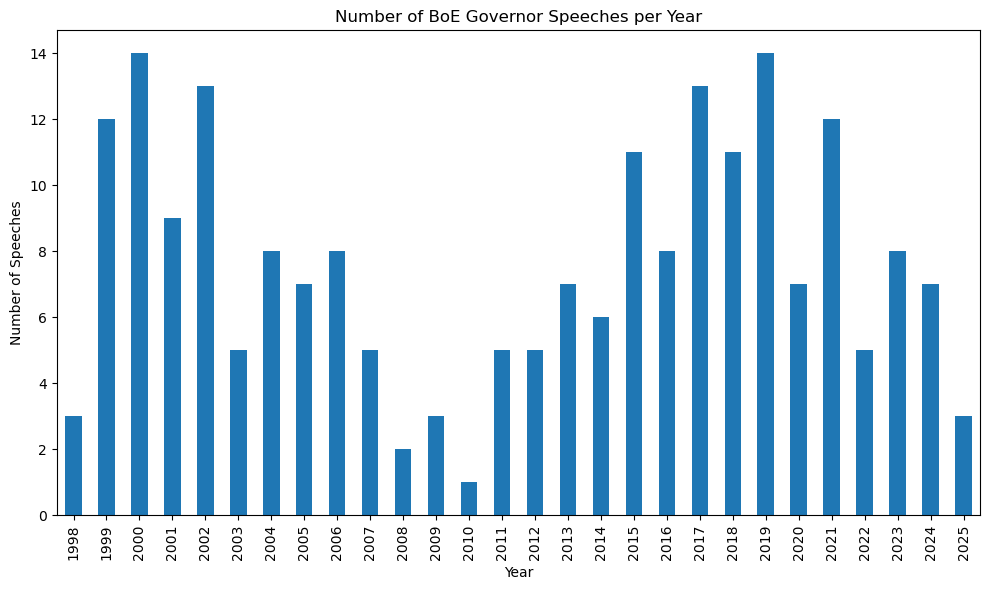

In [ ]:
# Filter for BoE governors only
gov_speeches = sp[(sp['is_gov'] == 1) & (sp['country'] == 'UK')]

# Extract year
gov_speeches['year'] = gov_speeches['date'].dt.year

# Count speeches per year
speech_counts = gov_speeches['year'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
speech_counts.plot(kind='bar')
plt.title('Number of BoE Governor Speeches per Year')
plt.xlabel('Year')
plt.ylabel('Number of Speeches')
plt.tight_layout()
plt.show()


### Plot: Speeches by all institutions vs BoE

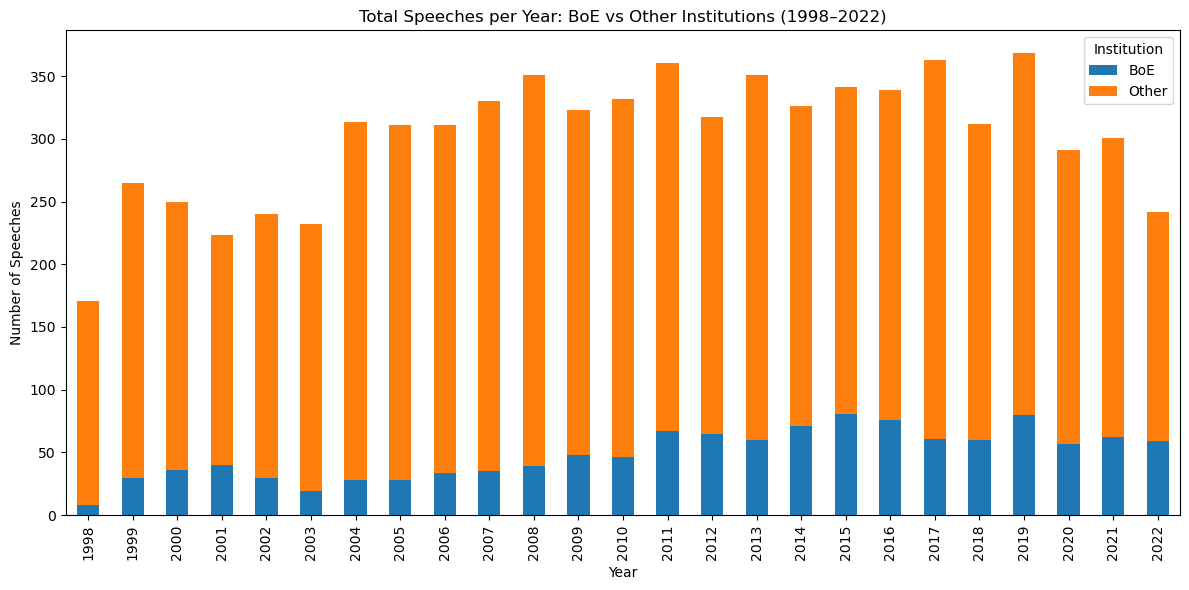

In [ ]:
# Extract year
sp['year'] = sp['date'].dt.year

# Classify origin
sp['origin'] = sp['country'].apply(lambda x: 'BoE' if x == 'UK' else 'Other')

# Filter to desired time range
sp = sp[(sp['year'] >= 1998) & (sp['year'] <= 2022)]

# Group by year and origin, then count
speech_counts = sp.groupby(['year', 'origin']).size().unstack().fillna(0)

# Plot as stacked bars
speech_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Total Speeches per Year: BoE vs Other Institutions (1998–2022)')
plt.xlabel('Year')
plt.ylabel('Number of Speeches')
plt.legend(title='Institution')
plt.tight_layout()
plt.show()

#
### Plot: Quarterly Heatmap

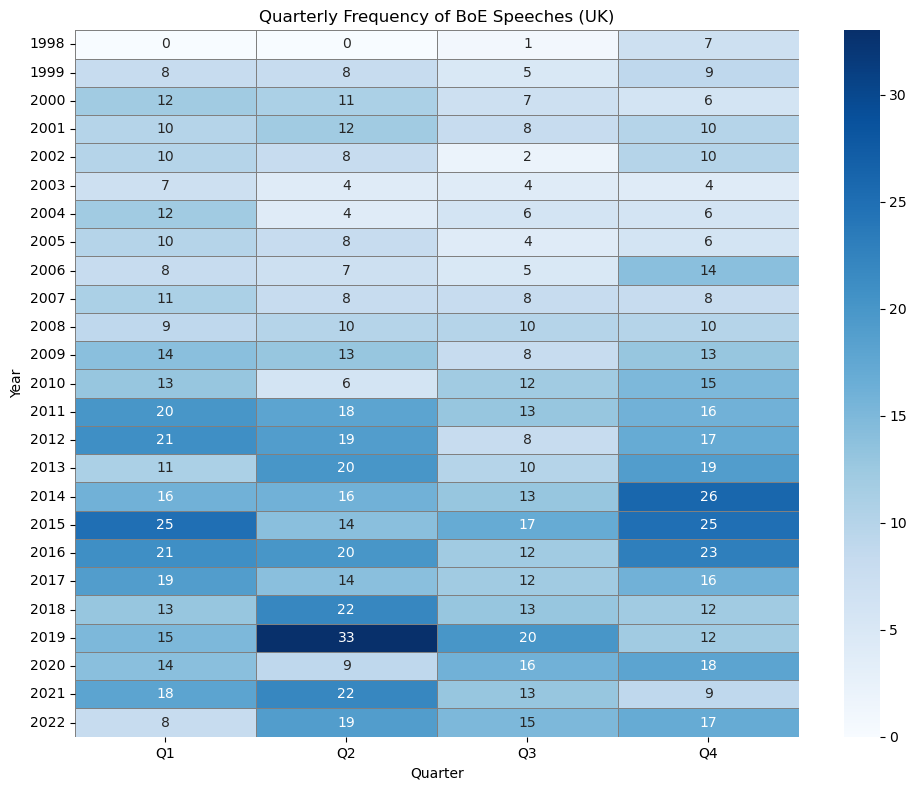

In [ ]:
import seaborn as sns

# Filter UK speeches only
sp = sp[sp['country'] == 'UK']

# Create year and quarter columns
sp['year'] = sp['date'].dt.year
sp['quarter'] = sp['date'].dt.to_period('Q').astype(str)

# Extract quarter number (e.g. Q1, Q2, ...)
sp['q'] = sp['date'].dt.quarter

# Group by year and quarter number
quarterly_counts = sp.groupby(['year', 'q']).size().unstack(fill_value=0)

# Rename columns for clarity
quarterly_counts.columns = ['Q1', 'Q2', 'Q3', 'Q4']

# Sort by year
quarterly_counts = quarterly_counts.sort_index()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(quarterly_counts, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='grey')
plt.title('Quarterly Frequency of BoE Speeches (UK)')
plt.xlabel('Quarter')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

#
### Insights:
- BoE Governors Intensify Communication During Crises: notably the Global Financial Crisis (2008–09) and the COVID-19 pandemic (2020–21)
- Mark Carney and Andrew Bailey periods show consistently high volumes, indicating a proactive communication strategy.
- Quarterly Frequency reveals seasonal communication patterns (high activity in Q1 and Q4) likely linked to monetary policy reports, fiscal cycles, and year-end reviews.
- Outlier quarters (e.g. Q2 2020) correspond to major crises, showing reactive intensification.
#

In [ ]:
# What are the represented countries
speeches_1900_2025_all.country.value_counts()

country
EU               2351
united states    1551
UK               1374
japan             755
canada            620
sweden            600
switzerland       351
australia         284
Name: count, dtype: int64

In [ ]:
speeches_1900_2025_all.head(2)

reference    country       date                               title  \
0  r901128a_BOA  australia 1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia 1991-10-03                                       

   author  is_gov                                               text  
0  fraser       0  They would no doubt argue that to have two obj...  
1  fraser       0  Today I wish to talk about real interest rates...

In [ ]:
# Describe the dataset

print(speeches_1900_2025_all.country.value_counts())
print(speeches_1900_2025_all.info())
speeches_1900_2025_all.describe(include='O')

country
EU               2351
united states    1551
UK               1374
japan             755
canada            620
sweden            600
switzerland       351
australia         284
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7886 entries, 0 to 7885
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   reference  7886 non-null   object        
 1   country    7886 non-null   object        
 2   date       7886 non-null   datetime64[ns]
 3   title      7886 non-null   object        
 4   author     7886 non-null   object        
 5   is_gov     7886 non-null   int64         
 6   text       7886 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 431.4+ KB
None


reference country    title   author  \
count       7886    7886     7886     7886   
unique      7722       8     6383      372   
top                   EU  NO_INFO  no_info   
freq         165    2351      237      342   

                                                     text  
count                                                7886  
unique                                               7857  
top     Thank you for inviting me to speak today. Whil...  
freq                                                    3

### Plot: UK vs EU Speeches & Economic Events (Before 2023)

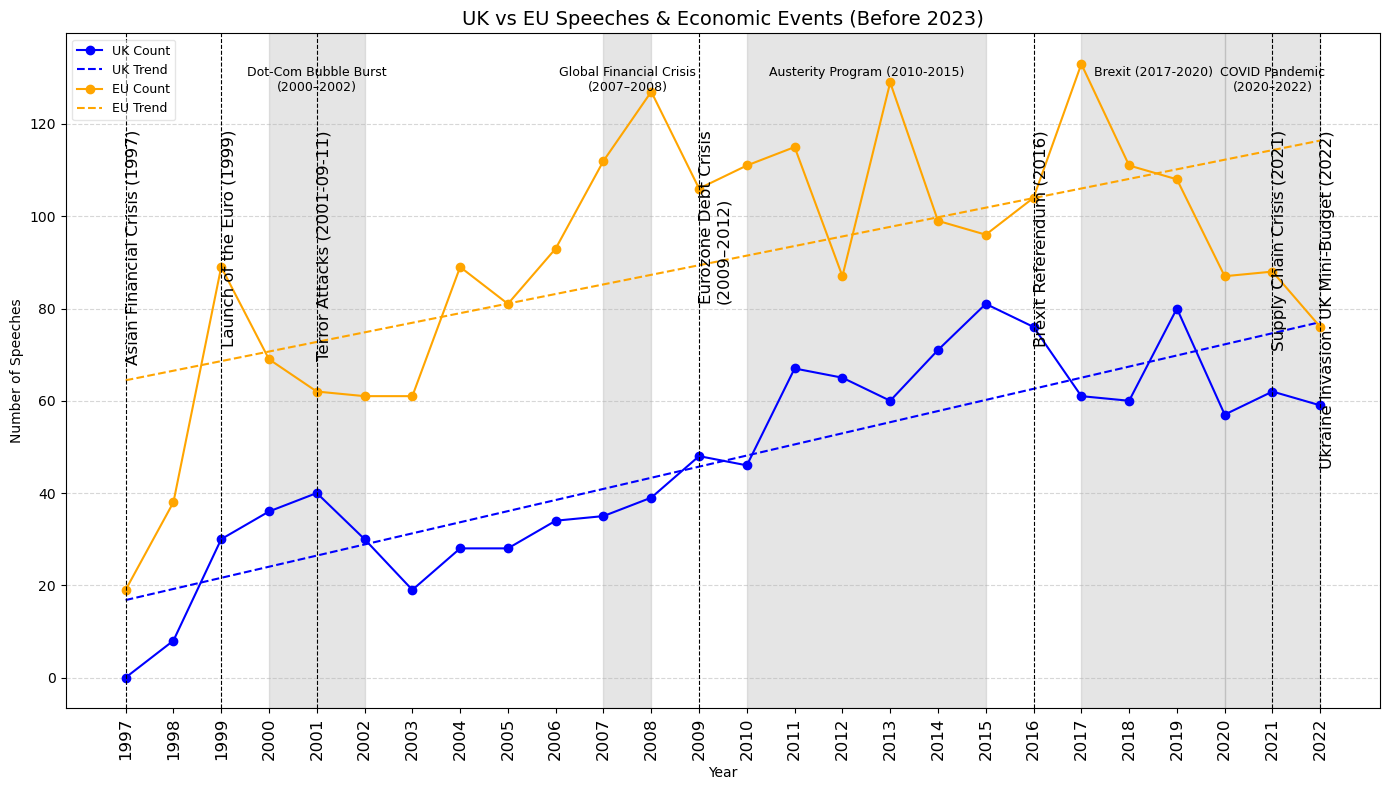

In [ ]:
# Check dtype of date
speeches_1900_2025_all['date'] = pd.to_datetime(speeches_1900_2025_all['date'])

# === Step 1: Filter for UK and EU speeches before 2023 ===
sp_no_text_filtered = speeches_1900_2025_all[
    (speeches_1900_2025_all['country'].isin(['UK', 'EU'])) &
    (speeches_1900_2025_all['date'] < '2023-01-01')
].copy()
sp_no_text_filtered['year'] = sp_no_text_filtered['date'].dt.year

# === Step 2: Count by year and country ===
sp_no_text_filtered_counts = sp_no_text_filtered.groupby(['year', 'country']).size().unstack(fill_value=0)
years = sp_no_text_filtered_counts.index

# === Step 3: Plot counts and trend lines ===
plt.figure(figsize=(14, 8))
colors = {'UK': 'blue', 'EU': 'orange'}

# Plot speech counts and trend lines for UK and EU
for country in ['UK', 'EU']:
    plt.plot(years, sp_no_text_filtered_counts[country], label=f'{country} Count', color=colors[country], marker='o')
    trend = np.poly1d(np.polyfit(years, sp_no_text_filtered_counts[country], 1))(years)
    plt.plot(years, trend, linestyle='--', color=colors[country], label=f'{country} Trend')

# === Step 4: Highlight periods ===
highlight_periods = {
    'Dot-Com Bubble Burst\n(2000–2002)': (2000, 2002),
    'Global Financial Crisis\n(2007–2008)': (2007, 2008),
    'Austerity Program (2010-2015)': (2010, 2015),
    'Brexit (2017-2020)': (2017, 2020),
    'COVID Pandemic\n(2020–2022)': (2020, 2022)
    # ,
    # 'Geopolitical Tensions (2022-2025)': (2022, 2025)
}
for label, (start, end) in highlight_periods.items():
    plt.axvspan(start, end, color='grey', alpha=0.2)
    plt.text((start + end) / 2, plt.ylim()[1]*0.95, label, ha='center', va='top', fontsize=9, wrap=True)

# === Step 5: Vertical event lines ===
event_lines = {
    'Asian Financial Crisis (1997)': 1997,
    'Launch of the Euro (1999)': 1999,
    'Terror Attacks (2001-09-11)': 2001,
    'Eurozone Debt Crisis\n(2009–2012)': 2009,
    'Brexit Referendum (2016)': 2016,
    'Supply Chain Crisis (2021)': 2021,
    'Ukraine Invasion. UK Mini-Budget (2022)': 2022
}
for label, year in event_lines.items():
    plt.axvline(year, color='black', linestyle='--', linewidth=0.8)
    plt.text(year, plt.ylim()[1]*0.85, label, rotation=90, va='top', ha='left', fontsize=12)

# === Step 6: Final formatting ===
plt.title('UK vs EU Speeches & Economic Events (Before 2023)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Number of Speeches')
plt.xticks(ticks=years, labels=years, rotation=90, fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.legend(title=None, loc='best', fancybox=True, framealpha=0.5, fontsize=9)

plt.tight_layout()
# plt.savefig("uk_eu_speeches_trends_events.png", dpi=300, bbox_inches='tight')
plt.show()

### PLOT: UK Speeches & Economic Events

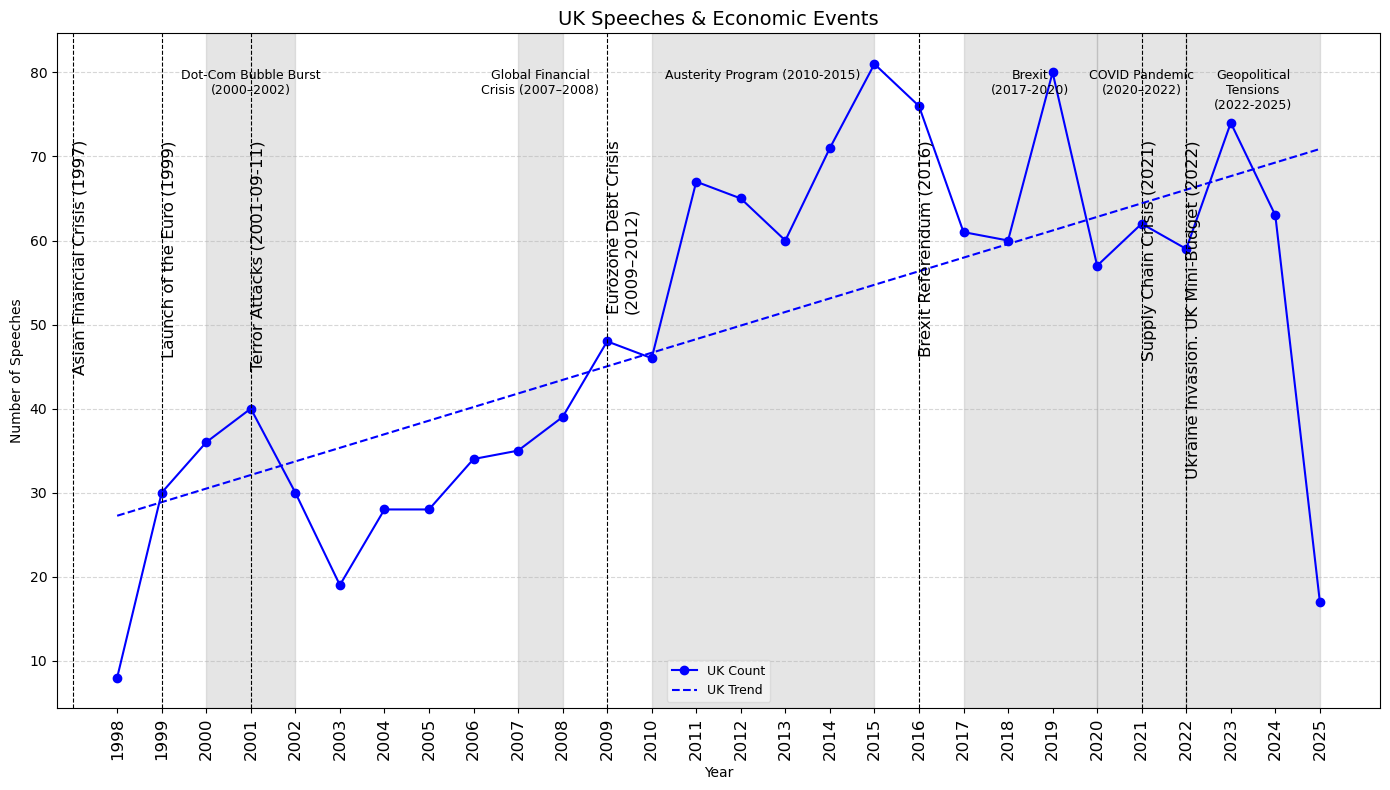

In [ ]:
# Check dtype of date
speeches_1900_2025_all['date'] = pd.to_datetime(speeches_1900_2025_all['date'])

# === Step 1: Filter for UK and EU speeches before 2023 ===
sp_no_text_filtered = speeches_1900_2025_all[
    (speeches_1900_2025_all['country'].isin(['UK'
                                             # , 'EU'
                                            ]))
# &
#     (speeches_1900_2025_all['date'] < '2023-01-01')
].copy()
sp_no_text_filtered['year'] = sp_no_text_filtered['date'].dt.year

# === Step 2: Count by year and country ===
sp_no_text_filtered_counts = sp_no_text_filtered.groupby(['year', 'country']).size().unstack(fill_value=0)
years = sp_no_text_filtered_counts.index

# === Step 3: Plot counts and trend lines ===
plt.figure(figsize=(14, 8))
colors = {'UK': 'blue'
          # , 'EU': 'orange'
         }

# Plot speech counts and trend lines for UK and EU
for country in ['UK'
                # , 'EU'
               ]:
    plt.plot(years, sp_no_text_filtered_counts[country], label=f'{country} Count', color=colors[country], marker='o')
    trend = np.poly1d(np.polyfit(years, sp_no_text_filtered_counts[country], 1))(years)
    plt.plot(years, trend, linestyle='--', color=colors[country], label=f'{country} Trend')

# === Step 4: Highlight periods ===
highlight_periods = {
    'Dot-Com Bubble Burst\n(2000–2002)': (2000, 2002),
    'Global Financial\nCrisis (2007–2008)': (2007, 2008),
    'Austerity Program (2010-2015)': (2010, 2015),
    'Brexit\n(2017-2020)': (2017, 2020),
    'COVID Pandemic\n(2020–2022)': (2020, 2022)
    ,
    'Geopolitical\nTensions\n(2022-2025)': (2022, 2025)
}
for label, (start, end) in highlight_periods.items():
    plt.axvspan(start, end, color='grey', alpha=0.2)
    plt.text((start + end) / 2, plt.ylim()[1]*0.95, label,
             ha='center', va='top', fontsize=9, wrap=True, )

# === Step 5: Vertical event lines ===
event_lines = {
    'Asian Financial Crisis (1997)': 1997,
    'Launch of the Euro (1999)': 1999,
    'Terror Attacks (2001-09-11)': 2001,
    'Eurozone Debt Crisis\n(2009–2012)': 2009,
    'Brexit Referendum (2016)': 2016,
    'Supply Chain Crisis (2021)': 2021,
    'Ukraine Invasion. UK Mini-Budget (2022)': 2022
}
for label, year in event_lines.items():
    plt.axvline(year, color='black', linestyle='--', linewidth=0.8)
    plt.text(year, plt.ylim()[1]*0.85, label, rotation=90, va='top', ha='left', fontsize=12)

# === Step 6: Final formatting ===
plt.title('UK Speeches & Economic Events', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Number of Speeches')
plt.xticks(ticks=years, labels=years, rotation=90, fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.legend(title=None, loc='best', fancybox=True, framealpha=0.5, fontsize=9)

plt.tight_layout()
# plt.savefig("uk_eu_speeches_trends_events.png", dpi=300, bbox_inches='tight')
plt.show()

### Plot: The Most Prolific Speakers

In [ ]:
# Step 1: Filter for UK
uk_speeches = speeches_1900_2025_all[speeches_1900_2025_all['country'] == 'UK'].copy()

# Step 2: Extract year
uk_speeches['year'] = uk_speeches['date'].dt.year

# Step 3: Find most frequent author per year
most_frequent_authors = (
    uk_speeches.groupby(['year', 'author'])
    .size()
    .reset_index(name='count')
    .sort_values(['year', 'count'], ascending=[True, False])
    .drop_duplicates(subset='year', keep='first')
    .sort_values('year')
    .reset_index(drop=True)
)

# Display the result
print(most_frequent_authors)

    year         author  count
0   1998  Edward George      3
1   1999  Edward George     12
2   2000  Edward George     14
3   2001  Edward George      9
4   2002  Edward George     13
5   2003  Edward George      4
6   2004    Mervyn King      8
7   2005    Mervyn King      7
8   2006    Mervyn King      8
9   2007    Mervyn King      5
10  2008          gieve      8
11  2009         tucker      6
12  2010          posen      7
13  2011         tucker      8
14  2012         tucker      9
15  2013         tucker      7
16  2014        haldane      8
17  2015    Mark Carney     11
18  2016    Mark Carney      8
19  2017    Mark Carney     13
20  2018    Mark Carney     11
21  2019    Mark Carney     14
22  2020        haldane      5
23  2021  Andrew Bailey     12
24  2022  Andrew Bailey      5
25  2023  Andrew Bailey      8
26  2024  Andrew Bailey      7
27  2025  Andrew Bailey      3


In [ ]:
# Create a new column 'full_name'
speeches_1900_2025_all['full_name']=speeches_1900_2025_all['author']

In [ ]:
# Function to assign governor full name (preserve existing value if no match)
def assign_nongovernor_name(row):
    if row['country'] != 'UK':
        return row['full_name']

    author_last_name = row['author'].strip().split()[-1]

    for gov in nongovernors:
        if author_last_name == gov['last_name']:
            return gov['full_name']

    return row['full_name']

# Apply the function
speeches_1900_2025_all['full_name'] = speeches_1900_2025_all.apply(assign_nongovernor_name, axis=1)

In [ ]:
# drop the full name column:
speeches_1900_2025_all['author'] = speeches_1900_2025_all['full_name']
speeches_1900_2025_all = speeches_1900_2025_all.drop(columns=['full_name'])

In [ ]:
speeches_1900_2025_all[speeches_1900_2025_all['country'] == 'UK']

reference country       date  \
4961  r980915a_BOE      UK 1998-09-15   
4962  r981021b_BOE      UK 1998-10-21   
4963  r981021a_BOE      UK 1998-10-21   
4964  r981101a_BOE      UK 1998-11-01   
4965  r981101b_BOE      UK 1998-11-01   
...            ...     ...        ...   
7881                    UK 2025-02-28   
7882                    UK 2025-03-03   
7883                    UK 2025-03-06   
7884                    UK 2025-03-24   
7885                    UK 2025-03-25   

                                                  title            author  \
4961                                             Speech     Edward George   
4962                                  Britain in Europe     Edward George   
4963  Impact of the recent turbulence in internation...       Mervyn King   
4964        Economic policy, with and without forecasts              budd   
4965  Inflation targeting in practice: the UK experi...           vickers   
...                                                 ...               ...   
7881  Surveys, forecasts and scenarios: setting UK m...      Dave Ramsden   
7882  Accountants can influence growth, competitiven...         Afua Kyei   
7883  Holding the anchor in turbulent waters – speec...           L. Mann   
7884  Growth: What does it take in today’s world? - ...     Andrew Bailey   
7885  Innovating wholesale payments: building a resi...  Victoria Cleland   

      is_gov                                               text  
4961       1  Thank you, Chairman. I'm actually very pleased...  
4962       1  It's a great pleasure to be here in the beauti...  
4963       0  Few industries have suffered more from volatil...  
4964       0  My topic this evening is the use of forecasts ...  
4965       0  Six years ago this week, sterling left the exc...  
...      ...                                                ...  
7881       0  Speech  Thank you for the invitation to speak ...  
7882       0  Speech  Good evening everyone, students and al...  
7883       0  Speech  Introduction  It is particularly fitti...  
7884       1  Speech  Thank you for inviting me to speak tod...  
7885       0  Speech  Introduction  Over the last quarter of...  

[1374 rows x 7 columns]

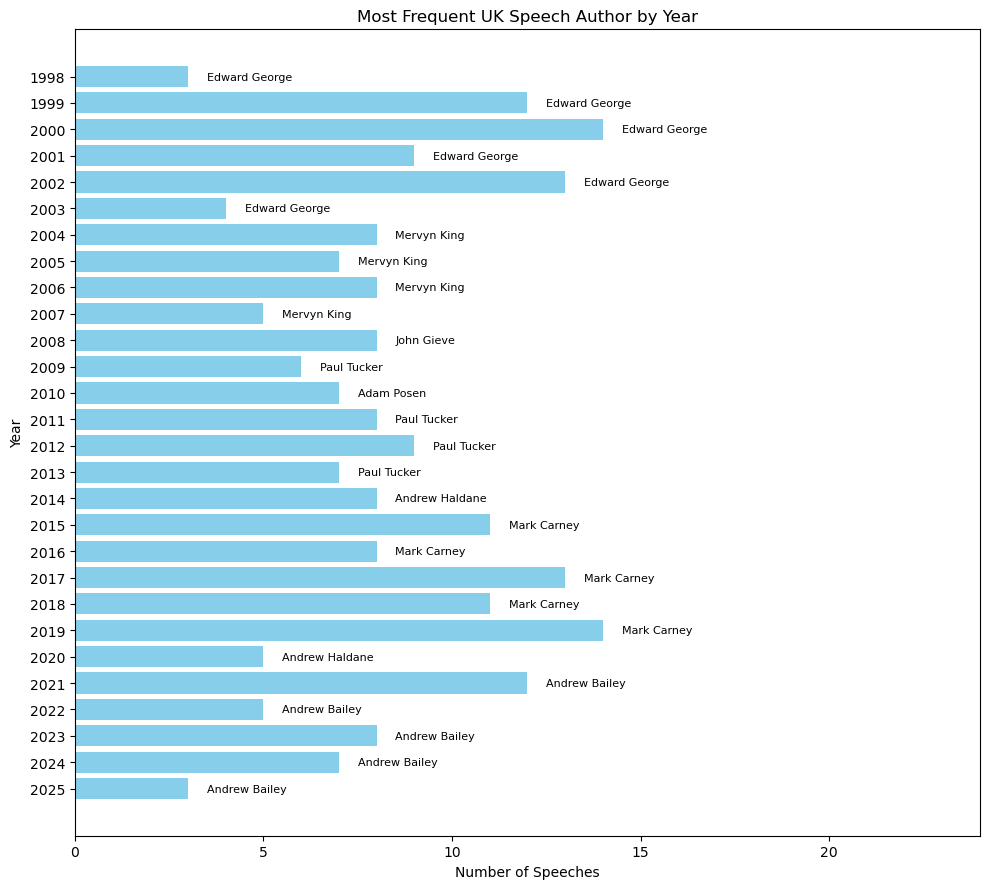

In [ ]:
# Filter UK data and extract year
speeches_1900_2025_all['date'] = pd.to_datetime(speeches_1900_2025_all['date'])
uk_speeches = speeches_1900_2025_all[speeches_1900_2025_all['country'] == 'UK'].copy()
uk_speeches['year'] = uk_speeches['date'].dt.year

# Most frequent author per year
most_frequent_authors = (
    uk_speeches.groupby(['year', 'author'])
    .size()
    .reset_index(name='count')
    .sort_values(['year', 'count'], ascending=[True, False])
    .drop_duplicates(subset='year', keep='first')
    .sort_values('year')
    .reset_index(drop=True)
)

# Plot as horizontal bar chart
plt.figure(figsize=(10, 9))
bars = plt.barh(most_frequent_authors['year'], most_frequent_authors['count'], color='skyblue')

# Annotate bars with author names
for bar, author in zip(bars, most_frequent_authors['author']):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2, author,
             va='center', fontsize=8)

# Show every year on y-axis
plt.yticks(ticks=most_frequent_authors['year'], labels=most_frequent_authors['year'])

# Final formatting
plt.title('Most Frequent UK Speech Author by Year')
plt.xlabel('Number of Speeches')
plt.ylabel('Year')
plt.gca().invert_yaxis()  # Mmost recent year on top
plt.xlim(right=max(most_frequent_authors['count']) + 10)  # Add right padding
plt.tight_layout()
# plt.savefig("uk_most_frequent_author.png", dpi=300, bbox_inches='tight')
plt.show()

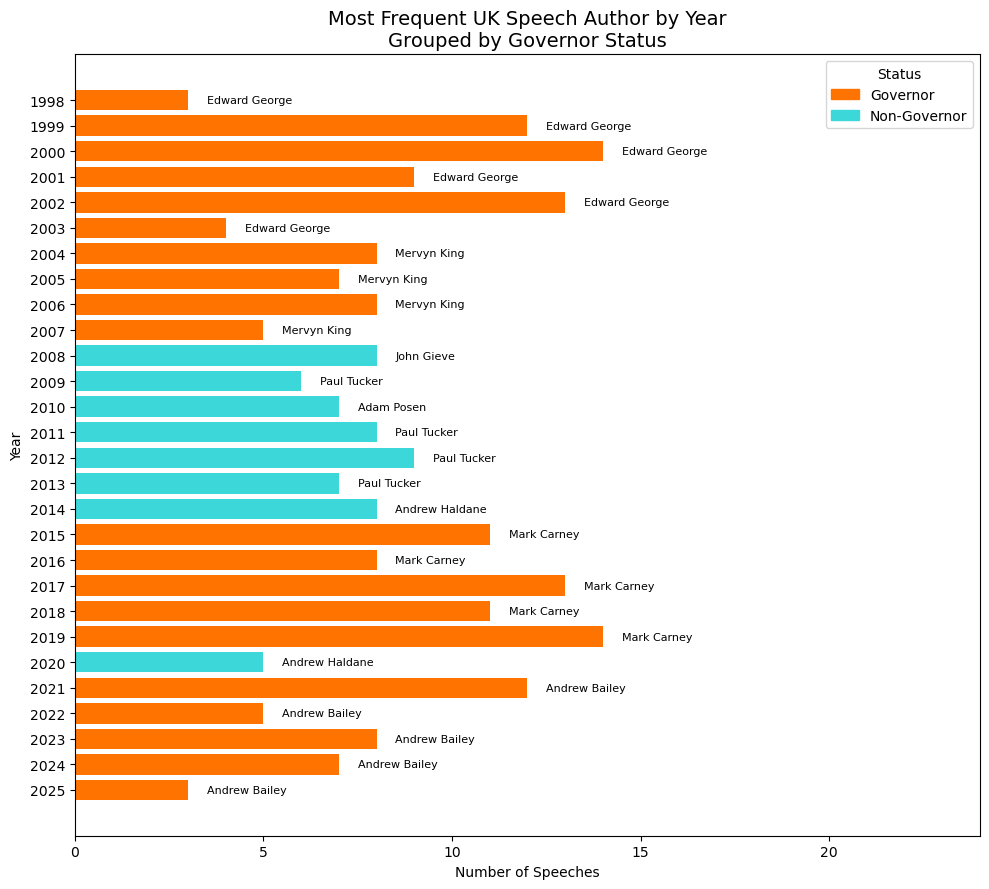

In [ ]:
# Tag each author as governor or non-governor using majority vote from 'is_gov' field
author_status = (
    uk_speeches.groupby('author')['is_gov']
    .mean()
    .apply(lambda x: 'Governor' if x >= 0.5 else 'Non-Governor')
)

# Merge status into most_frequent_authors
most_frequent_authors['status'] = most_frequent_authors['author'].map(author_status)

# Assign colors by status
status_colors = {'Governor': '#FF7300', 'Non-Governor': '#3CD7D9'}
bar_colors = most_frequent_authors['status'].map(status_colors)

# Plot horizontal bar chart grouped by status
plt.figure(figsize=(10, 9))
bars = plt.barh(most_frequent_authors['year'], most_frequent_authors['count'], color=bar_colors)

# Annotate with author names
for bar, author in zip(bars, most_frequent_authors['author']):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
             author, va='center', fontsize=8)

# Formatting
plt.yticks(ticks=most_frequent_authors['year'], labels=most_frequent_authors['year'])
plt.title('Most Frequent UK Speech Author by Year\nGrouped by Governor Status', fontsize=14)
plt.xlabel('Number of Speeches')
plt.ylabel('Year')
plt.gca().invert_yaxis()
plt.xlim(right=max(most_frequent_authors['count']) + 10)
plt.legend(handles=[plt.Rectangle((0,0),1,1,color=c) for c in status_colors.values()],
           labels=status_colors.keys(), title='Status', loc='upper right')
plt.tight_layout()
# plt.savefig("uk_most_frequent_gov_or_non.png", dpi=300, bbox_inches='tight')
plt.show()

## Prepare the data for NLP

In [ ]:
# Check dataset for duplicates and missing values
print(df_dup(speeches_1998_2025_uk))
speeches_1998_2025_uk[['title', 'text']].isna().sum()

No duplicated rows


title    0
text     0
dtype: int64

In [ ]:
df_dup(speeches_1998_2025_uk[['text']])

'7 duplicate row(s) based on all columns:\n'

In [ ]:
# Find duplicated rows
duplicates = speeches_1998_2025_uk[speeches_1998_2025_uk.duplicated(subset=['text'],keep=False)]

# Display duplicated rows
duplicates

reference country        date  \
2413  r061024a_BOE      UK  24/10/2006   
5218  r150226a_BOE      UK  26/02/2015   
6670  r190517a_BOE      UK  17/05/2019   
7068  r200903a_BOE      UK  03/09/2020   
7071  r200909a_BOE      UK  09/09/2020   
7274  r210421a_BOE      UK  21/04/2021   
7279  r210429b_BOE      UK  29/04/2021   
7314  r210601a_BOE      UK  01/06/2021   
7334  r210617a_BOE      UK  17/06/2021   
7422  r211020a_BOE      UK  20/10/2021   
7430  r211103a_BOE      UK  03/11/2021   
7472  r211203a_BOE      UK  03/12/2021   
7570  r220428a_BOE      UK  28/04/2022   
7596  r220526a_BOE      UK  26/05/2022   

                                                  title         author  \
2413                        Globalisation and Inflation           bean   
5218  Goodbye ambiguity, hello clarity: the Bank of ...         shafik   
6670           Citizens in service, not people in power        brazier   
7068       Reinventing the wheel (with more automation)  Andrew Bailey   
7071  Paving the way forward: managing climate risk ...        sweeney   
7274             Opening remarks: meeting varied people          rosen   
7279  Developments in the PRAs supervision of annui...         gerken   
7314  Tackling climate for real: the role of central...  Andrew Bailey   
7334  Central Bank Digital Currency: An update on th...         mutton   
7422  Driving different decisions today: putting cli...        breeden   
7430  Laying the Foundations for a Net Zero Financia...  Andrew Bailey   
7472      The outlook for inflation and monetary policy       saunders   
7570                                           Macropru        breeden   
7596  Four Rs: Creating the conditions for long-term...         gerken   

      is_gov                                               text  
2413     0.0  Madonna", given the 90 million hits that her n...  
5218     0.0  Bank of England's relationship with financial ...  
6670     0.0  Dimitri Demekas and Paul Tucker for helpful di...  
7068     1.0  The Covid-19 pandemic is having a severely dis...  
7071     0.0  The Covid-19 pandemic is having a severely dis...  
7274     0.0  Bank of England's relationship with financial ...  
7279     0.0  Asset eligibility Liability eligibility Calcul...  
7314     1.0  We all tend to reach for the payment methods t...  
7334     0.0  We all tend to reach for the payment methods t...  
7422     0.0  The hurdles to the delivery of effective scena...  
7430     1.0  The hurdles to the delivery of effective scena...  
7472     0.0  Madonna", given the 90 million hits that her n...  
7570     0.0  Dimitri Demekas and Paul Tucker for helpful di...  
7596     0.0  Asset eligibility Liability eligibility Calcul...

**Upon manual check on the [BoE-Speeches website](https://www.bankofengland.co.uk/news/speeches), the following 'text' were pulled incorrectly:**
- r200909a_BOE - erroneous; speech took place but text doesn't relate to it
- r200909a_BOE - erroneous; speech took place but text doesn't relate to it
- r210421a_BOE - duplicate; speech took place but text is a duplicate from another author
- r210601a_BOE - erroneous; speech took place but text doesn't relate to it
- r210617a_BOE - erroneous; speech took place but text doesn't relate to it
- r211020a_BOE - erroneous; speech took place but text doesn't relate to it
- r211103a_BOE - erroneous; speech took place but text doesn't relate to it
- r211203a_BOE - duplicate; speech took place but text is a duplicate from another author
- r220428a_BOE - duplicate; speech took place but text is a duplicate from another author
- r220526a_BOE - duplicate; speech took place but text is a duplicate from another author
- Speeches that have taken place but are missing from the dataset were also identified.
- It has been manually checked in Excel that neither of the above 'references' are duplicates, they can be excluded from the dataset for the purpose of the analysis.

In [ ]:
# List of references to exclude
references_to_exclude = ['r200909a_BOE',
                        'r200909a_BOE',
                        'r210421a_BOE',
                        'r210601a_BOE',
                        'r210617a_BOE',
                        'r211020a_BOE',
                        'r211103a_BOE',
                        'r211203a_BOE',
                        'r220428a_BOE',
                        'r220526a_BOE',
                        ]

# Subset for UK and exclude unwanted references
uk_speeches_cleaned = speeches_1998_2025_uk[
    (~speeches_1998_2025_uk['reference'].isin(references_to_exclude))
]

df_dup(uk_speeches_cleaned[['text']])

'No duplicated rows'

In [ ]:
uk_speeches_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1365 entries, 262 to 7885
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   reference  1200 non-null   object 
 1   country    1365 non-null   object 
 2   date       1365 non-null   object 
 3   title      1365 non-null   object 
 4   author     1365 non-null   object 
 5   is_gov     1365 non-null   float64
 6   text       1365 non-null   object 
dtypes: float64(1), object(6)
memory usage: 85.3+ KB


In [ ]:
# Drop unnecessary columns
uk_speeches_subset = uk_speeches_cleaned.drop(columns=['reference', 'country', 'title'])

In [ ]:
# Save dataset
# uk_speeches_cleaned.to_csv('uk_speeches_cleaned.csv', index=False)

# Findings & Insights

- The 'all_speeches.csv' dataset potentially has more erroneous 'text' and 'is_gov' for the UK and the rest of the regions.
- More erroneous speeches not correcponding to the 'author' / 'date' were identified throughout manual labelling of 'text' for the evaluation of the analysis accuracy.
- Due to limited time dedicated to the project, analysis proceeds with the dataset as is.

# [CentralBankRoBERTa](https://www.sciencedirect.com/science/article/pii/S2405918823000302#appsec1)

Pfeifer, M. and Marohl, V.P. (2023) "[CentralBankRoBERTa](https://doi.org/10.1016/j.jfds.2023.100114): A Fine-Tuned Large Language Model for Central Bank Communications". Journal of Finance and Data Science

## Import dataset

### uk_speeches_cleaned: 'uk_speeches_cleaned.csv'

**Google Quotas**

In [14]:
# # Import dataset
# # Provide the Google Drive file ID
# # https://drive.google.com/file/d/1aikSt2GFcShr-8YRnlWbkkzTUZmwuyUD/view?usp=drive_link
# file_id = '1aikSt2GFcShr-8YRnlWbkkzTUZmwuyUD'

# # Create the direct download link
# download_url = f"https://drive.google.com/uc?id={file_id}"

# # Download the file locally
# output_path = 'uk_speeches_cleaned_v2_local.csv'
# gdown.download(download_url, output_path, quiet=False)

# # Read the downloaded CSV
# uk_speeches_cleaned = pd.read_csv(output_path)

Downloading...
From: https://drive.google.com/uc?id=1aikSt2GFcShr-8YRnlWbkkzTUZmwuyUD
To: /content/uk_speeches_cleaned_v2_local.csv
100%|██████████| 30.9M/30.9M [00:00<00:00, 59.2MB/s]


In [15]:
# Or import dataset from the user's local machine if ran locally
uk_speeches_cleaned = pd.read_csv('uk_speeches_cleaned_v2_local.csv') # specify the path

In [16]:
# # Sense-check dataset
# uk_speeches_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   custom_ref  1365 non-null   object 
 1   reference   1200 non-null   object 
 2   country     1365 non-null   object 
 3   date        1365 non-null   object 
 4   title       1365 non-null   object 
 5   author      1365 non-null   object 
 6   is_gov      1365 non-null   float64
 7   text        1365 non-null   object 
dtypes: float64(1), object(7)
memory usage: 85.4+ KB


In [17]:
# # Convert column dtype to int
# uk_speeches_cleaned['is_gov'] = uk_speeches_cleaned['is_gov'].astype(int)

# # Drop unnecessary columns
# uk_speeches_subset = uk_speeches_cleaned.drop(columns=['reference', 'country', 'title'])

# # Review dataset
# print(uk_speeches_subset.info())
# uk_speeches_subset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   custom_ref  1365 non-null   object
 1   date        1365 non-null   object
 2   author      1365 non-null   object
 3   is_gov      1365 non-null   int64 
 4   text        1365 non-null   object
dtypes: int64(1), object(4)
memory usage: 53.4+ KB
None


custom_ref        date         author  is_gov  \
0   UK_1998-09-15_George  1998-09-15  Edward George       1   
1   UK_1998-10-21_George  1998-10-21  Edward George       1   
2     UK_1998-10-21_King  1998-10-21    Mervyn King       0   
3     UK_1998-11-01_budd  1998-11-01           budd       0   
4  UK_1998-11-01_vickers  1998-11-01        vickers       0   

                                                text  
0  Thank you, Chairman. I'm actually very pleased...  
1  It's a great pleasure to be here in the beauti...  
2  Few industries have suffered more from volatil...  
3  My topic this evening is the use of forecasts ...  
4  Six years ago this week, sterling left the exc...

## Clean text

In [18]:
# def clean_speech(text):
#     """
#     Clean text for NLP.
#     Parameters:
#         df : pd.DataFrame - The DataFrame containing the column.
#         column_name : str - The name of the column to check.
#     Returns:
#         df : Column of cleaned text.
#     """
#     text = text.strip()
#     text = re.sub(r'http\S+', '', text)                # Remove URLs
#     text = re.sub(r'\s+', ' ', text)                   # Normalize whitespace
#     text = re.sub(r'\[.*?\]', '', text)                # Remove bracketed content (if irrelevant)
#     return text

In [19]:
# # Cleant text in RoBERTa style and save in a new column
# uk_speeches_subset['text_cleaned'] = uk_speeches_subset['text'].apply(clean_speech)

In [20]:
# # Subset the data to reduce processing time.
# # Convert date format
# uk_speeches_subset['date'] = pd.to_datetime(uk_speeches_subset['date'])

# # llm_subset = uk_speeches_subset[
# #     (uk_speeches_subset['date'] >= '2022-02-10') &
# #     (uk_speeches_subset['date'] < '2024-03-01')
# # ].copy()

# # # Check result
# # llm_subset.info()

## LLM

### !-!-! GPU

In [21]:
# # Ensure to use GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Running on:", device)

Running on: cuda


In [22]:
# # Load sentiment model
# sentiment_model = AutoModelForSequenceClassification.from_pretrained(
#     "Moritz-Pfeifer/CentralBankRoBERTa-sentiment-classifier"
# ).to(device)
# sentiment_tokenizer = AutoTokenizer.from_pretrained(
#     "Moritz-Pfeifer/CentralBankRoBERTa-sentiment-classifier"
# )

# # Load agent model
# agent_model = AutoModelForSequenceClassification.from_pretrained(
#     "Moritz-Pfeifer/CentralBankRoBERTa-agent-classifier"
# ).to(device)
# agent_tokenizer = AutoTokenizer.from_pretrained(
#     "Moritz-Pfeifer/CentralBankRoBERTa-agent-classifier"
# )

config.json:   0%|          | 0.00/782 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/928 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [23]:
# def get_agent_and_sentiment(text):
#     """Predicts agent value/label, binary sentiment value and sentiment score"""

#     # Tokenize with truncation and max length
#     agent_inputs = agent_tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
#     sentiment_inputs = sentiment_tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)

#     with torch.no_grad():
#         agent_logits = agent_model(**agent_inputs).logits
#         sentiment_logits = sentiment_model(**sentiment_inputs).logits

#     # Agent label (0–4)
#     agent_idx = torch.argmax(agent_logits, dim=1).item()

#     # Sentiment score and binary sentiment
#     sentiment_probs = F.softmax(sentiment_logits, dim=1)
#     sentiment_score = (sentiment_probs[0][1] - sentiment_probs[0][0]).item()
#     binary_sentiment_score = int(torch.argmax(sentiment_logits, dim=1).item())

#     return agent_idx, sentiment_score, binary_sentiment_score

### !-!-! cpu

In [24]:
# agent_model = AutoModelForSequenceClassification.from_pretrained("Moritz-Pfeifer/CentralBankRoBERTa-agent-classifier")
# agent_tokenizer = AutoTokenizer.from_pretrained("Moritz-Pfeifer/CentralBankRoBERTa-agent-classifier")

# sentiment_model = AutoModelForSequenceClassification.from_pretrained("Moritz-Pfeifer/CentralBankRoBERTa-sentiment-classifier")
# sentiment_tokenizer = AutoTokenizer.from_pretrained("Moritz-Pfeifer/CentralBankRoBERTa-sentiment-classifier")

In [25]:
# def get_agent_and_sentiment(text):
#     """Predict agent value and sentiment score with a function"""
#     # Tokenize with truncation and max length
#     agent_inputs = agent_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
#     sentiment_inputs = sentiment_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)

#     with torch.no_grad():
#         agent_logits = agent_model(**agent_inputs).logits
#         sentiment_logits = sentiment_model(**sentiment_inputs).logits

#     # Agent label (0–4)
#     agent_idx = torch.argmax(agent_logits, dim=1).item()

#     # Sentiment score and binary sentiment
#     sentiment_probs = F.softmax(sentiment_logits, dim=1)
#     sentiment_score = (sentiment_probs[0][1] - sentiment_probs[0][0]).item()
#     binary_sentiment_score = int(torch.argmax(sentiment_logits, dim=1).item())

#     return agent_idx, sentiment_score, binary_sentiment_score

### ---> llm_subset (replace with full dataset: uk_speeches_subset)

In [26]:
# # Append into a list
# results = []

# agent_map = {
#     0: "households",
#     1: "firms",
#     2: "financial_sector",
#     3: "government",
#     4: "central_bank"
# }

# # Wrap in tqdm progress bar
# for idx, row in tqdm(uk_speeches_subset.iterrows(), total=len(uk_speeches_subset), desc="Processing Speeches"):
#     custom_ref = row['custom_ref']
#     date = row['date']
#     author = row['author']
#     is_gov = row['is_gov']
#     for sentence in sent_tokenize(row["text_cleaned"]):
#         cbroberta_agent_idx, cbroberta_score, cbroberta_sentiment = get_agent_and_sentiment(sentence)
#         results.append({
#             "custom_ref": custom_ref,
#             "date": date,
#             "author": author,
#             "is_gov": is_gov,
#             "cbroberta_agent": agent_map[cbroberta_agent_idx],
#             "cbroberta_score": cbroberta_score,
#             "cbroberta_sentiment": cbroberta_sentiment
#         })

Processing Speeches:   0%|          | 0/1365 [00:00<?, ?it/s]

In [27]:
# # Shape into dataframe
# agent_sentiment = pd.DataFrame(results)

# # Convert date to datetime and group
# agent_sentiment["date"] = pd.to_datetime(agent_sentiment["date"])

In [28]:
# # Preview
# agent_sentiment.head()

custom_ref       date         author  is_gov   cbroberta_agent  \
0  UK_1998-09-15_George 1998-09-15  Edward George       1      central_bank   
1  UK_1998-09-15_George 1998-09-15  Edward George       1      central_bank   
2  UK_1998-09-15_George 1998-09-15  Edward George       1  financial_sector   
3  UK_1998-09-15_George 1998-09-15  Edward George       1      central_bank   
4  UK_1998-09-15_George 1998-09-15  Edward George       1        households   

   cbroberta_score  cbroberta_sentiment  
0         0.174173                    1  
1        -0.649367                    0  
2        -0.895780                    0  
3        -0.783469                    0  
4        -0.839155                    0

In [29]:
# Save dataset
# agent_sentiment.to_csv('agent_sentiment.csv', index=False)

### !-!-! GPU

In [30]:
# # Save dataset
# agent_sentiment.to_csv('agent_sentiment.csv', index=False)

# from google.colab import files
# files.download('agent_sentiment.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## CentralBankRoBERTa accuracy

In [ ]:
uk_speeches_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1365 non-null   datetime64[ns]
 1   author        1365 non-null   object        
 2   is_gov        1365 non-null   float64       
 3   text          1365 non-null   object        
 4   text_cleaned  1365 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 53.4+ KB


### ---> llm_subset (replace with full dataset: uk_speeches_subset)

In [ ]:
# Weak-label a sample dataset

# Define label constants
HOUSEHOLDS = 0
FIRMS = 1
FINANCIAL = 2
GOVERNMENT = 3
CENTRAL_BANK = 4
ABSTAIN = -1

# Define labeling functions
@labeling_function()
def lf_households(x):
    return HOUSEHOLDS if re.search(r'\b(consumption|wages?|employment|labou?r|households?)\b', x.text.lower()) else ABSTAIN

@labeling_function()
def lf_firms(x):
    return FIRMS if re.search(r'\b(investment|firms?|business|productivity|output)\b', x.text.lower()) else ABSTAIN

@labeling_function()
def lf_financial(x):
    return FINANCIAL if re.search(r'\b(bank|credit|lending|interest rate|financial market)\b', x.text.lower()) else ABSTAIN

@labeling_function()
def lf_government(x):
    return GOVERNMENT if re.search(r'\b(fiscal|public spending|tax|budget|deficit|government)\b', x.text.lower()) else ABSTAIN

@labeling_function()
def lf_central_bank(x):
    return CENTRAL_BANK if re.search(r'\b(monetary policy|inflation target|mpc|central bank)\b', x.text.lower()) else ABSTAIN

lfs = [lf_households, lf_firms, lf_financial, lf_government, lf_central_bank]

# Real speech data
sentences = []
for _, row in uk_speeches_subset.iterrows():
    custom_ref = row['custom_ref']
    date = row['date']
    author = row['author']
    is_gov = row['is_gov']
    text = row['text']
    for sent in sent_tokenize(row["text_cleaned"]):
        sentences.append({
            "custom_ref": custom_ref,
            "date": date,
            "author": author,
            "is_gov": is_gov,
            "text": sent})

df_snorkel = pd.DataFrame(sentences)

# Apply LFs
applier = PandasLFApplier(lfs)
L_train = applier.apply(df=df_snorkel)

# Train label model
label_model = LabelModel(cardinality=5, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

# Predict labels
df_snorkel["snorkel_label"] = label_model.predict(L=L_train)




# Define sentiment classes
POSITIVE, NEGATIVE = 1, 0

@labeling_function()
def lf_positive_keywords(x):
    return POSITIVE if any(word in x.text.lower() for word in [
        "recovery", "growth", "resilient", "improved", "strong", "positive", "stabilize", "expansion"
    ]) else NEGATIVE

@labeling_function()
def lf_negative_keywords(x):
    return NEGATIVE if any(word in x.text.lower() for word in [
        "recession", "weak", "uncertain", "decline", "contraction", "risk", "crisis", "negative"
    ]) else POSITIVE

@labeling_function()
def lf_dovish_indicators(x):
    return POSITIVE if any(word in x.text.lower() for word in [
        "support", "stimulus", "ease", "accommodative", "dovish"
    ]) else NEGATIVE

@labeling_function()
def lf_hawkish_indicators(x):
    return NEGATIVE if any(word in x.text.lower() for word in [
        "tighten", "raise rates", "restrictive", "hawkish", "overheating"
    ]) else POSITIVE

# Apply to the dataset
lfs_ = [lf_positive_keywords, lf_negative_keywords, lf_dovish_indicators, lf_hawkish_indicators]
applier_ = PandasLFApplier(lfs_)
L_ = applier_.apply(df_snorkel)

label_model_ = LabelModel(cardinality=2, verbose=True)
label_model_.fit(L_, n_epochs=500, log_freq=100)

df_snorkel["snorkel_sentiment"] = label_model_.predict(L_)

# Show results
df_snorkel.head()

100%|███████████████████████████████████████████████████████████████████████| 212057/212057 [00:18<00:00, 11244.18it/s]
INFO:root:Computing O...
INFO:root:Estimating \mu...
100%|████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 580.01epoch/s]
INFO:root:Finished Training
100%|████████████████████████████████████████████████████████████████████████| 212057/212057 [00:44<00:00, 4794.70it/s]
INFO:root:Computing O...
INFO:root:Estimating \mu...
100%|████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 777.96epoch/s]
INFO:root:Finished Training


date         author  is_gov  \
0 1998-09-15  Edward George     1.0   
1 1998-09-15  Edward George     1.0   
2 1998-09-15  Edward George     1.0   
3 1998-09-15  Edward George     1.0   
4 1998-09-15  Edward George     1.0   

                                                text  snorkel_label  \
0                               Thank you, Chairman.             -1   
1  I'm actually very pleased to be here, and to h...              4   
2  Let me start with what is perhaps your biggest...             -1   
3  You think that the Monetary Policy Committee, ...              4   
4  Some of you evidently think that's because we'...             -1   

   snorkel_sentiment  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1

In [ ]:
# Align 2 datasets

# Compare key identifying columns (e.g., date, author)
mismatch_mask = (
    (pd.to_datetime(df_snorkel["date"]) != pd.to_datetime(agent_sentiment["date"])) |
    (df_snorkel["custom_ref"] != agent_sentiment["custom_ref"]) |
    (df_snorkel["author"] != agent_sentiment["author"]) |
    (df_snorkel["is_gov"] != agent_sentiment["is_gov"])
)

# Count mismatches
print("Mismatched rows:", mismatch_mask.sum())

# Show mismatched examples
if mismatch_mask.sum() > 0:
    display(df_snorkel[mismatch_mask].head())
    display(agent_sentiment[mismatch_mask].head())

Mismatched rows: 0


In [ ]:
# Join the 2 datasets
# Sort both DataFrames by the join keys to ensure correct alignment
df1_sorted = agent_sentiment.sort_values(by=['custom_ref', 'date', 'author', 'is_gov']).reset_index(drop=True)
df2_sorted = df_snorkel.sort_values(by=['custom_ref', 'date', 'author', 'is_gov']).reset_index(drop=True)

# Concatenate along columns (axis=1)
df_acc_eval = pd.concat([df1_sorted, df2_sorted.drop(columns=['custom_ref', 'date', 'author', 'is_gov'])], axis=1)

df_acc_eval.head()

date         author  is_gov   cbroberta_agent  cbroberta_score  \
0 1998-09-15  Edward George     1.0      central bank         0.174172   
1 1998-09-15  Edward George     1.0      central bank        -0.649367   
2 1998-09-15  Edward George     1.0  financial sector        -0.895780   
3 1998-09-15  Edward George     1.0      central bank        -0.783468   
4 1998-09-15  Edward George     1.0        households        -0.839155   

   cbroberta_sentiment                                               text  \
0                    1                               Thank you, Chairman.   
1                    0  I'm actually very pleased to be here, and to h...   
2                    0  Let me start with what is perhaps your biggest...   
3                    0  You think that the Monetary Policy Committee, ...   
4                    0  Some of you evidently think that's because we'...   

   snorkel_label  snorkel_sentiment  
0             -1                  1  
1              4                  1  
2             -1                  1  
3              4                  1  
4             -1                  1

In [ ]:
agent_map = {
    "households": 0,
    "firms": 1,
    "financial sector": 2,
    "government": 3,
    "central bank": 4
}

df_acc_eval["cbroberta_agent_label"] = df_acc_eval["cbroberta_agent"].map(agent_map)

In [ ]:
# Only keep rows where Snorkel made a decision
df_acc_eval_filtered = df_acc_eval[df_acc_eval["snorkel_label"] != -1].reset_index(drop=True)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Evaluate Agent Classification
print("AGENT CLASSIFICATION EVALUATION:")
print("Accuracy:", accuracy_score(df_acc_eval_filtered["snorkel_label"], df_acc_eval_filtered["cbroberta_agent_label"]))
print(classification_report(df_acc_eval_filtered["snorkel_label"], df_acc_eval_filtered["cbroberta_agent_label"], target_names=agent_map.keys()))

# Evaluate Sentiment Classification
print("\nSENTIMENT CLASSIFICATION EVALUATION:")
print("Accuracy:", accuracy_score(df_acc_eval_filtered["snorkel_sentiment"], df_acc_eval_filtered["cbroberta_sentiment"]))
print(classification_report(df_acc_eval_filtered["snorkel_sentiment"], df_acc_eval_filtered["cbroberta_sentiment"], target_names=["negative", "positive"]))

AGENT CLASSIFICATION EVALUATION:
Accuracy: 0.6130480945821855
                  precision    recall  f1-score   support

      households       0.63      0.79      0.70      9377
           firms       0.80      0.48      0.60     19182
financial sector       0.62      0.56      0.59     26025
      government       0.69      0.68      0.68      3603
    central bank       0.47      0.80      0.59     11509

        accuracy                           0.61     69696
       macro avg       0.64      0.66      0.63     69696
    weighted avg       0.65      0.61      0.61     69696


SENTIMENT CLASSIFICATION EVALUATION:
Accuracy: 0.4262654958677686
              precision    recall  f1-score   support

    negative       0.30      0.76      0.43     19714
    positive       0.75      0.30      0.43     49982

    accuracy                           0.43     69696
   macro avg       0.53      0.53      0.43     69696
weighted avg       0.63      0.43      0.43     69696



## EDA of LLM

In [ ]:
# # Import dataset
# # Provide the Google Drive file ID
# # https://drive.google.com/file/d/1gMUL1qvXJdT2OAbuvw_oZkd6a2K9VWPs/view?usp=drive_link
# file_id = '1gMUL1qvXJdT2OAbuvw_oZkd6a2K9VWPs'

# # Create the direct download link
# download_url = f"https://drive.google.com/uc?id={file_id}"

# # Download the file locally
# output_path = 'agent_sentiment_local.csv'
# gdown.download(download_url, output_path, quiet=False)

# # Read the downloaded CSV
# agent_sentiment = pd.read_csv(output_path)

In [1464]:
# Import dataset locally
agent_sentiment = pd.read_csv('agent_sentiment.csv')

In [1466]:
# Convert date to datetime
agent_sentiment["date"] = pd.to_datetime(agent_sentiment["date"])

# Preview
print(agent_sentiment.info())
agent_sentiment.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212057 entries, 0 to 212056
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   custom_ref           212057 non-null  object        
 1   date                 212057 non-null  datetime64[ns]
 2   author               212057 non-null  object        
 3   is_gov               212057 non-null  int64         
 4   cbroberta_agent      212057 non-null  object        
 5   cbroberta_score      212057 non-null  float64       
 6   cbroberta_sentiment  212057 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 11.3+ MB
None


date         is_gov  cbroberta_score  \
count                         212057  212057.000000    212057.000000   
mean   2014-06-11 09:54:47.868828160       0.122618        -0.333213   
min              1998-09-15 00:00:00       0.000000        -0.978296   
25%              2009-11-19 00:00:00       0.000000        -0.881074   
50%              2015-03-13 00:00:00       0.000000        -0.558605   
75%              2019-10-15 00:00:00       0.000000         0.122418   
max              2025-03-25 00:00:00       1.000000         0.986337   
std                              NaN       0.327999         0.617249   

       cbroberta_sentiment  
count        212057.000000  
mean              0.285310  
min               0.000000  
25%               0.000000  
50%               0.000000  
75%               1.000000  
max               1.000000  
std               0.451563

### PLOT: BoE Audience (Economy Agents)

In [354]:
agent_sentiment.head()

custom_ref       date         author  is_gov   cbroberta_agent  \
0  UK_1998-09-15_George 1998-09-15  Edward George       1      central_bank   
1  UK_1998-09-15_George 1998-09-15  Edward George       1      central_bank   
2  UK_1998-09-15_George 1998-09-15  Edward George       1  financial_sector   
3  UK_1998-09-15_George 1998-09-15  Edward George       1      central_bank   
4  UK_1998-09-15_George 1998-09-15  Edward George       1        households   

   cbroberta_score  cbroberta_sentiment  
0         0.174173                    1  
1        -0.649367                    0  
2        -0.895780                    0  
3        -0.783469                    0  
4        -0.839155                    0

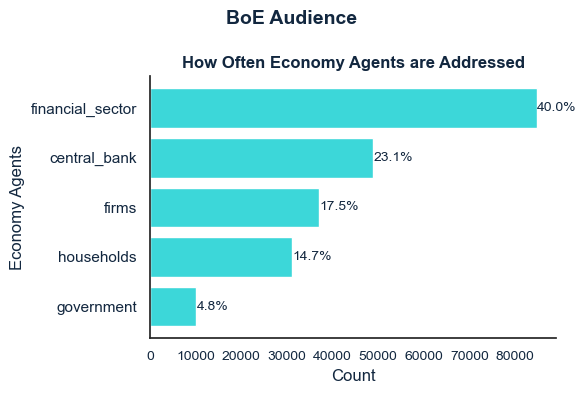

In [1502]:
# Count and sort frequencies of each agent
agent_counts = (
    agent_sentiment['cbroberta_agent']
    .value_counts()
    .loc[["households", "firms", "financial_sector", "government", "central_bank"]]
    .sort_values(ascending=True)  # for horizontal bar: most frequent on top
)

# Calculate percentages
total = agent_counts.sum()
percentages = (agent_counts / total * 100).round(1)

# Plot horizontal bar chart
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.barh(agent_counts.index, agent_counts.values, color='#3CD7D9')

# Annotate percentages next to bars
for bar, pct in zip(bars, percentages):
    ax.text(bar.get_width() + 100, bar.get_y() + bar.get_height() / 2,
            f'{pct}%', va='center', fontsize=10, color='#12273f')

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Formatting
fig.suptitle("BoE Audience", fontsize=14, fontweight='bold', color='#12273f', ha='center')
ax.set_title("How Often Economy Agents are Addressed", 
                color='#12273f', fontweight='bold',
                fontsize=12, loc='center')
ax.set_xlabel('Count', color='#12273f')
ax.set_ylabel('Economy Agents', color='#12273f')
ax.tick_params(axis='x', labelsize=10, colors='#12273f')
ax.tick_params(axis='y', labelsize=11, colors='#12273f')
plt.tight_layout()
plt.savefig("boe_audience_agents_sorted.png", dpi=300, bbox_inches='tight')
plt.show()

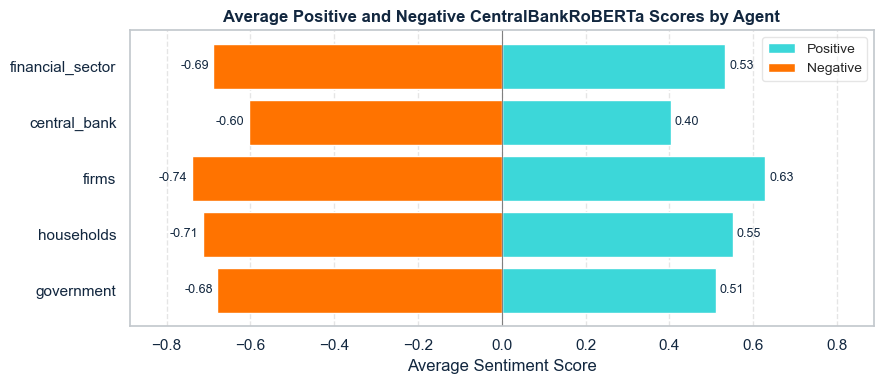

In [1504]:
# Clean agent names
agent_sentiment['cbroberta_agent'] = agent_sentiment['cbroberta_agent'].str.strip().str.lower()

# Keep only top 10 agents by frequency
top_agents = (
    agent_sentiment['cbroberta_agent']
    .value_counts()
    .head(10)
    .index
)
filtered_df = agent_sentiment[agent_sentiment['cbroberta_agent'].isin(top_agents)]

custom_agent_order = [ 'government', 'households', 'firms', 'central_bank', 'financial_sector']
filtered_df = agent_sentiment[agent_sentiment['cbroberta_agent'].isin(custom_agent_order)]

# Group by agent and sentiment polarity
positive_group = (
    filtered_df[filtered_df['cbroberta_score'] > 0]
    .groupby('cbroberta_agent')['cbroberta_score']
    .mean()
    .rename('Positive')
)

negative_group = (
    filtered_df[filtered_df['cbroberta_score'] < 0]
    .groupby('cbroberta_agent')['cbroberta_score']
    .mean()
    .rename('Negative')
)

# Combine into one DataFrame (one row per agent)
avg_scores_by_agent = pd.concat([positive_group, negative_group], axis=1).fillna(0)
avg_scores_by_agent = avg_scores_by_agent.loc[custom_agent_order]  

# Flatten into long format for easier plotting
melted = avg_scores_by_agent.melt(ignore_index=False, var_name='Sentiment', value_name='Average Score')
melted.reset_index(inplace=True)

# Assign colors
color_map = {'Positive': '#3CD7D9', 'Negative': '#FF7300'}
melted['Color'] = melted['Sentiment'].map(color_map)


avg_scores_by_agent = pd.concat([positive_group, negative_group], axis=1).fillna(0)
avg_scores_by_agent = avg_scores_by_agent.loc[custom_agent_order]  # enforce row order

# Apply custom order to bar chart
melted['cbroberta_agent'] = pd.Categorical(
    melted['cbroberta_agent'],
    categories=custom_agent_order,
    ordered=True
)

# Plot
plt.figure(figsize=(9, 4))
for sentiment in ['Positive', 'Negative']:
    subset = melted[melted['Sentiment'] == sentiment]
    bars = plt.barh(subset['cbroberta_agent'], subset['Average Score'], color=subset['Color'], label=sentiment)

    # Annotate each bar with the average value
    for bar in bars:
        width = bar.get_width()
        offset = 0.01 if width >= 0 else -0.01
        plt.text(
            width + offset,
            bar.get_y() + bar.get_height() / 2,
            f"{width:.2f}",
            va='center',
            ha='left' if width >= 0 else 'right',
            fontsize=9, color='#12273f'
        )
        

# Change all spines to custom color
for spine in plt.gca().spines.values():
    spine.set_color('#c4c9ce')

plt.axvline(0, color='grey', linewidth=0.8)
plt.xlabel('Average Sentiment Score', color='#12273f')
plt.title('Average Positive and Negative CentralBankRoBERTa Scores by Agent', fontweight='bold', color='#12273f')
plt.legend(title=None, loc='best', fancybox=True, framealpha=0.5, fontsize=10)
plt.xticks(color='#12273f')
plt.yticks(color='#12273f')
plt.grid(axis='x', linestyle='--', alpha=0.5)
# Compute symmetric x-axis limits with padding
max_val = melted['Average Score'].abs().max()
plt.xlim(-max_val * 1.2, max_val * 1.2)  # 20% padding
plt.tight_layout()
plt.savefig("avg_sentiment_cb.png", dpi=300, bbox_inches='tight')
plt.show()

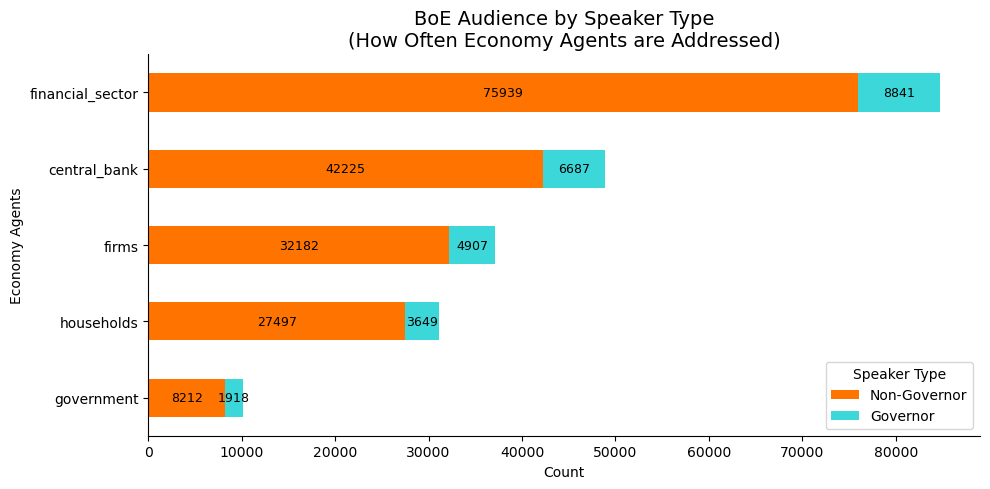

In [358]:
# Define agent categories (in desired output order)
agents = ["households", "firms", "financial_sector", "government", "central_bank"]

# Step 1: Count occurrences by agent and is_gov
agent_counts_split = (
    agent_sentiment[agent_sentiment['cbroberta_agent'].isin(agents)]
    .groupby(['cbroberta_agent', 'is_gov'])
    .size()
    .unstack(fill_value=0)
    .rename(columns={0.0: 'Non-Governor', 1.0: 'Governor'})
)

# Step 2: Sort agents by total frequency (sum of both columns)
agent_counts_split['Total'] = agent_counts_split.sum(axis=1)
agent_counts_split = agent_counts_split.sort_values('Total', ascending=True).drop(columns='Total')

# Step 3: Plot stacked horizontal bar chart
fig, ax = plt.subplots(figsize=(10, 5))
agent_counts_split.plot(kind='barh', stacked=True, ax=ax, color=['#FF7300', '#3CD7D9'])

# Step 4: Annotate segments with values
for i, (index, row) in enumerate(agent_counts_split.iterrows()):
    left = 0
    for value, color in zip(row, ['#FF7300', '#3CD7D9']):
        if value > 0:
            ax.text(left + value / 2, i, str(int(value)), va='center', ha='center', fontsize=9)
            left += value

# Formatting
ax.set_xlabel('Count')
ax.set_ylabel('Economy Agents')
ax.set_title("BoE Audience by Speaker Type\n(How Often Economy Agents are Addressed)", fontsize=14)
ax.legend(title='Speaker Type', loc='lower right')

# Clean up frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
# plt.savefig("boe_audience_agents_stacked_sorted.png", dpi=300, bbox_inches='tight')
plt.show()

### pivot: agent_sentiment_pivot: 'agent_sentiment_pivot.csv'

In [360]:
# # Make a copy of the dataset
# agent_sentiment_pivot = agent_sentiment.copy()

In [362]:
# # Pivot the dataset

# # Step 1: Pivot 'cbroberta_score' by agent category
# pivot_scores = (
#     agent_sentiment_pivot
#     .pivot_table(
#         index=['custom_ref', 'date', 'author', 'is_gov'],
#         columns='cbroberta_agent',
#         values='cbroberta_score',
#         aggfunc='mean'
#     )
#     .reset_index()
# )

# # Step 2: Calculate average 'cbroberta_score' per group
# avg_score = (
#     agent_sentiment_pivot
#     .groupby(['custom_ref', 'date', 'author', 'is_gov'])['cbroberta_score']
#     .mean()
#     .rename('cbroberta_avg_score')
#     .reset_index()
# )

# # Step 3: Calculate binary 'cbroberta_avg_sentiment' per group
# avg_sentiment = (
#     agent_sentiment_pivot
#     .groupby(['custom_ref', 'date', 'author', 'is_gov'])['cbroberta_sentiment']
#     .mean()
#     .apply(lambda x: 1 if x >= 0.5 else 0)
#     .rename('cbroberta_avg_sentiment')
#     .reset_index()
# )

# # Step 4: Merge all parts together
# agent_sentiment_pivot = pivot_scores.merge(avg_score, on=['custom_ref', 'date', 'author', 'is_gov'])
# agent_sentiment_pivot = agent_sentiment_pivot.merge(avg_sentiment, on=['custom_ref', 'date', 'author', 'is_gov'])

# # Step 5: Replace NaNs with zeros
# agent_sentiment_pivot.fillna(0, inplace=True)

In [364]:
# # Sense-check dataset
# print(agent_sentiment_pivot.info())

# # Check number of unique values in a column
# agent_sentiment_pivot['custom_ref'].nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   custom_ref               1365 non-null   object        
 1   date                     1365 non-null   datetime64[ns]
 2   author                   1365 non-null   object        
 3   is_gov                   1365 non-null   int64         
 4   central_bank             1365 non-null   float64       
 5   financial_sector         1365 non-null   float64       
 6   firms                    1365 non-null   float64       
 7   government               1365 non-null   float64       
 8   households               1365 non-null   float64       
 9   cbroberta_avg_score      1365 non-null   float64       
 10  cbroberta_avg_sentiment  1365 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(2), object(2)
memory usage: 117.4+ KB
None


1365

In [366]:
# # Check number of unique values in a column
# uk_speeches_subset['custom_ref'].nunique()

1365

In [203]:
def compare_alignment(df1, df2, keys):
    """
    Compares two DataFrames on key identifying columns and reports mismatches.

    Parameters:
    - df1, df2: DataFrames to compare (must be same length and row order)
    - keys: list of column names to compare, e.g. ['date', 'custom_ref', 'author', 'is_gov']

    Returns:
    - mismatch_mask: Boolean Series of mismatched rows
    """
    if df1.shape[0] != df2.shape[0]:
        raise ValueError("DataFrames must have the same number of rows to align by position.")

    mismatch_mask = pd.Series(False, index=df1.index)

    for key in keys:
        if key == 'date':
            mask = pd.to_datetime(df1[key]) != pd.to_datetime(df2[key])
        else:
            mask = df1[key] != df2[key]
        mismatch_mask |= mask

    num_mismatches = mismatch_mask.sum()
    print(f"Mismatched rows: {num_mismatches}")

    if num_mismatches > 0:
        display(df1[mismatch_mask].head())
        display(df2[mismatch_mask].head())

    return mismatch_mask

In [372]:
# compare_alignment(agent_sentiment_pivot, uk_speeches_subset, ['custom_ref', 'date', 'author', 'is_gov'])

Mismatched rows: 33


custom_ref       date         author  is_gov  central_bank  \
77        UK_2001-02-21_King 2001-02-21    Mervyn King       0     -0.295176   
78    UK_2001-02-21_clementi 2001-02-21       clementi       0     -0.013454   
201       UK_2005-05-17_King 2005-05-17    Mervyn King       1     -0.442877   
202       UK_2005-05-17_bell 2005-05-17           bell       0     -0.385116   
1226    UK_2023-03-27_Bailey 2023-03-27  Andrew Bailey       1     -0.386563   

      financial_sector     firms  government  households  cbroberta_avg_score  \
77           -0.350509 -0.311168   -0.358303   -0.334991            -0.326586   
78           -0.448889 -0.337805   -0.654719    0.111057            -0.412518   
201          -0.377291 -0.056163   -0.268313   -0.265845            -0.377221   
202          -0.353613 -0.028137   -0.409916   -0.222086            -0.359792   
1226         -0.576734 -0.395987   -0.759971   -0.617669            -0.472600   

      cbroberta_avg_sentiment  
77                          0  
78                          0  
201                         0  
202                         0  
1226                        0

custom_ref        date       author  is_gov  \
77    UK_2001-02-21_clementi  2001-02-21     clementi       0   
78        UK_2001-02-21_King  2001-02-21  Mervyn King       0   
201       UK_2005-05-17_bell  2005-05-17         bell       0   
202       UK_2005-05-17_King  2005-05-17  Mervyn King       1   
1226      UK_2023-03-27_Khan  2023-03-27   Shoib Khan       0   

                                                   text  
77    Recent developments in securities markets and ...  
78    No country is an island - in terms of economic...  
201   It is a great pleasure to be here, the third m...  
202   Monetary policy is aimed at maintaining price ...  
1226  Speech  Good morning.  Thank you for the invit...

0       False
1       False
2       False
3       False
4       False
        ...  
1360    False
1361    False
1362    False
1363    False
1364    False
Length: 1365, dtype: bool

In [374]:
# # Join the 2 datasets
# # Sort both DataFrames by the join keys to ensure correct alignment
# agent_sentiment_pivot = agent_sentiment_pivot.sort_values(by=['custom_ref', 'date', 'author', 'is_gov']).reset_index(drop=True)
# uk_speeches_subset = uk_speeches_subset.sort_values(by=['custom_ref', 'date', 'author', 'is_gov']).reset_index(drop=True)

In [376]:
# compare_alignment(agent_sentiment_pivot, uk_speeches_subset, ['custom_ref', 'date', 'author', 'is_gov'])

Mismatched rows: 0


0       False
1       False
2       False
3       False
4       False
        ...  
1360    False
1361    False
1362    False
1363    False
1364    False
Length: 1365, dtype: bool

In [378]:
# # Concatenate along columns (axis=1)
# agent_sentiment_pivot = pd.concat([agent_sentiment_pivot, uk_speeches_subset.drop(columns=[
#     'custom_ref', 
#     'date', 
#     'author', 
#     'is_gov'])], axis=1)

custom_ref       date         author  is_gov  central_bank  \
0   UK_1998-09-15_George 1998-09-15  Edward George       1     -0.409745   
1   UK_1998-10-21_George 1998-10-21  Edward George       1     -0.134019   
2     UK_1998-10-21_King 1998-10-21    Mervyn King       0     -0.516879   
3     UK_1998-11-01_budd 1998-11-01           budd       0     -0.497668   
4  UK_1998-11-01_vickers 1998-11-01        vickers       0     -0.555400   

   financial_sector     firms  government  households  cbroberta_avg_score  \
0         -0.661564 -0.202167   -0.518037   -0.042013            -0.295018   
1          0.047685 -0.305432   -0.251951   -0.535169            -0.128637   
2         -0.644094 -0.581463   -0.580222   -0.672911            -0.601670   
3         -0.373081 -0.598642   -0.567226   -0.360106            -0.476216   
4         -0.629627 -0.683497   -0.339261   -0.289324            -0.569214   

   cbroberta_avg_sentiment                                               text  
0                        0  Thank you, Chairman. I'm actually very pleased...  
1                        0  It's a great pleasure to be here in the beauti...  
2                        0  Few industries have suffered more from volatil...  
3                        0  My topic this evening is the use of forecasts ...  
4                        0  Six years ago this week, sterling left the exc...

In [380]:
# # Preview dataset
# print(agent_sentiment_pivot.info())
# agent_sentiment_pivot.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   custom_ref               1365 non-null   object        
 1   date                     1365 non-null   datetime64[ns]
 2   author                   1365 non-null   object        
 3   is_gov                   1365 non-null   int64         
 4   central_bank             1365 non-null   float64       
 5   financial_sector         1365 non-null   float64       
 6   firms                    1365 non-null   float64       
 7   government               1365 non-null   float64       
 8   households               1365 non-null   float64       
 9   cbroberta_avg_score      1365 non-null   float64       
 10  cbroberta_avg_sentiment  1365 non-null   int64         
 11  text                     1365 non-null   object        
dtypes: datetime64[ns](1), float64(6), 

custom_ref       date         author  is_gov  central_bank  \
0   UK_1998-09-15_George 1998-09-15  Edward George       1     -0.409745   
1   UK_1998-10-21_George 1998-10-21  Edward George       1     -0.134019   
2     UK_1998-10-21_King 1998-10-21    Mervyn King       0     -0.516879   
3     UK_1998-11-01_budd 1998-11-01           budd       0     -0.497668   
4  UK_1998-11-01_vickers 1998-11-01        vickers       0     -0.555400   

   financial_sector     firms  government  households  cbroberta_avg_score  \
0         -0.661564 -0.202167   -0.518037   -0.042013            -0.295018   
1          0.047685 -0.305432   -0.251951   -0.535169            -0.128637   
2         -0.644094 -0.581463   -0.580222   -0.672911            -0.601670   
3         -0.373081 -0.598642   -0.567226   -0.360106            -0.476216   
4         -0.629627 -0.683497   -0.339261   -0.289324            -0.569214   

   cbroberta_avg_sentiment                                               text  
0                        0  Thank you, Chairman. I'm actually very pleased...  
1                        0  It's a great pleasure to be here in the beauti...  
2                        0  Few industries have suffered more from volatil...  
3                        0  My topic this evening is the use of forecasts ...  
4                        0  Six years ago this week, sterling left the exc...

**'Text' alignment check**

In [392]:
# check_date_dtype(uk_speeches_subset, 'date')

"Column 'date' is Pythonic datetime type: False"

In [394]:
# # Change dtype of date
# agent_sentiment_pivot["date"] = pd.to_datetime(agent_sentiment_pivot["date"])
# uk_speeches_subset.head()

custom_ref        date         author  is_gov  \
0   UK_1998-09-15_George  1998-09-15  Edward George       1   
1   UK_1998-10-21_George  1998-10-21  Edward George       1   
2     UK_1998-10-21_King  1998-10-21    Mervyn King       0   
3     UK_1998-11-01_budd  1998-11-01           budd       0   
4  UK_1998-11-01_vickers  1998-11-01        vickers       0   

                                                text  
0  Thank you, Chairman. I'm actually very pleased...  
1  It's a great pleasure to be here in the beauti...  
2  Few industries have suffered more from volatil...  
3  My topic this evening is the use of forecasts ...  
4  Six years ago this week, sterling left the exc...

In [400]:
# # Filter for 2023-03-27
# mask1 = (agent_sentiment_pivot['date'] == '2023-03-27')
# mask2 = (uk_speeches_subset['date'] == '2023-03-27')
# align1_2023_03_27 = agent_sentiment_pivot.loc[mask1].copy()
# align2_2023_03_27 = uk_speeches_subset.loc[mask2].copy()
# align1_2023_03_27

custom_ref       date         author  is_gov  central_bank  \
1226  UK_2023-03-27_Bailey 2023-03-27  Andrew Bailey       1     -0.386563   
1227    UK_2023-03-27_Khan 2023-03-27     Shoib Khan       0     -0.179963   

      financial_sector     firms  government  households  cbroberta_avg_score  \
1226         -0.576734 -0.395987   -0.759971   -0.617669            -0.472600   
1227         -0.454591 -0.210920   -0.937299    0.431972            -0.382861   

      cbroberta_avg_sentiment  \
1226                        0   
1227                        0   

                                                   text  
1226  Speech  It is a great pleasure to be at the Lo...  
1227  Speech  Good morning.  Thank you for the invit...

In [402]:
align2_2023_03_27

custom_ref        date         author  is_gov  \
1226  UK_2023-03-27_Bailey  2023-03-27  Andrew Bailey       1   
1227    UK_2023-03-27_Khan  2023-03-27     Shoib Khan       0   

                                                   text  
1226  Speech  It is a great pleasure to be at the Lo...  
1227  Speech  Good morning.  Thank you for the invit...

### !-!-! cpu

In [404]:
# Save dataset
# agent_sentiment_pivot.to_csv('agent_sentiment_pivot.csv', index=False)

### !-!-! GPU

In [ ]:
# # Save dataset
# agent_sentiment_pivot.to_csv('agent_sentiment_pivot.csv', index=False)

# from google.colab import files
# files.download('agent_sentiment_pivot.csv')

In [407]:
# # Import dataset
# # Provide the Google Drive file ID
# # https://drive.google.com/file/d/169Y9_hsVRjcwfS5bJcN7cGG5hqbzSEJ9/view?usp=drive_link
# file_id = '169Y9_hsVRjcwfS5bJcN7cGG5hqbzSEJ9'

# # Create the direct download link
# download_url = f"https://drive.google.com/uc?id={file_id}"

# # Download the file locally
# output_path = 'agent_sentiment_pivot_local.csv'
# gdown.download(download_url, output_path, quiet=False)

# # Read the downloaded CSV
# agent_sentiment_pivot = pd.read_csv(output_path)

Downloading...
From: https://drive.google.com/uc?id=169Y9_hsVRjcwfS5bJcN7cGG5hqbzSEJ9
To: C:\Users\victo\BoE-Beacon\agent_sentiment_pivot_local.csv
100%|█████████████████████████████████████████████████████████████████████████████| 30.9M/30.9M [00:01<00:00, 15.7MB/s]


In [105]:
# # Or import dataset from the user's local machine if ran locally
agent_sentiment_pivot = pd.read_csv('agent_sentiment_pivot_local.csv') # specify the path

### PLOT: CentralBankRoBERTa Sentiment Over Time

In [ ]:
# Convert date to datetime
agent_sentiment_pivot["date"] = pd.to_datetime(agent_sentiment_pivot["date"])

In [143]:
# agent_sentiment_pivot.info()

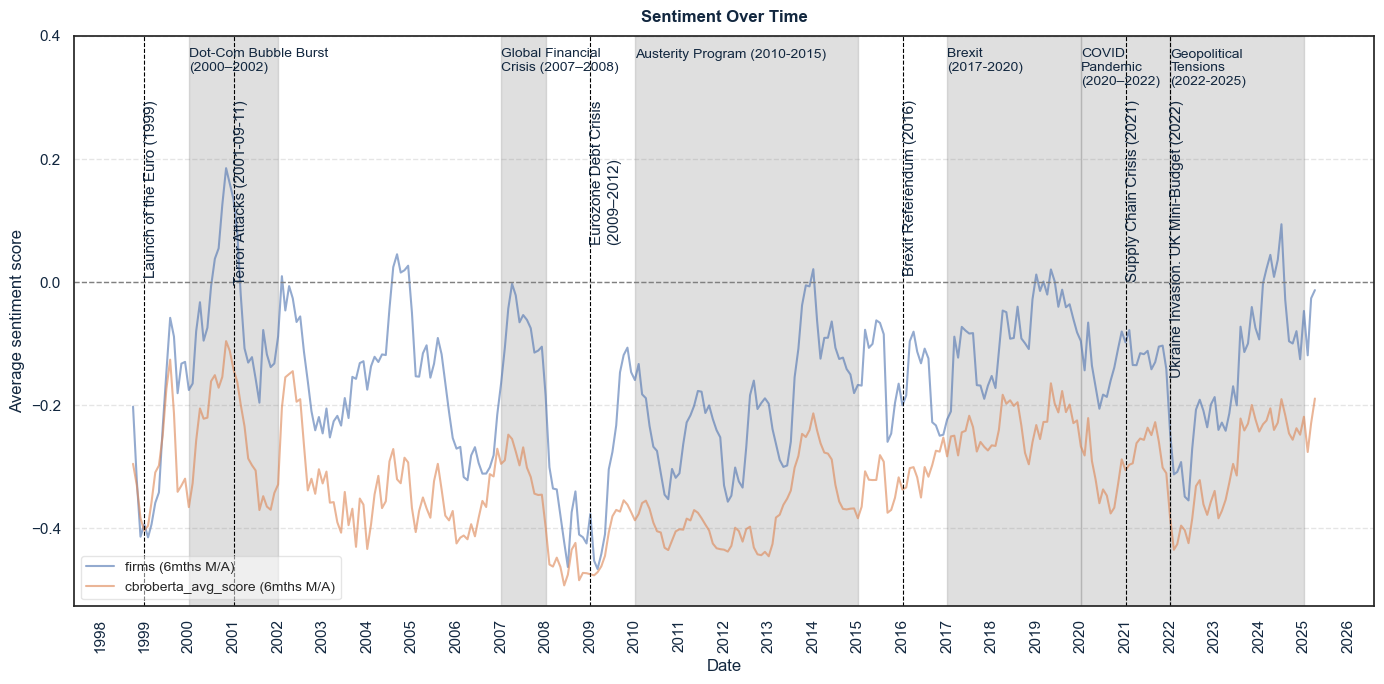

In [1372]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np


# Clean column names
agent_sentiment_pivot.columns = agent_sentiment_pivot.columns.str.strip()

# Set index and select numeric columns
df = agent_sentiment_pivot.set_index('date')
numeric_cols = df.select_dtypes(include='number')

# Resample monthly (month-end) and compute mean
monthly_data = numeric_cols.resample('M').mean().reset_index()

# Compute 6-month moving average
cols_to_plot = [
    # 'financial_sector', 
    'firms', 
    'cbroberta_avg_score'
]
monthly_data_ma = monthly_data.copy()
monthly_data_ma[cols_to_plot] = monthly_data_ma[cols_to_plot].rolling(window=6, min_periods=1).mean()

# Plot
plt.figure(figsize=(14, 7))
for col in cols_to_plot:
    plt.plot(monthly_data_ma['date'], monthly_data_ma[col], 
             label=f"{col} (6mths M/A)", linewidth=1.5, alpha=0.6)

# Define periods to highlight
highlight_periods = {
    'Dot-Com Bubble Burst\n(2000–2002)': (2000, 2002),
    'Global Financial\nCrisis (2007–2008)': (2007, 2008),
    'Austerity Program (2010-2015)': (2010, 2015),
    'Brexit\n(2017-2020)': (2017, 2020),
    'COVID\nPandemic\n(2020–2022)': (2020, 2022),
    'Geopolitical\nTensions\n(2022-2025)': (2022, 2025)
}

# Highlight multiple periods
for label, (start_year, end_year) in highlight_periods.items():
    start = pd.to_datetime(f'{start_year}-01-01')
    end = pd.to_datetime(f'{end_year}-01-01')
    plt.axvspan(start, end, color='gray', alpha=0.25)
    # print(f'start={start}, end={end}, label={label}')
    plt.text(x=start, y=0.38, s=label, fontsize=10, color='#12273f', ha='left', va='top', wrap=False)

# Vertical event lines
event_lines = {
    # 'Asian Financial Crisis (1997)': 1997,
    'Launch of the Euro (1999)': 1999,
    'Terror Attacks (2001-09-11)': 2001,
    'Eurozone Debt Crisis\n(2009–2012)': 2009,
    'Brexit Referendum (2016)': 2016,
    'Supply Chain Crisis (2021)': 2021,
    'Ukraine Invasion. UK Mini-Budget (2022)': 2022
}
for label, year in event_lines.items():
    year = pd.to_datetime(f'{year}-01-01')
    plt.axvline(year, color='black', linestyle='--', linewidth=0.8)
    plt.text(year, plt.ylim()[1]*1.35, label, rotation=90, 
             va='top', ha='left', fontsize=11, color='#12273f')

# Horizontal line at 0
plt.axhline(0, color='grey', linestyle='--', linewidth=1)

# X-axis formatting
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=90)

# Final formatting
plt.ylim(top=0.4)  # pushes plot down by lowering the bottom y-limit
plt.xlabel("Date", color='#12273f')
plt.ylabel("Average sentiment score", color='#12273f')
plt.xticks(color='#12273f')
plt.yticks(color='#12273f')
plt.title("Sentiment Over Time", color='#12273f', fontweight='bold', pad=10)
plt.legend(title=None, loc='lower left', fancybox=True, framealpha=0.5, fontsize=10)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

# Findings & Insights

- CentralBankRoBERTa is designed to label central banks' speeches as positive/negative from the view point of the designated economy agents: Households, Firms, Financial Sector, Government, Central Bank
- Accuracy is extremely subjective due to lack of opportunity of manual labelling (time and resource constraints) as well as need of highly domain-specific knowledge 

# Mega Dataset

In [9]:
# Import relevant libraries.
import gdown # activate for local download of .csv from Google Drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [15]:
# # Import dataset
# # Provide the Google Drive file ID
# # https://drive.google.com/file/d/1M1VYxNCNN-pKihEvZ-qCyQnaeJlprp6b/view?usp=drive_link
# file_id = '1M1VYxNCNN-pKihEvZ-qCyQnaeJlprp6b'

# # Create the direct download link
# download_url = f"https://drive.google.com/uc?id={file_id}"

# # Download the file locally
# output_path = 'uk_speeches_with_finbert_scores_v2_local.csv'
# gdown.download(download_url, output_path, quiet=False)

# # Read the downloaded CSV
# uk_speeches_with_finbert_scores_v2 = pd.read_csv(output_path)

In [16]:
uk_speeches_with_finbert_scores_v2 = pd.read_csv('uk_speeches_with_finbert_scores_v2_local.csv')

In [17]:
# # Import dataset
# # Provide the Google Drive file ID
# # https://drive.google.com/file/d/1W_HjrVi8jqjrRoK3RjPeCz6Y3J8XwacB/view?usp=drive_link
# file_id = '1W_HjrVi8jqjrRoK3RjPeCz6Y3J8XwacB'

# # Create the direct download link
# download_url = f"https://drive.google.com/uc?id={file_id}"

# # Download the file locally
# output_path = 'uk_speeches_with_lm_scores_local.csv'
# gdown.download(download_url, output_path, quiet=False)

# # Read the downloaded CSV
# uk_speeches_with_lm_scores = pd.read_csv(output_path)

In [18]:
uk_speeches_with_lm_scores = pd.read_csv('uk_speeches_with_lm_scores_local.csv')

In [19]:
# # Import dataset
# # Provide the Google Drive file ID
# # https://drive.google.com/file/d/1ZPMhkTkzQKWHOQfisG1814ESEfksNLBf/view?usp=drive_link
# file_id = '1ZPMhkTkzQKWHOQfisG1814ESEfksNLBf'

# # Create the direct download link
# download_url = f"https://drive.google.com/uc?id={file_id}"

# # Download the file locally
# output_path = 'uk_speeches_with_topics_local.csv'
# gdown.download(download_url, output_path, quiet=False)

# # Read the downloaded CSV
# uk_speeches_with_topics = pd.read_csv(output_path)

In [20]:
uk_speeches_with_topics = pd.read_csv('uk_speeches_with_topics_local.csv')

In [21]:
# # Import dataset
# # Provide the Google Drive file ID
# # https://drive.google.com/file/d/1EeKmWlXhXng1HrhQVjc2EHh2H1q_EaMZ/view?usp=drive_link
# file_id = '1EeKmWlXhXng1HrhQVjc2EHh2H1q_EaMZ'

# # Create the direct download link
# download_url = f"https://drive.google.com/uc?id={file_id}"

# # Download the file locally
# output_path = 'daily_indicators_local.csv'
# gdown.download(download_url, output_path, quiet=False)

# # Read the downloaded CSV
# daily_indicators = pd.read_csv(output_path)

In [22]:
daily_indicators = pd.read_csv('daily_indicators_local.csv')

In [23]:
agent_sentiment_pivot = pd.read_csv('agent_sentiment_pivot.csv')

In [24]:
# Compare datasets' dimensions 
print(agent_sentiment_pivot.shape)
print(uk_speeches_with_finbert_scores_v2.shape)
print(uk_speeches_with_lm_scores.shape)
print(uk_speeches_with_topics.shape)
print(daily_indicators.shape)

(1365, 12)
(1365, 13)
(1365, 9)
(1365, 19)
(10225, 12)


In [25]:
# Identify primary key
print("\nagent_sentiment_pivot:\n")
print(agent_sentiment_pivot.info())
print("\nuk_speeches_with_finbert_scores_v2:\n")
print(uk_speeches_with_finbert_scores_v2.info())
print("\nuk_speeches_with_lm_scores:\n")
print(uk_speeches_with_lm_scores.info())
print("\nuk_speeches_with_topics:\n")
print(uk_speeches_with_topics.info())
print("\ndaily_indicators:\n")
print(daily_indicators.info())


agent_sentiment_pivot:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   custom_ref               1365 non-null   object 
 1   date                     1365 non-null   object 
 2   author                   1365 non-null   object 
 3   is_gov                   1365 non-null   int64  
 4   central_bank             1365 non-null   float64
 5   financial_sector         1365 non-null   float64
 6   firms                    1365 non-null   float64
 7   government               1365 non-null   float64
 8   households               1365 non-null   float64
 9   cbroberta_avg_score      1365 non-null   float64
 10  cbroberta_avg_sentiment  1365 non-null   int64  
 11  text                     1365 non-null   object 
dtypes: float64(6), int64(2), object(4)
memory usage: 128.1+ KB
None

uk_speeches_with_finbert_scores_v2:

<clas

In [43]:
# Ensure correct dtype of date
def convert_date_column(df, column='date', errors='raise', dayfirst=False, inplace=True):
    """
    Converts a column in a DataFrame to datetime format.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the column.
        column (str): The name of the column to convert (default: 'date').
        errors (str): 'raise', 'coerce', or 'ignore'. Passed to pd.to_datetime().
        dayfirst (bool): If True, parses dates with day first (e.g., 01/12/2023 as 1 Dec).
        inplace (bool): If True, modifies df in place. Otherwise, returns a copy.

    Returns:
        pd.DataFrame if inplace=False, else None.
    """
    if column not in df.columns:
        raise ValueError(f"'{column}' column not found in DataFrame.")
    
    if inplace:
        df[column] = pd.to_datetime(df[column], errors=errors, dayfirst=dayfirst)
        return None
    else:
        df_copy = df.copy()
        df_copy[column] = pd.to_datetime(df_copy[column], errors=errors, dayfirst=dayfirst)
        return df_copy

In [27]:
convert_date_column(agent_sentiment_pivot)
convert_date_column(uk_speeches_with_finbert_scores_v2)
convert_date_column(uk_speeches_with_lm_scores)
convert_date_column(uk_speeches_with_topics)
convert_date_column(daily_indicators)

In [28]:
# Identify key timeframe
print("agent_sentiment_pivot:")
print(agent_sentiment_pivot['date'].agg(['min', 'max']))
print("uk_speeches_with_finbert_scores_v2:")
print(uk_speeches_with_finbert_scores_v2['date'].agg(['min', 'max']))
print("uk_speeches_with_lm_scores:")
print(uk_speeches_with_lm_scores['date'].agg(['min', 'max']))
print("uk_speeches_with_topics:")
print(uk_speeches_with_topics['date'].agg(['min', 'max']))
print("daily_indicators:")
print(daily_indicators['date'].agg(['min', 'max']))

agent_sentiment_pivot:
min   1998-09-15
max   2025-03-25
Name: date, dtype: datetime64[ns]
uk_speeches_with_finbert_scores_v2:
min   1998-09-15
max   2025-03-25
Name: date, dtype: datetime64[ns]
uk_speeches_with_lm_scores:
min   1998-09-15
max   2025-03-25
Name: date, dtype: datetime64[ns]
uk_speeches_with_topics:
min   1998-09-15
max   2025-03-25
Name: date, dtype: datetime64[ns]
daily_indicators:
min   1986-03-04
max   2025-05-09
Name: date, dtype: datetime64[ns]


In [45]:
# Align/adjust timeframe
def subset_by_date_range(df, date_col='date', start=None, end=None):
    """
    Subsets a DataFrame between start and end dates (inclusive).

    Parameters:
        df (pd.DataFrame): Input DataFrame with a datetime column.
        date_col (str): Name of the datetime column (default: 'date').
        start (str or datetime): Start date (e.g., '2010-01-01').
        end (str or datetime): End date (e.g., '2020-12-31').

    Returns:
        pd.DataFrame: Subset of the input DataFrame.
    """
    if date_col not in df.columns:
        raise ValueError(f"'{date_col}' column not found in DataFrame.")

    if not pd.api.types.is_datetime64_any_dtype(df[date_col]):
        raise TypeError(f"'{date_col}' must be of datetime type.")

    mask = pd.Series(True, index=df.index)
    if start is not None:
        mask &= df[date_col] >= pd.to_datetime(start)
    if end is not None:
        mask &= df[date_col] <= pd.to_datetime(end)

    return df.loc[mask]

In [30]:
# Subset from 2015-01-20 to 2024-12-16

agent_sent_subset = subset_by_date_range(agent_sentiment_pivot, start= '2015-01-20', end= '2024-12-16')
finbert_scores_subset = subset_by_date_range(uk_speeches_with_finbert_scores_v2, start= '2015-01-20', end= '2024-12-16')
lm_scores_subset = subset_by_date_range(uk_speeches_with_lm_scores, start= '2015-01-20', end= '2024-12-16')
topics_subset = subset_by_date_range(uk_speeches_with_topics, start= '2015-01-20', end= '2024-12-16')
indicators_subset = subset_by_date_range(daily_indicators, start= '2015-01-20', end= '2024-12-16')

In [31]:
# Check adjustments
print("agent_sent_subset:")
print(agent_sent_subset['date'].agg(['min', 'max']))
print("finbert_scores_subset:")
print(finbert_scores_subset['date'].agg(['min', 'max']))
print("lm_scores_subset:")
print(lm_scores_subset['date'].agg(['min', 'max']))
print("topics_subset:")
print(topics_subset['date'].agg(['min', 'max']))
print("indicators_subset:")
print(indicators_subset['date'].agg(['min', 'max']))

agent_sent_subset:
min   2015-01-20
max   2024-12-16
Name: date, dtype: datetime64[ns]
finbert_scores_subset:
min   2015-01-20
max   2024-12-16
Name: date, dtype: datetime64[ns]
lm_scores_subset:
min   2015-01-20
max   2024-12-16
Name: date, dtype: datetime64[ns]
topics_subset:
min   2015-01-20
max   2024-12-16
Name: date, dtype: datetime64[ns]
indicators_subset:
min   2015-01-20
max   2024-12-16
Name: date, dtype: datetime64[ns]


In [32]:
# Shared timeframe for indicators
# List of columns to keep
columns_to_keep = ['date', 'ois_1m', 'ois_3m', 'ois_6m']

# Subset 
temp_subset = indicators_subset.loc[:, columns_to_keep]

first_valid_date = temp_subset.loc[temp_subset['ois_1m'].first_valid_index(), 'date']
last_valid_date = temp_subset.loc[temp_subset['ois_1m'].last_valid_index(), 'date']

print("First non-null 'ois_1m' date:", first_valid_date)
print("Last non-null 'ois_1m' date:", last_valid_date)

First non-null 'ois_1m' date: 2016-01-04 00:00:00
Last non-null 'ois_1m' date: 2024-12-16 00:00:00


In [33]:
# Narrower timeframe
agent_sent_subset = subset_by_date_range(agent_sentiment_pivot, start= '2016-01-04', end= '2024-12-16')
finbert_scores_subset = subset_by_date_range(uk_speeches_with_finbert_scores_v2, start= '2016-01-04', end= '2024-12-16')
lm_scores_subset = subset_by_date_range(uk_speeches_with_lm_scores, start= '2016-01-04', end= '2024-12-16')
topics_subset = subset_by_date_range(uk_speeches_with_topics, start= '2016-01-04', end= '2024-12-16')
indicators_subset = subset_by_date_range(daily_indicators, start= '2016-01-04', end= '2024-12-16')

In [34]:
# Check adjustments
print("agent_sent_subset:")
print(agent_sent_subset['date'].agg(['min', 'max']))
print("finbert_scores_subset:")
print(finbert_scores_subset['date'].agg(['min', 'max']))
print("lm_scores_subset:")
print(lm_scores_subset['date'].agg(['min', 'max']))
print("topics_subset:")
print(topics_subset['date'].agg(['min', 'max']))
print("indicators_subset:")
print(indicators_subset['date'].agg(['min', 'max']))

agent_sent_subset:
min   2016-01-18
max   2024-12-16
Name: date, dtype: datetime64[ns]
finbert_scores_subset:
min   2016-01-18
max   2024-12-16
Name: date, dtype: datetime64[ns]
lm_scores_subset:
min   2016-01-18
max   2024-12-16
Name: date, dtype: datetime64[ns]
topics_subset:
min   2016-01-18
max   2024-12-16
Name: date, dtype: datetime64[ns]
indicators_subset:
min   2016-01-04
max   2024-12-16
Name: date, dtype: datetime64[ns]


### Merge 'agent_sentiment_pivot' & 'uk_speeches_with_finbert_scores_v2'

In [36]:
print("\nagent_sentiment_pivot:")
print(agent_sentiment_pivot.info())
print("\nuk_speeches_with_finbert_scores_v2:")
print(uk_speeches_with_finbert_scores_v2.info())


agent_sentiment_pivot:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   custom_ref               1365 non-null   object        
 1   date                     1365 non-null   datetime64[ns]
 2   author                   1365 non-null   object        
 3   is_gov                   1365 non-null   int64         
 4   central_bank             1365 non-null   float64       
 5   financial_sector         1365 non-null   float64       
 6   firms                    1365 non-null   float64       
 7   government               1365 non-null   float64       
 8   households               1365 non-null   float64       
 9   cbroberta_avg_score      1365 non-null   float64       
 10  cbroberta_avg_sentiment  1365 non-null   int64         
 11  text                     1365 non-null   object        
dtypes: datetim

In [37]:
# Join the 2 datasets
# Sort both DataFrames by the join keys to ensure correct alignment
agent_sentiment_pivot = agent_sentiment_pivot.sort_values(by = [
    'custom_ref', 'date', 'author', 'is_gov']).reset_index(drop=True)
uk_speeches_with_finbert_scores_v2 = uk_speeches_with_finbert_scores_v2.sort_values(by = [
    'custom_ref', 'date', 'author', 'is_gov']).reset_index(drop=True)

In [38]:
# compare_alignment(agent_sentiment_pivot, uk_speeches_with_finbert_scores_v2, 
#                   ['custom_ref', 'date', 'author', 'is_gov'])

In [39]:
# Concatenate along columns (axis=1)
cb_fn = pd.concat([agent_sentiment_pivot, uk_speeches_with_finbert_scores_v2.drop(columns=[
    'date',
    'custom_ref',
    'reference', 
    'title', 
    'author', 
    'is_gov',
    'text'])], axis=1)

In [40]:
print(cb_fn.info())
cb_fn.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   custom_ref               1365 non-null   object        
 1   date                     1365 non-null   datetime64[ns]
 2   author                   1365 non-null   object        
 3   is_gov                   1365 non-null   int64         
 4   central_bank             1365 non-null   float64       
 5   financial_sector         1365 non-null   float64       
 6   firms                    1365 non-null   float64       
 7   government               1365 non-null   float64       
 8   households               1365 non-null   float64       
 9   cbroberta_avg_score      1365 non-null   float64       
 10  cbroberta_avg_sentiment  1365 non-null   int64         
 11  text                     1365 non-null   object        
 12  finbert_pos              1365 non-

custom_ref       date         author  is_gov  central_bank  \
0  UK_1998-09-15_George 1998-09-15  Edward George       1     -0.409745   
1  UK_1998-10-21_George 1998-10-21  Edward George       1     -0.134019   

   financial_sector     firms  government  households  cbroberta_avg_score  \
0         -0.661564 -0.202167   -0.518037   -0.042013            -0.295018   
1          0.047685 -0.305432   -0.251951   -0.535169            -0.128637   

   cbroberta_avg_sentiment                                               text  \
0                        0  Thank you, Chairman. I'm actually very pleased...   
1                        0  It's a great pleasure to be here in the beauti...   

   finbert_pos  finbert_neg  finbert_neu finbert_sentiment  finbert_score  \
0     0.081732     0.281070     0.637198           neutral      -0.199338   
1     0.153660     0.028016     0.818323           neutral       0.125644   

   finbert_confidence  
0            0.637198  
1            0.818323

### Merge 'cb_fn' & 'uk_speeches_with_lm_scores'

In [42]:
print("\ncb_fn:")
print(cb_fn.info())
print("\nuk_speeches_with_lm_scores:")
print(uk_speeches_with_lm_scores.info())


cb_fn:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   custom_ref               1365 non-null   object        
 1   date                     1365 non-null   datetime64[ns]
 2   author                   1365 non-null   object        
 3   is_gov                   1365 non-null   int64         
 4   central_bank             1365 non-null   float64       
 5   financial_sector         1365 non-null   float64       
 6   firms                    1365 non-null   float64       
 7   government               1365 non-null   float64       
 8   households               1365 non-null   float64       
 9   cbroberta_avg_score      1365 non-null   float64       
 10  cbroberta_avg_sentiment  1365 non-null   int64         
 11  text                     1365 non-null   object        
 12  finbert_pos              1

In [43]:
# Join the 2 datasets
# Sort both DataFrames by the join keys to ensure correct alignment
cb_fn = cb_fn.sort_values(by = [
    'custom_ref', 'date', 'author', 'is_gov']).reset_index(drop=True)
uk_speeches_with_lm_scores = uk_speeches_with_lm_scores.sort_values(by = [
    'custom_ref', 'date', 'author', 'is_gov']).reset_index(drop=True)

In [44]:
# compare_alignment(cb_fn, uk_speeches_with_lm_scores, 
#                   ['custom_ref', 'date', 'author', 'is_gov'])

In [45]:
# Concatenate along columns (axis=1)
cb_fn_lm = pd.concat([cb_fn, uk_speeches_with_lm_scores.drop(columns=[
    'date',
    'custom_ref', 
    'title', 
    'author', 
    'is_gov',
    'text'])], axis=1)

In [46]:
print(cb_fn_lm.info())
cb_fn_lm.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   custom_ref               1365 non-null   object        
 1   date                     1365 non-null   datetime64[ns]
 2   author                   1365 non-null   object        
 3   is_gov                   1365 non-null   int64         
 4   central_bank             1365 non-null   float64       
 5   financial_sector         1365 non-null   float64       
 6   firms                    1365 non-null   float64       
 7   government               1365 non-null   float64       
 8   households               1365 non-null   float64       
 9   cbroberta_avg_score      1365 non-null   float64       
 10  cbroberta_avg_sentiment  1365 non-null   int64         
 11  text                     1365 non-null   object        
 12  finbert_pos              1365 non-

custom_ref       date         author  is_gov  central_bank  \
0  UK_1998-09-15_George 1998-09-15  Edward George       1     -0.409745   
1  UK_1998-10-21_George 1998-10-21  Edward George       1     -0.134019   

   financial_sector     firms  government  households  cbroberta_avg_score  \
0         -0.661564 -0.202167   -0.518037   -0.042013            -0.295018   
1          0.047685 -0.305432   -0.251951   -0.535169            -0.128637   

   ...                                               text finbert_pos  \
0  ...  Thank you, Chairman. I'm actually very pleased...    0.081732   
1  ...  It's a great pleasure to be here in the beauti...    0.153660   

   finbert_neg  finbert_neu  finbert_sentiment finbert_score  \
0     0.281070     0.637198            neutral     -0.199338   
1     0.028016     0.818323            neutral      0.125644   

   finbert_confidence  sentiment_ratio  sentiment_label uncertainty_score  
0            0.637198        -0.227723          neutral          3.075192  
1            0.818323         0.012346          neutral          3.245242  

[2 rows x 21 columns]

### Merge 'cb_fn_lm' & 'uk_speeches_with_topics'

In [48]:
print("\ncb_fn:")
print(cb_fn.info())
print("\nuk_speeches_with_lm_scores:")
print(uk_speeches_with_lm_scores.info())


cb_fn:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   custom_ref               1365 non-null   object        
 1   date                     1365 non-null   datetime64[ns]
 2   author                   1365 non-null   object        
 3   is_gov                   1365 non-null   int64         
 4   central_bank             1365 non-null   float64       
 5   financial_sector         1365 non-null   float64       
 6   firms                    1365 non-null   float64       
 7   government               1365 non-null   float64       
 8   households               1365 non-null   float64       
 9   cbroberta_avg_score      1365 non-null   float64       
 10  cbroberta_avg_sentiment  1365 non-null   int64         
 11  text                     1365 non-null   object        
 12  finbert_pos              1

In [49]:
# Join the 2 datasets
# Sort both DataFrames by the join keys to ensure correct alignment
cb_fn = cb_fn.sort_values(by = [
    'custom_ref', 'date', 'author', 'is_gov']).reset_index(drop=True)
uk_speeches_with_lm_scores = uk_speeches_with_lm_scores.sort_values(by = [
    'custom_ref', 'date', 'author', 'is_gov']).reset_index(drop=True)

In [50]:
# compare_alignment(cb_fn, uk_speeches_with_lm_scores, 
#                   ['custom_ref', 'date', 'author', 'is_gov'])

In [51]:
# Concatenate along columns (axis=1)
cb_fn_lm = pd.concat([cb_fn, uk_speeches_with_lm_scores.drop(columns=[
    'date',
    'custom_ref', 
    'title', 
    'author', 
    'is_gov',
    'text'])], axis=1)

In [52]:
print(cb_fn_lm.info())
cb_fn_lm.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   custom_ref               1365 non-null   object        
 1   date                     1365 non-null   datetime64[ns]
 2   author                   1365 non-null   object        
 3   is_gov                   1365 non-null   int64         
 4   central_bank             1365 non-null   float64       
 5   financial_sector         1365 non-null   float64       
 6   firms                    1365 non-null   float64       
 7   government               1365 non-null   float64       
 8   households               1365 non-null   float64       
 9   cbroberta_avg_score      1365 non-null   float64       
 10  cbroberta_avg_sentiment  1365 non-null   int64         
 11  text                     1365 non-null   object        
 12  finbert_pos              1365 non-

custom_ref       date         author  is_gov  central_bank  \
0  UK_1998-09-15_George 1998-09-15  Edward George       1     -0.409745   
1  UK_1998-10-21_George 1998-10-21  Edward George       1     -0.134019   

   financial_sector     firms  government  households  cbroberta_avg_score  \
0         -0.661564 -0.202167   -0.518037   -0.042013            -0.295018   
1          0.047685 -0.305432   -0.251951   -0.535169            -0.128637   

   ...                                               text finbert_pos  \
0  ...  Thank you, Chairman. I'm actually very pleased...    0.081732   
1  ...  It's a great pleasure to be here in the beauti...    0.153660   

   finbert_neg  finbert_neu  finbert_sentiment finbert_score  \
0     0.281070     0.637198            neutral     -0.199338   
1     0.028016     0.818323            neutral      0.125644   

   finbert_confidence  sentiment_ratio  sentiment_label uncertainty_score  
0            0.637198        -0.227723          neutral          3.075192  
1            0.818323         0.012346          neutral          3.245242  

[2 rows x 21 columns]

In [53]:
print("\ncb_fn_lm:")
print(cb_fn_lm.info())
print("\nuk_speeches_with_topics:")
print(uk_speeches_with_topics.info())


cb_fn_lm:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   custom_ref               1365 non-null   object        
 1   date                     1365 non-null   datetime64[ns]
 2   author                   1365 non-null   object        
 3   is_gov                   1365 non-null   int64         
 4   central_bank             1365 non-null   float64       
 5   financial_sector         1365 non-null   float64       
 6   firms                    1365 non-null   float64       
 7   government               1365 non-null   float64       
 8   households               1365 non-null   float64       
 9   cbroberta_avg_score      1365 non-null   float64       
 10  cbroberta_avg_sentiment  1365 non-null   int64         
 11  text                     1365 non-null   object        
 12  finbert_pos            

In [54]:
# Join the 2 datasets
# Sort both DataFrames by the join keys to ensure correct alignment
cb_fn_lm = cb_fn_lm.sort_values(by = [
    'custom_ref', 'date', 'author', 'is_gov']).reset_index(drop=True)
uk_speeches_with_topics = uk_speeches_with_topics.sort_values(by = [
    'custom_ref', 'date', 'author', 'is_gov']).reset_index(drop=True)

In [55]:
# compare_alignment(cb_fn_lm, uk_speeches_with_topics, 
#                   ['custom_ref', 'date', 'author', 'is_gov'])

In [56]:
# Concatenate along columns (axis=1)
cb_fn_lm_topic = pd.concat([cb_fn_lm, uk_speeches_with_topics.drop(columns=[
    'Unnamed: 0',
    'reference',
    'country',
    'date',
    'custom_ref', 
    'title', 
    'author', 
    'is_gov',
    'text'])], axis=1)

In [57]:
print(cb_fn_lm_topic.info())
cb_fn_lm_topic.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   custom_ref               1365 non-null   object        
 1   date                     1365 non-null   datetime64[ns]
 2   author                   1365 non-null   object        
 3   is_gov                   1365 non-null   int64         
 4   central_bank             1365 non-null   float64       
 5   financial_sector         1365 non-null   float64       
 6   firms                    1365 non-null   float64       
 7   government               1365 non-null   float64       
 8   households               1365 non-null   float64       
 9   cbroberta_avg_score      1365 non-null   float64       
 10  cbroberta_avg_sentiment  1365 non-null   int64         
 11  text                     1365 non-null   object        
 12  finbert_pos              1365 non-

custom_ref       date         author  is_gov  central_bank  \
0  UK_1998-09-15_George 1998-09-15  Edward George       1     -0.409745   
1  UK_1998-10-21_George 1998-10-21  Edward George       1     -0.134019   

   financial_sector     firms  government  households  cbroberta_avg_score  \
0         -0.661564 -0.202167   -0.518037   -0.042013            -0.295018   
1          0.047685 -0.305432   -0.251951   -0.535169            -0.128637   

   ...   topic_0   topic_1   topic_2   topic_3   topic_4   topic_5   topic_6  \
0  ...  0.019365  0.000115  0.000115  0.000115  0.016494  0.000115  0.000115   
1  ...  0.397453  0.031454  0.000063  0.000063  0.000063  0.000063  0.000063   

    topic_7  dominant_topic          dominant_topic_name  
0  0.963565               7  Inflation & Monetary Policy  
1  0.570779               7  Inflation & Monetary Policy  

[2 rows x 31 columns]

In [58]:
# Save to .csv
# cb_fn_lm_topic.to_csv('cb_fn_lm_topic_local.csv')

### Merge 'cb_fn_lm_topic' & 'daily_indicators'

In [333]:
# Check timeframes
print("cb_fn_lm_topic:")
print(cb_fn_lm_topic['date'].agg(['min', 'max']))
print("daily_indicators:")
print(daily_indicators['date'].agg(['min', 'max']))

cb_fn_lm_topic:
min   1998-09-15
max   2025-03-25
Name: date, dtype: datetime64[ns]
daily_indicators:
min   1986-03-04
max   2025-05-09
Name: date, dtype: datetime64[ns]


In [334]:
indicators_subset = subset_by_date_range(daily_indicators, start= '1998-09-15', end= '2025-03-25')

In [335]:
print("indicators_subset:")
print(indicators_subset['date'].agg(['min', 'max']))

indicators_subset:
min   1998-09-15
max   2025-03-25
Name: date, dtype: datetime64[ns]


In [336]:
cb_fn_lm_topic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365 entries, 0 to 1364
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   custom_ref               1365 non-null   object        
 1   date                     1365 non-null   datetime64[ns]
 2   author                   1365 non-null   object        
 3   is_gov                   1365 non-null   int64         
 4   central_bank             1365 non-null   float64       
 5   financial_sector         1365 non-null   float64       
 6   firms                    1365 non-null   float64       
 7   government               1365 non-null   float64       
 8   households               1365 non-null   float64       
 9   cbroberta_avg_score      1365 non-null   float64       
 10  cbroberta_avg_sentiment  1365 non-null   int64         
 11  text                     1365 non-null   object        
 12  finbert_pos              1365 non-

In [337]:
# 'date' to datetime
cb_fn_lm_topic['date'] = pd.to_datetime(cb_fn_lm_topic['date'])
indicators_subset['date'] = pd.to_datetime(indicators_subset['date'])

# Sort both DataFrames by date
cb_fn_lm_topic = cb_fn_lm_topic.sort_values('date')
indicators_subset = indicators_subset.sort_values('date')

# Merge with #-day tolerance
master_daily_ini = pd.merge_asof(
    cb_fn_lm_topic, # left
    indicators_subset, # right
    on='date',
    direction='forward', # gilt yield value after speech
    tolerance=pd.Timedelta('2D') # ...-calendar day(s)
)

# Get indicator columns from indicators_subset (exclude 'date')
indicator_columns = indicators_subset.columns.drop('date')

# Drop rows from master_daily_ini where any indicator is NaN
master_daily = master_daily_ini.dropna(subset=indicator_columns)

# Check result
print(master_daily.info())
master_daily.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 580 entries, 766 to 1364
Data columns (total 42 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   custom_ref               580 non-null    object        
 1   date                     580 non-null    datetime64[ns]
 2   author                   580 non-null    object        
 3   is_gov                   580 non-null    int64         
 4   central_bank             580 non-null    float64       
 5   financial_sector         580 non-null    float64       
 6   firms                    580 non-null    float64       
 7   government               580 non-null    float64       
 8   households               580 non-null    float64       
 9   cbroberta_avg_score      580 non-null    float64       
 10  cbroberta_avg_sentiment  580 non-null    int64         
 11  text                     580 non-null    object        
 12  finbert_pos              580 non-null 

date      is_gov  central_bank  \
count                            580  580.000000    580.000000   
mean   2020-07-21 00:54:37.241379328    0.143103     -0.219390   
min              2016-01-19 00:00:00    0.000000     -0.862296   
25%              2018-04-03 06:00:00    0.000000     -0.430194   
50%              2020-06-30 12:00:00    0.000000     -0.264075   
75%              2023-02-17 18:00:00    0.000000     -0.043371   
max              2025-03-25 00:00:00    1.000000      0.659365   
std                              NaN    0.350481      0.272622   

       financial_sector       firms  government  households  \
count        580.000000  580.000000  580.000000  580.000000   
mean          -0.288824   -0.085830   -0.220470   -0.211976   
min           -0.927121   -0.928284   -0.959893   -0.937712   
25%           -0.500758   -0.386743   -0.518506   -0.500909   
50%           -0.362686   -0.137940   -0.246173   -0.296183   
75%           -0.140680    0.179733    0.000000    0.001629   
max            0.683901    0.915730    0.925735    0.976823   
std            0.299621    0.376527    0.396896    0.389417   

       cbroberta_avg_score  cbroberta_avg_sentiment  finbert_pos  ...  \
count           580.000000               580.000000   580.000000  ...   
mean             -0.253394                 0.174138     0.154703  ...   
min              -0.928284                 0.000000     0.010698  ...   
25%              -0.457897                 0.000000     0.060318  ...   
50%              -0.336410                 0.000000     0.101166  ...   
75%              -0.124593                 0.000000     0.194096  ...   
max               0.681211                 1.000000     0.932986  ...   
std               0.283710                 0.379555     0.149277  ...   

           ftse100     gilt_2y    gilt_10y      ois_1m      ois_3m  \
count   580.000000  580.000000  580.000000  580.000000  580.000000   
mean   7246.619008    1.527483    1.980103    1.631431    1.675017   
min    5628.430000   -0.140000    0.150000    0.040000    0.030000   
25%    6949.947500    0.180000    0.890000    0.210000    0.217500   
50%    7323.705000    0.590000    1.430000    0.700000    0.690000   
75%    7569.700000    3.685000    3.660000    3.942500    4.075000   
max    8871.307560    5.330000    4.800000    5.370000    5.430000   
std     640.092987    1.744274    1.423205    1.946725    1.960484   

           ois_6m     ois_12m       sonia         vix   gbp_usd_d  
count  580.000000  580.000000  580.000000  580.000000  580.000000  
mean     1.719328    1.748810    1.611958   17.998362    1.295250  
min      0.010000   -0.040000    0.045600    9.190000    1.075300  
25%      0.220000    0.257500    0.212500   13.330000    1.249350  
50%      0.650000    0.660000    0.701250   16.120000    1.283950  
75%      4.262500    4.190000    3.927000   20.970000    1.331900  
max      5.670000    6.020000    5.200000   47.300000    1.469400  
std      1.977069    1.965716    1.938559    6.215780    0.070004  

[8 rows x 35 columns]

In [338]:
# Convert to float
# Clean numeric columns with comma-formatting
for col in ['ftse250']:
    if master_daily[col].dtype == 'object':
        master_daily[col] = (
            master_daily[col]
            .str.replace(',', '', regex=False)
            .replace('', np.nan)  # optional: handle empty strings
            .pipe(pd.to_numeric, errors='coerce')
        )

In [339]:
# Covered period is
master_daily_2016_2024 = subset_by_date_range(master_daily, start= '2016-01-19', end= '2024-12-31')

print("master_daily_2016_2024:")
print(master_daily_2016_2024['date'].agg(['min', 'max']))

master_daily_2016_2024:
min   2016-01-19
max   2024-12-16
Name: date, dtype: datetime64[ns]


In [340]:
# master_daily_2016_2024.to_csv('master_daily_2016_2024_local.csv')

### PLOT: sentiment over time

In [342]:
master_daily_2016_2024 = pd.read_csv('master_daily_2016_2024_local.csv')

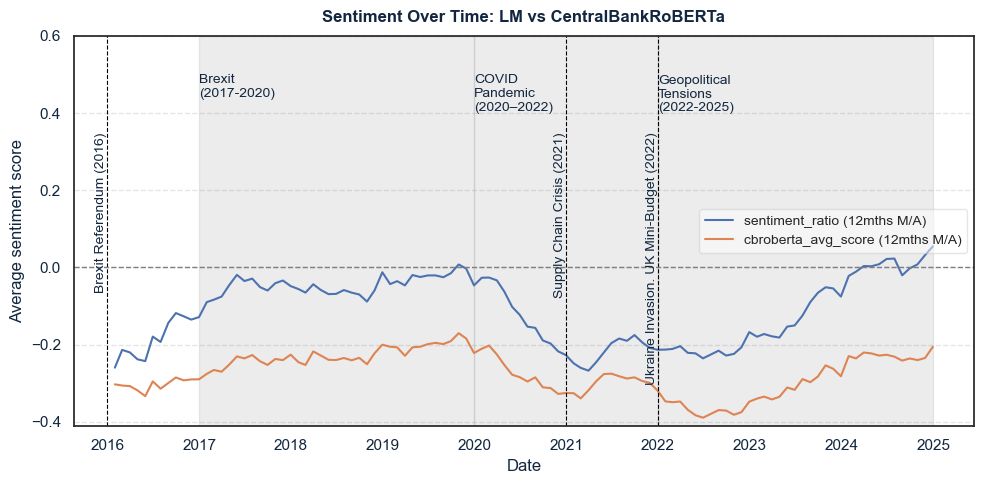

In [1500]:
# Set index and select numeric columns
df = master_daily_2016_2024.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()

monthly_data = df[[
    # 'financial_sector', 
   'sentiment_ratio', 
   # 'finbert_score', 
   'cbroberta_avg_score'
]].resample('ME').mean().ffill()

monthly_data_ma = monthly_data.rolling(window=12, min_periods=1).mean()

# Plot
plt.figure(figsize=(10, 5))
for col in monthly_data:
    plt.plot(monthly_data_ma.index, monthly_data_ma[col], 
             label=f"{col} (12mths M/A)", linewidth=1.5, alpha=1)

# Define periods to highlight
highlight_periods = {
    'Brexit\n(2017-2020)': (2017, 2020),
    'COVID\nPandemic\n(2020–2022)': (2020, 2022),
    'Geopolitical\nTensions\n(2022-2025)': (2022, 2025)
}

# Highlight multiple periods
for label, (start_year, end_year) in highlight_periods.items():
    start = pd.to_datetime(f'{start_year}-01-01')
    end = pd.to_datetime(f'{end_year}-01-01')
    plt.axvspan(start, end, color='gray', alpha=0.15)
    plt.text(x=start, y=0.5, s=label, fontsize=10, color='#12273f', ha='left', va='top', wrap=False)

# Vertical event lines
event_lines = {
    'Brexit Referendum (2016)': 2016,
    'Supply Chain Crisis (2021)': 2021,
    'Ukraine Invasion. UK Mini-Budget (2022)': 2022
}
for label, year in event_lines.items():
    year = pd.to_datetime(f'{year}-01-01')
    plt.axvline(year, color='black', linestyle='--', linewidth=0.8)
    plt.text(year, 0.35, label, rotation=90, 
             va='top', ha='right', fontsize=10, color='#12273f')

# Horizontal line at 0
plt.axhline(0, color='grey', linestyle='--', linewidth=1)

# X-axis formatting
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=0)

# Final formatting
plt.ylim(top=0.6)  # pushes plot down by lowering the bottom y-limit
plt.xlabel("Date", color='#12273f')
plt.ylabel("Average sentiment score", color='#12273f')
plt.xticks(color='#12273f')
plt.yticks(color='#12273f')
plt.title("Sentiment Over Time: LM vs CentralBankRoBERTa", color='#12273f', fontweight='bold', pad=10)
plt.legend(title=None, loc='center right', fancybox=True, framealpha=0.5, fontsize=10)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.savefig("sentiment_overtime_lm_cb.png", dpi=300, bbox_inches='tight')
plt.show()

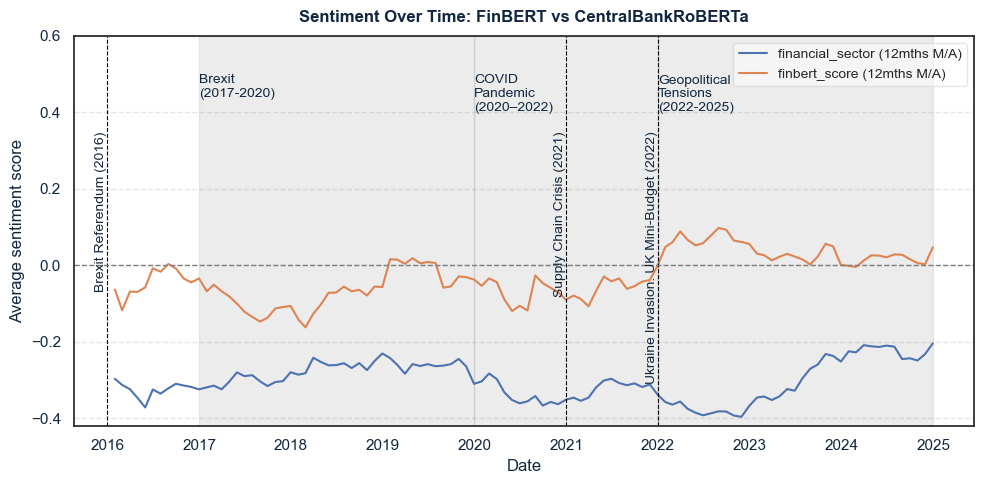

In [1506]:
# Set index and select numeric columns
df = master_daily_2016_2024.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()

monthly_data = df[[
    'financial_sector', 
   # 'sentiment_ratio', 
   'finbert_score', 
   # 'cbroberta_avg_score'
]].resample('ME').mean().ffill()

monthly_data_ma = monthly_data.rolling(window=12, min_periods=1).mean()

# Plot
plt.figure(figsize=(10, 5))
for col in monthly_data:
    plt.plot(monthly_data_ma.index, monthly_data_ma[col], 
             label=f"{col} (12mths M/A)", linewidth=1.5, alpha=1)

# Define periods to highlight
highlight_periods = {
    'Brexit\n(2017-2020)': (2017, 2020),
    'COVID\nPandemic\n(2020–2022)': (2020, 2022),
    'Geopolitical\nTensions\n(2022-2025)': (2022, 2025)
}

# Highlight multiple periods
for label, (start_year, end_year) in highlight_periods.items():
    start = pd.to_datetime(f'{start_year}-01-01')
    end = pd.to_datetime(f'{end_year}-01-01')
    plt.axvspan(start, end, color='gray', alpha=0.15)
    plt.text(x=start, y=0.5, s=label, fontsize=10, color='#12273f', ha='left', va='top', wrap=False)

# Vertical event lines
event_lines = {
    'Brexit Referendum (2016)': 2016,
    'Supply Chain Crisis (2021)': 2021,
    'Ukraine Invasion. UK Mini-Budget (2022)': 2022
}
for label, year in event_lines.items():
    year = pd.to_datetime(f'{year}-01-01')
    plt.axvline(year, color='black', linestyle='--', linewidth=0.8)
    plt.text(year, 0.35, label, rotation=90, 
             va='top', ha='right', fontsize=10, color='#12273f')

# Horizontal line at 0
plt.axhline(0, color='grey', linestyle='--', linewidth=1)

# X-axis formatting
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=0)

# Final formatting
plt.ylim(top=0.6)  # pushes plot down by lowering the bottom y-limit
plt.xlabel("Date", color='#12273f')
plt.ylabel("Average sentiment score", color='#12273f')
plt.xticks(color='#12273f')
plt.yticks(color='#12273f')
plt.title("Sentiment Over Time: FinBERT vs CentralBankRoBERTa", color='#12273f', fontweight='bold', pad=10)
plt.legend(title=None, loc='upper right', fancybox=True, framealpha=0.5, fontsize=10)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.savefig("sentiment_overtime_finbert_cb.png", dpi=300, bbox_inches='tight')
plt.show()

### Period of greatest sentiment volatility

Highest variance period: 2023-12-29 to 2024-02-29


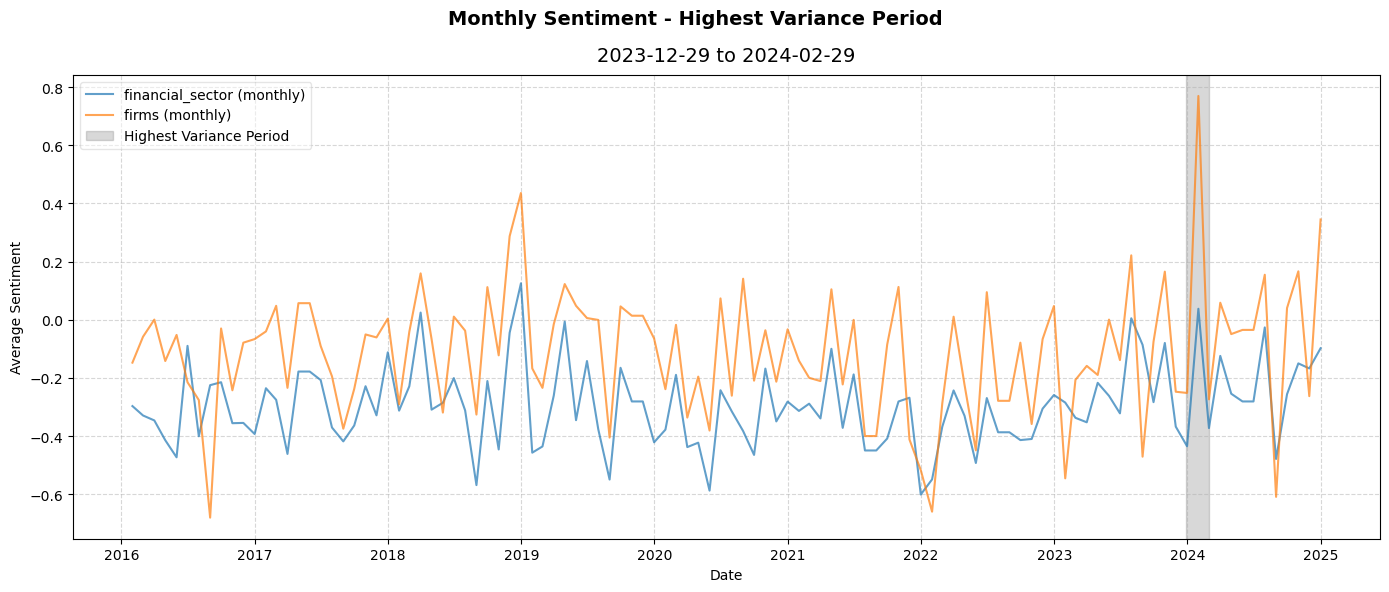

In [343]:
# #-months MA for better visual

# Step 1: Ensure datetime index
df = master_daily_2016_2024.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').set_index('date')

# Step 2: Resample to monthly averages
monthly_df = df[['financial_sector', 'firms']].resample('ME').mean()

# Forward fill missing monthly data before plotting and analysis
monthly_df = monthly_df.ffill()

# Step 3: Compute #-month rolling variance on cleaned data
window = 3
rolling_var = monthly_df.rolling(window=window).var()
rolling_var['total_variance'] = rolling_var.sum(axis=1)

# Step 4: Forward fill rolling_var to remove initial NaNs
rolling_var = rolling_var.ffill()

# Step 5: Find highest variance window
max_var_date = rolling_var['total_variance'].idxmax()
start_date = max_var_date - pd.DateOffset(months=window - 1)
end_date = max_var_date

print(f"Highest variance period: {start_date.date()} to {end_date.date()}")

# Step 6: Plot the filled monthly data
plt.figure(figsize=(14, 6))
plt.plot(monthly_df.index, monthly_df['financial_sector'], label='financial_sector (monthly)', alpha=0.7)
plt.plot(monthly_df.index, monthly_df['firms'], label='firms (monthly)', alpha=0.7)

# Highlight high-variance period
plt.axvspan(start_date, end_date, color='gray', alpha=0.3, label='Highest Variance Period')

# Formatting
plt.suptitle("Monthly Sentiment - Highest Variance Period",
          fontsize=14, weight='bold')
plt.title(f"{start_date.date()} to {end_date.date()}",
          fontsize=14, pad=10)
plt.xlabel("Date")
plt.ylabel("Average Sentiment")
plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

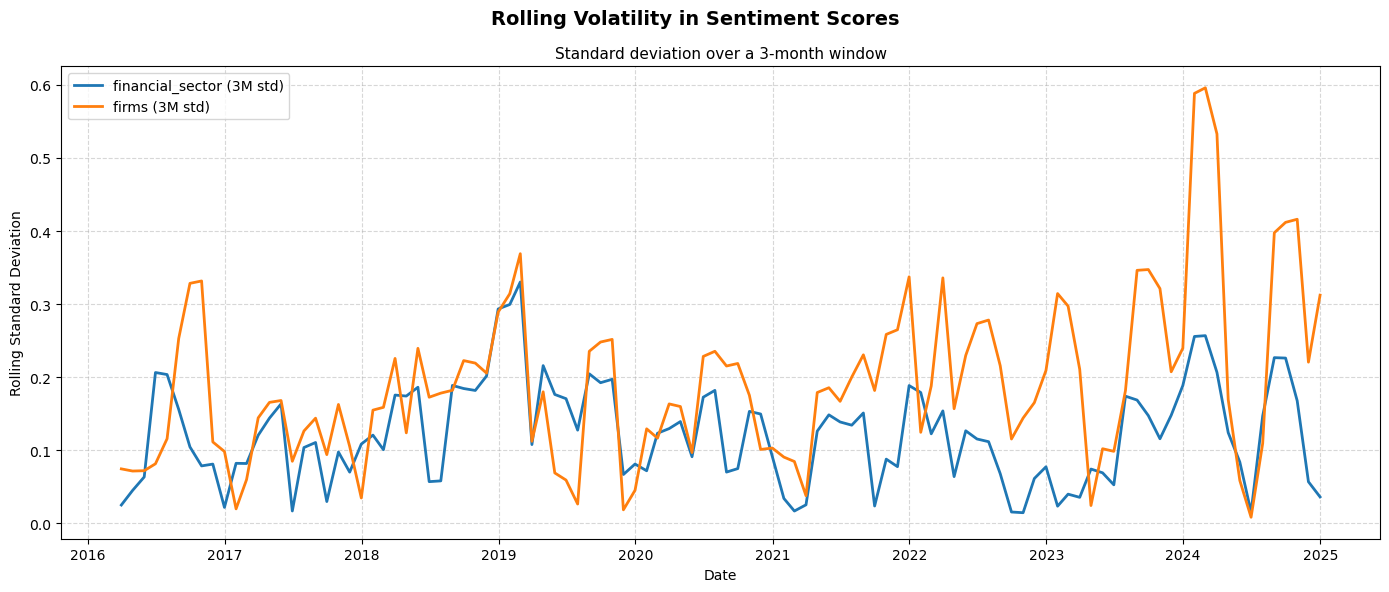

In [344]:
# Highest standard deviation

# Step 1: Prepare your data (resample to monthly average)
df = master_daily_2016_2024.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()

monthly_df = df[['financial_sector', 'firms']].resample('ME').mean()
monthly_df = monthly_df.ffill()  # fill gaps

# Step 2: Compute rolling standard deviation (e.g., 3-month window)
rolling_std = monthly_df.rolling(window=3).std()

# Step 3: Plot
plt.figure(figsize=(14, 6))
plt.plot(rolling_std.index, rolling_std['financial_sector'], label='financial_sector (3M std)', linewidth=2)
plt.plot(rolling_std.index, rolling_std['firms'], label='firms (3M std)', linewidth=2)

# Titles and formatting
plt.suptitle("Rolling Volatility in Sentiment Scores", fontsize=14, fontweight='bold')
plt.title("Standard deviation over a 3-month window", fontsize=11, fontweight='normal')
plt.xlabel("Date")
plt.ylabel("Rolling Standard Deviation")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### PLOT: peak sentiment volatility

Peak volatility period: 2023-12-29 to 2024-02-29


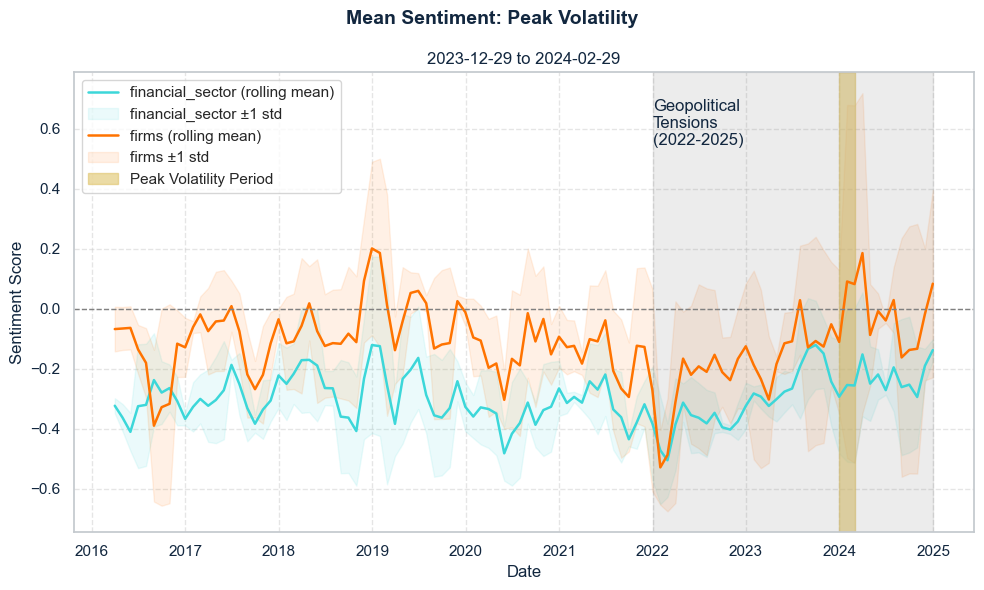

In [1508]:
# Standard deviation analysis

# Step 1: Prepare time series
df = master_daily_2016_2024.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()

# Monthly average
monthly_df = df[['financial_sector', 'firms']].resample('ME').mean().ffill()

# Step 2: Rolling mean and std (e.g., 3-month)
window = 3
rolling_mean = monthly_df.rolling(window=window).mean()
rolling_std = monthly_df.rolling(window=window).std()

# Step 3: Find peak volatility (based on sum of std)
rolling_std['total_std'] = rolling_std.sum(axis=1)
max_vol_date = rolling_std['total_std'].idxmax()
vol_start = max_vol_date - pd.DateOffset(months=window - 1)
vol_end = max_vol_date

print(f"Peak volatility period: {vol_start.date()} to {vol_end.date()}")

# Step 4: Plot
fig, ax = plt.subplots(figsize=(10, 6))

colors = {
    'financial_sector': '#3CD7D9',
    'firms': '#FF7300'
}



for col in ['financial_sector', 'firms']:
    # Rolling mean line
    ax.plot(rolling_mean.index, rolling_mean[col], label=f'{col} (rolling mean)', linewidth=1.8, color=colors[col])
    
    # ±1 std shading
    ax.fill_between(
        rolling_mean.index,
        rolling_mean[col] - rolling_std[col],
        rolling_mean[col] + rolling_std[col],
        alpha=0.1,
        label=f'{col} ±1 std', color=colors[col]
    )

# Step 5: Highlight peak volatility
ax.axvspan(vol_start, vol_end, color='#dfc369', alpha=0.6, label='Peak Volatility Period')

# Horizontal line at 0
ax.axhline(y=0, color='grey', linestyle='--', linewidth=1)

# Define periods to highlight
highlight_periods = {
    'Geopolitical\nTensions\n(2022-2025)': (2022, 2025)
}

# Highlight multiple periods
for label, (start_year, end_year) in highlight_periods.items():
    start = pd.to_datetime(f'{start_year}-01-01')
    end = pd.to_datetime(f'{end_year}-01-01')
    plt.axvspan(start, end, color='gray', alpha=0.15)
    # print(f'start={start}, end={end}, label={label}')
    plt.text(x=start, y=0.7, s=label, fontsize=12, color='#12273f', ha='left', va='top', wrap=False)

# Change all spines to custom color
for spine in ax.spines.values():
    spine.set_color('#c4c9ce') 

# Final formatting
fig.suptitle("Mean Sentiment: Peak Volatility", fontsize=14, fontweight='bold', color='#12273f',
             ha='center')
ax.set_title(f"{vol_start.date()} to {vol_end.date()}",
          fontsize=12, color='#12273f', loc='center')
# plt.title(f"{window}-Month Window ± Standard Deviation", fontsize=11, pad=5)
ax.set_xlabel("Date", color='#12273f')
ax.set_ylabel("Sentiment Score", color='#12273f')
ax.tick_params(axis='x', labelsize=11, colors='#12273f')
ax.tick_params(axis='y', labelsize=11, colors='#12273f')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("peak_sentiment_volatility.png", dpi=300, bbox_inches='tight')
plt.show()

In [1352]:
check_topic = master_daily_2016_2024.copy()

# List of columns to keep
columns_to_keep = ['date', 'author', 'is_gov', 'dominant_topic', 'dominant_topic_name']

# Subset 
check_topic = check_topic.loc[:, columns_to_keep]

mask = (
    (check_topic['date'] >= '2023-12-29') &
    (check_topic['date'] <= '2024-02-29')
)

# Preview
check_topic = check_topic.loc[mask]
check_topic

date            author  is_gov  dominant_topic  \
501  2024-01-25  Victoria Cleland       0               0   
502  2024-01-29       Lee Foulger       0               5   
503  2024-02-07     Sarah Breeden       0               3   
504  2024-02-08           L. Mann       0               7   
505  2024-02-12     Andrew Bailey       1               4   
506  2024-02-15      Megan Greene       0               7   
507  2024-02-21     Swati Dhingra       0               7   
508  2024-02-27      Dave Ramsden       0               5   

                     dominant_topic_name  
501     Financial Stability & Governance  
502            Liquidity & Asset Markets  
503  Forecasting & Uncertainty Modelling  
504          Inflation & Monetary Policy  
505      Banking & Insurance Supervision  
506          Inflation & Monetary Policy  
507          Inflation & Monetary Policy  
508            Liquidity & Asset Markets

## agents_dispersion

In [49]:
# Import relevant libraries.
import gdown # activate for local download of .csv from Google Drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [47]:
# Import dataset
agent_sentiment_pivot = pd.read_csv('agent_sentiment_pivot.csv')

In [318]:
# Prepare dataset
convert_date_column(agent_sentiment_pivot)

# Subset from 2015-01-20 to 2024-12-16
agent_sent_subset = subset_by_date_range(agent_sentiment_pivot, start = '2016-01-01', end = '2024-12-16')

### PLOT: agents_dispersion

In [320]:
# Step 1: Prepare time series
df = agent_sent_subset.copy()
df = df.rename(columns={
    'central_bank': 'Central Bank', 
    'financial_sector': 'Financial Sector', 
    'firms': 'Firms',
    'government': 'Government',
    'households': 'Households'
})
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()

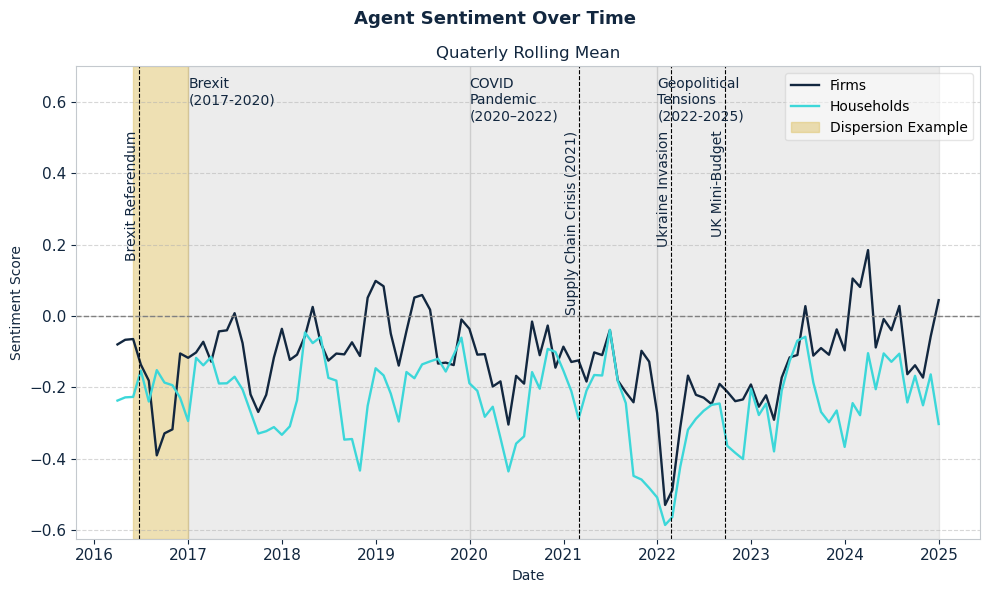

Divergence period: 2016-06-30 to 2016-07-31
Divergence period: 2016-08-31 to 2016-12-31
Divergence period: 2017-02-28 to 2017-05-31
Divergence period: 2017-12-31 to 2018-02-28
Divergence period: 2018-04-30 to 2018-06-30
Divergence period: 2018-07-31 to 2018-08-31
Divergence period: 2019-05-31 to 2019-06-30
Divergence period: 2019-07-31 to 2019-11-30
Divergence period: 2020-02-29 to 2020-05-31
Divergence period: 2020-07-31 to 2020-08-31
Divergence period: 2020-12-31 to 2021-01-31
Divergence period: 2021-02-28 to 2021-04-30
Divergence period: 2021-10-31 to 2021-11-30
Divergence period: 2022-05-31 to 2022-08-31
Divergence period: 2022-11-30 to 2022-12-31
Divergence period: 2023-09-30 to 2023-10-31
Divergence period: 2024-12-31 to 2024-12-31


In [324]:
# Mean
df_to_plot = df[[
    'Central Bank', 
    'Financial Sector', 
    'Firms',
    'Government',
    'Households'
]].resample('ME').mean().ffill()

# Step 2: Rolling mean and std (e.g., 3-month)
window = 3
rolling_mean = df_to_plot.rolling(window=window).mean()
# rolling_std = df_to_plot.rolling(window=window).std()

# Step 2.1: Compute rolling slope (1st difference to approximate direction)
direction = rolling_mean.diff()

# Step 2.2: Identify divergence based on direction (opposite slopes) 
divergence_mask = (direction['Firms'] * direction['Households'] < 0)

# Step 2.3: Group into periods
divergence_periods = []
in_period = False
start_date = None
for date, is_diverging in divergence_mask.items():
    if is_diverging and not in_period:
        start_date = date
        in_period = True
    elif not is_diverging and in_period:
        end_date = date
        divergence_periods.append((start_date, end_date))
        in_period = False
if in_period:
    divergence_periods.append((start_date, divergence_mask.index[-1]))

# Step 3: Plot
fig, ax = plt.subplots(figsize=(10, 6))

colors = {
    # 'Financial Sector': '#A5D700',
    'Firms': '#12273F',
    # 'Central Bank': '#5297FF', 
    # 'Government': '#FF7300',
    'Households': '#3CD7D9'
}

for col in [
    # 'Central Bank', 
    # 'Financial Sector', 
    'Firms',
    # 'Government',
    'Households'
]:
    ax.plot(rolling_mean.index, rolling_mean[col], label=f'{col}', linewidth=1.7, color=colors[col])

# Horizontal line at 0
ax.axhline(y=0, color='grey', linestyle='--', linewidth=1)

# # Highlight all divergence periods
# for i, (start, end) in enumerate(divergence_periods):
#     ax.axvspan(start, end, color='#dfc369', alpha=0.5, label='Divergence Period' if i == 0 else None)

# ______________________________________________________________________________________________________________________
# Define periods to highlight
highlight_periods = {
    # '2': ('2015-07-31', '2015-10-31'),
    '4-5': ('2016-06-01', '2016-12-31'),
    # '6': ('2017-02-28', '2017-05-31'),
    # '8': ('2018-04-30', '2018-06-30'),
    # '15': ('2021-02-28', '2021-04-30'),
    # '17': ('2022-05-31', '2022-08-31')
}
for i, (label, (start, end)) in enumerate(highlight_periods.items()):
    plt.axvspan(
        start, end,
        color='#dfc369',
        alpha=0.5,
        label='Dispersion Example' if i == 0 else None
    )

# ______________________________________________________________________________________________________________________  
# Define periods to highlight
highlight_periods = {
    'Brexit\n(2017-2020)': (2017, 2020),
    'COVID\nPandemic\n(2020–2022)': (2020, 2022),
    'Geopolitical\nTensions\n(2022-2025)': (2022, 2025)
}

# Highlight multiple periods
for label, (start_year, end_year) in highlight_periods.items():
    start = pd.to_datetime(f'{start_year}-01-01')
    end = pd.to_datetime(f'{end_year}-01-01')
    plt.axvspan(start, end, color='grey', alpha=0.15)
    plt.text(x=start, y=0.67, s=label, fontsize=10, color='#12273f', ha='left', va='top', wrap=False)

# Vertical event lines
event_lines = {
    'Brexit Referendum': '2016-06-23',
    'Supply Chain Crisis (2021)': '2021-03-01',
    'Ukraine Invasion': '2022-02-24',
    'UK Mini-Budget': '2022-09-23'
}
for label, date_str in event_lines.items():
    event_date = pd.to_datetime(date_str)
    plt.axvline(event_date, color='black', linestyle='--', linewidth=0.8)
    plt.text(event_date, 0.52, label, rotation=90, 
             va='top', ha='right', fontsize=10, color='#12273f')
# ______________________________________________________________________________________________________________________

# Change all spines to custom color
for spine in ax.spines.values():
    spine.set_color('#c4c9ce') 

# Final formatting
plt.ylim(top=0.7)
fig.suptitle("Agent Sentiment Over Time", fontsize=13, fontweight='bold', color='#12273f', ha='center')
ax.set_title("Quaterly Rolling Mean", fontsize=12, color='#12273f', ha='center', loc='center')
ax.set_xlabel("Date", fontsize=10, color='#12273f')
ax.set_ylabel("Sentiment Score", fontsize=10, color='#12273f')
ax.tick_params(axis='x', labelsize=11, colors='#12273f')
ax.tick_params(axis='y', labelsize=11, colors='#12273f')
ax.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("agents_dispersion.png", dpi=300, bbox_inches='tight')
plt.show()

# Print divergence periods
for start, end in divergence_periods:
    print(f"Divergence period: {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')}")

In [220]:
# List of columns to keep
columns_to_keep = ['custom_ref', 'date', 'author', 'is_gov', 'firms', 'households', 'text']

# Subset 
check_speaker = agent_sent_subset.loc[:, columns_to_keep]

mask = (
    (check_speaker['date'] >= '2015-01-20') &
    (check_speaker['date'] <= '2016-12-31')
)

# Preview
check_speaker = check_speaker.loc[mask]
check_speaker

custom_ref       date      author  is_gov     firms  \
684    UK_2015-01-20_cunliffe 2015-01-20    cunliffe       0  0.229372   
685      UK_2015-01-22_fisher 2015-01-22      fisher       0  0.042906   
686       UK_2015-01-22_miles 2015-01-22       miles       0 -0.492868   
687      UK_2015-01-23_gracie 2015-01-23      gracie       0 -0.232797   
688      UK_2015-01-26_forbes 2015-01-26      forbes       0 -0.322947   
..                        ...        ...         ...     ...       ...   
836      UK_2016-12-06_hauser 2016-12-06      hauser       0  0.472261   
837     UK_2016-12-14_no_info 2016-12-14     no_info       0 -0.144348   
838      UK_2016-12-15_forbes 2016-12-15      forbes       0  0.059165   
839  UK_2016-12-20_mccafferty 2016-12-20  mccafferty       0 -0.434185   
840       UK_2016-12-21_brown 2016-12-21       brown       0 -0.171773   

     households                                               text  
684   -0.244216  The Treaty of Rome, signed in 1957, establishe...  
685   -0.163172  Thank you for inviting me to speak to you toda...  
686   -0.461885  What can monetary policy be expected to do? My...  
687   -0.148825  In the last few weeks in mainstream media cybe...  
688   -0.301404  Since starting my role on the MPC in July, one...  
..          ...                                                ...  
836   -0.071649  Thank you very much for the opportunity to spe...  
837    0.240162  It is my great pleasure to have been invited, ...  
838   -0.798701  Most conversations about economic growth rates...  
839   -0.393502  It is much overused, but the alleged old Chine...  
840   -0.341104  Good morning everyone. Firstly, may I say how ...  

[157 rows x 7 columns]

## Correlation analysis

In [347]:
# List of columns to check for duplicate rows
columns_to_check = ['custom_ref','date','author']  # replace with your relevant columns

# Show rows where 'date' is duplicated
duplicates = master_daily_2016_2024[
             master_daily_2016_2024.duplicated(subset=columns_to_check, keep=False)]
print(duplicates)

Empty DataFrame
Columns: [Unnamed: 0, custom_ref, date, author, is_gov, central_bank, financial_sector, firms, government, households, cbroberta_avg_score, cbroberta_avg_sentiment, text, finbert_pos, finbert_neg, finbert_neu, finbert_sentiment, finbert_score, finbert_confidence, sentiment_ratio, sentiment_label, uncertainty_score, topic_0, topic_1, topic_2, topic_3, topic_4, topic_5, topic_6, topic_7, dominant_topic, dominant_topic_name, ftse250, ftse100, gilt_2y, gilt_10y, ois_1m, ois_3m, ois_6m, ois_12m, sonia, vix, gbp_usd_d]
Index: []

[0 rows x 43 columns]


In [348]:
master_daily_2016_2024.columns

Index(['Unnamed: 0', 'custom_ref', 'date', 'author', 'is_gov', 'central_bank',
       'financial_sector', 'firms', 'government', 'households',
       'cbroberta_avg_score', 'cbroberta_avg_sentiment', 'text', 'finbert_pos',
       'finbert_neg', 'finbert_neu', 'finbert_sentiment', 'finbert_score',
       'finbert_confidence', 'sentiment_ratio', 'sentiment_label',
       'uncertainty_score', 'topic_0', 'topic_1', 'topic_2', 'topic_3',
       'topic_4', 'topic_5', 'topic_6', 'topic_7', 'dominant_topic',
       'dominant_topic_name', 'ftse250', 'ftse100', 'gilt_2y', 'gilt_10y',
       'ois_1m', 'ois_3m', 'ois_6m', 'ois_12m', 'sonia', 'vix', 'gbp_usd_d'],
      dtype='object')

In [349]:
# Columns to include in the correlation
cols_to_include = [
    'central_bank', 'financial_sector', 'firms', 'government', 'households', 'cbroberta_avg_score',
    'finbert_score', 'sentiment_ratio',
    'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7',
    'ftse250', 'ftse100', 
    'gilt_2y', 'gilt_10y',
    'ois_1m', 'ois_3m', 'ois_6m', 'ois_12m', 
    'sonia', 'vix', 'gbp_usd_d'
]

# Compute correlation only for specified columns
corr = master_daily_2016_2024[cols_to_include].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
np.fill_diagonal(mask, False)

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define custom diverging colormap
custom_cmap = LinearSegmentedColormap.from_list(
    name='custom_diverging',
    colors=['#FF7300', '#c4c9ce', '#3CD7D9'],  # from -1 to 0 to +1
    N=256
)

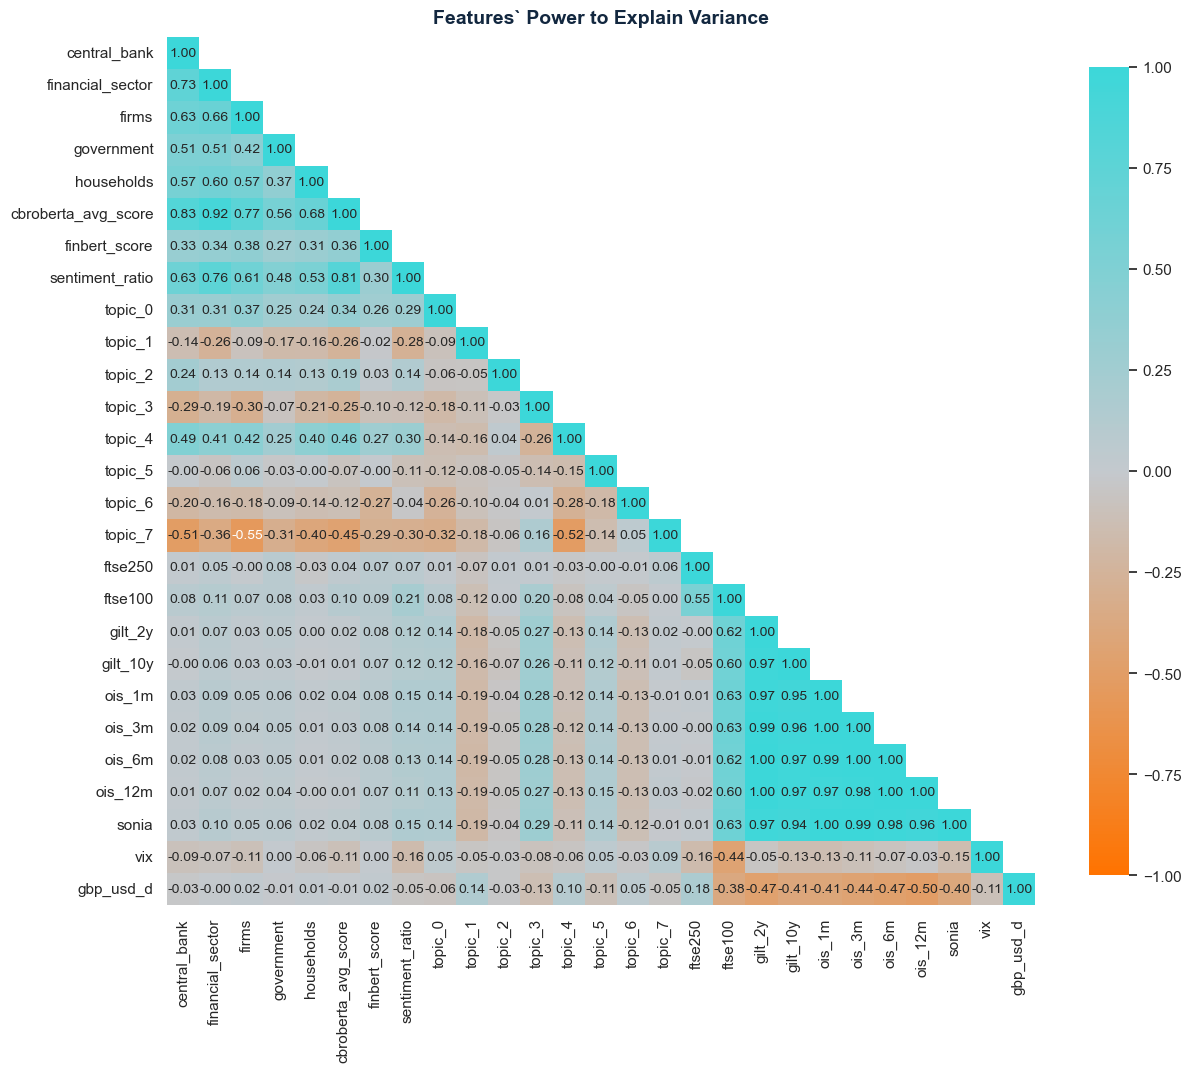

In [350]:
# Plot explanatory power btwn variables
sns.set_theme(style="white")
plt.figure(figsize=(14, 14))
sns.heatmap(corr, mask=mask, annot=True, cmap=custom_cmap, fmt = '.2f',
           vmin=-1, center=0, vmax=1, square=True, linewidths=0, annot_kws={"fontsize": 10}, cbar_kws={"shrink": .75})
plt.title('Features` Power to Explain Variance', fontsize=14, weight='bold', pad=10, color='#12273f')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
# plt.savefig("corr_daily_2016_2024.png", dpi=300, bbox_inches='tight')
plt.show()

In [1512]:
# For the period of highest volatility
master_daily_subset = subset_by_date_range(master_daily, start= '2023-11-29', end= '2024-03-15')

print("master_daily_subset:")
print(master_daily_subset['date'].agg(['min', 'max']))

master_daily_subset:
min   2023-11-29
max   2024-03-12
Name: date, dtype: datetime64[ns]


In [1514]:
# Columns to include in the correlation
cols_to_include = [
    'central_bank', 'financial_sector', 'firms', 'government', 'households', 'cbroberta_avg_score',
    'finbert_score', 'sentiment_ratio',
    'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7',
    'ftse250', 'ftse100', 
    'gilt_2y', 'gilt_10y',
    'ois_1m', 'ois_3m', 'ois_6m', 'ois_12m', 
    'sonia', 'vix', 'gbp_usd_d'
]

# Compute correlation only for specified columns
corr = master_daily_subset[cols_to_include].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
np.fill_diagonal(mask, False)

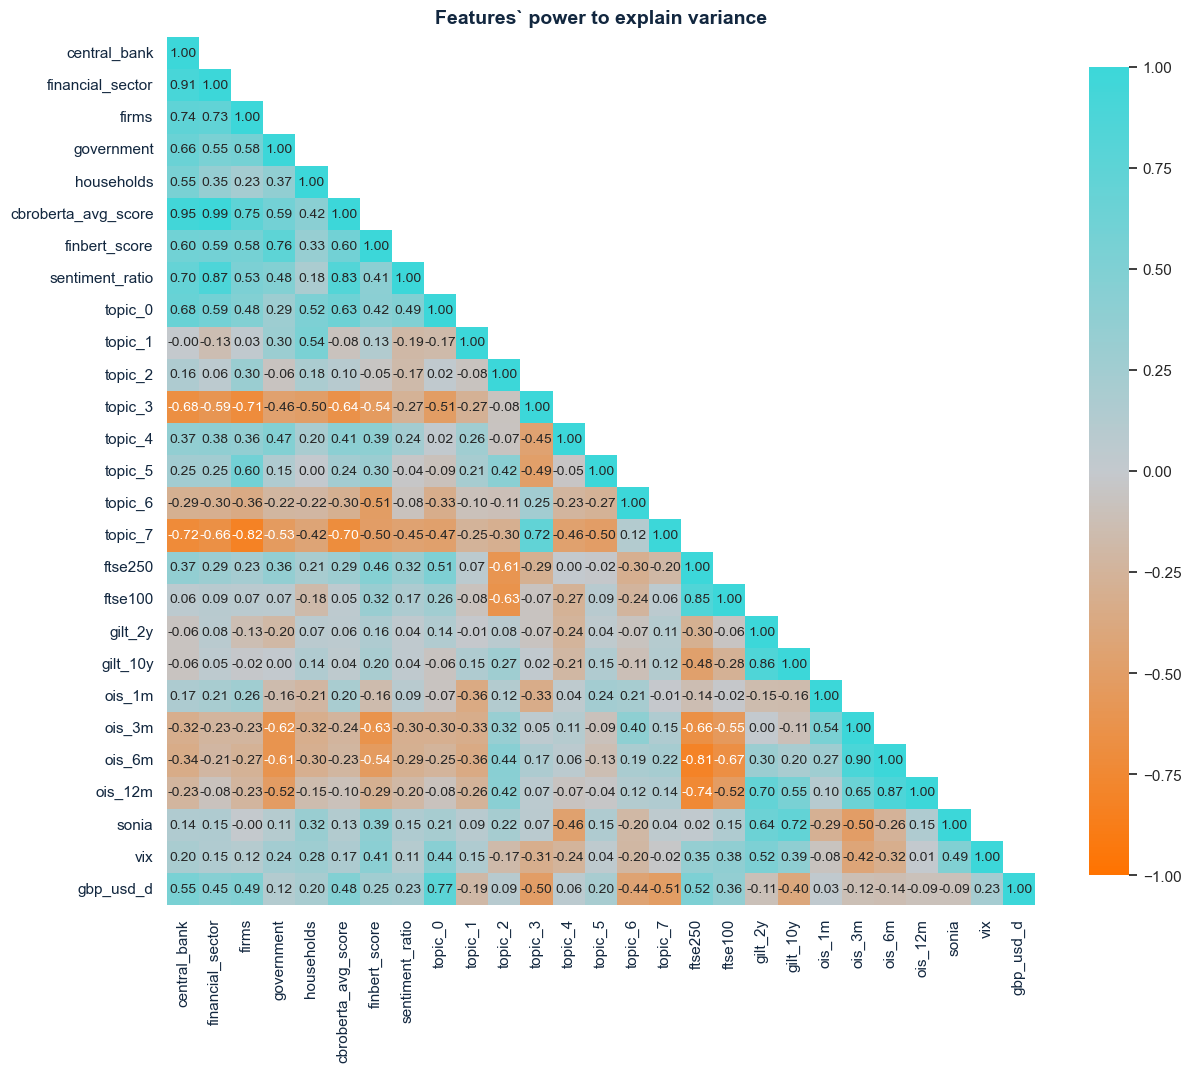

In [1516]:
# Plot explanatory power btwn variables
sns.set_theme(style="white")
plt.figure(figsize=(14, 14))
sns.heatmap(corr, mask=mask, annot=True, cmap=custom_cmap, fmt = '.2f',
           vmin=-1, center=0, vmax=1, square=True, linewidths=0, annot_kws={"fontsize": 10}, cbar_kws={"shrink": .75})
plt.title('Features` power to explain variance', fontsize=14, weight='bold', pad=10, color='#12273f')
plt.xticks(fontsize=11, color='#12273f')
plt.yticks(fontsize=11, color='#12273f')
# plt.savefig("corr_daily_2023_2024.png", dpi=300, bbox_inches='tight')
plt.show()

In [1518]:
# Columns to include in the correlation
cols_to_include = [
    'central_bank', 'financial_sector', 'firms', 'households',
    'ftse250',  
    'gilt_2y', 'gilt_10y',
    'ois_3m', 
    'gbp_usd_d'
]

# Compute correlation only for specified columns
corr = master_daily_subset[cols_to_include].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
np.fill_diagonal(mask, False)

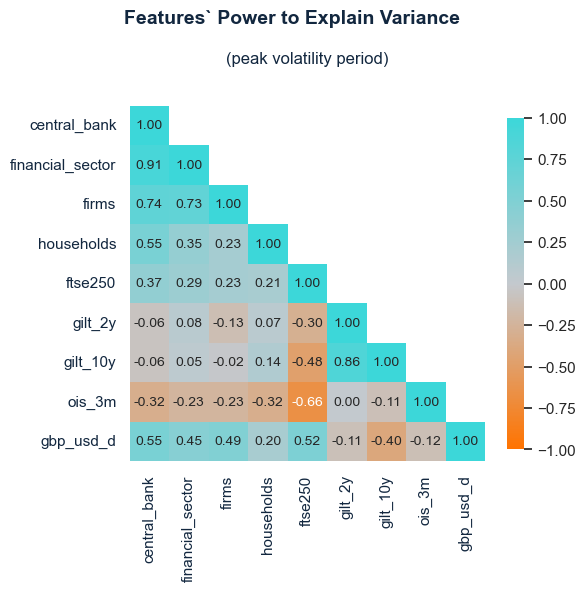

In [1520]:
# Plot explanatory power btwn variables
sns.set_theme(style="white")
plt.figure(figsize=(6, 6))
sns.heatmap(corr, mask=mask, annot=True, cmap=custom_cmap, fmt = '.2f',
           vmin=-1, center=0, vmax=1, square=True, linewidths=0, annot_kws={"fontsize": 10}, cbar_kws={"shrink": .75})
plt.suptitle("Features` Power to Explain Variance", fontsize=14, weight='bold', color='#12273f')
plt.title("(peak volatility period)", pad=5, color='#12273f', y=1.1)
plt.xticks(fontsize=11, color='#12273f')
plt.yticks(fontsize=11, color='#12273f')
plt.tight_layout()
plt.savefig("corr_daily_subset.png", dpi=300, bbox_inches='tight')
plt.show()

## Cross-correlation analysis

In [1211]:
# Split into 2 groups for cross-correlation
group_agents = [
    'central_bank', 'financial_sector', 'firms', 'government', 'households'  
]

group_indicators = [
    'ftse250', 'ftse100',
    'gilt_2y', 'gilt_10y',
    'ois_1m', 'ois_3m', 'ois_6m', 'ois_12m',
    'sonia', 'vix', 'gbp_usd_d'
]

group_topics = ['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7']

In [1212]:
print("master_daily_subset:")
print(master_daily_subset['date'].agg(['min', 'max']))

master_daily_subset:
min   2023-11-29
max   2024-03-12
Name: date, dtype: datetime64[ns]


In [1213]:
# Prepare the 
# Subset relevant columns
selected_cols_1 = group_agents + group_indicators
df_subset_1 = master_daily_subset[selected_cols_1].copy()

# Drop rows where all selected columns are NaN
df_subset_1 = df_subset_1.dropna(how='all')

# Ensure numeric conversion
for col in df_subset_1.columns:
    if df_subset_1[col].dtype == 'object':
        df_subset_1[col] = (
            df_subset_1[col].astype(str).str.replace(',', '', regex=False).replace('', np.nan).pipe(pd.to_numeric, errors='coerce'))

# Subset relevant columns
selected_cols_2 = group_topics + group_indicators
df_subset_2 = master_daily_subset[selected_cols_2].copy()

# Drop rows where all selected columns are NaN
df_subset_2 = df_subset_2.dropna(how='all')

# Ensure numeric conversion
for col in df_subset_2.columns:
    if df_subset_2[col].dtype == 'object':
        df_subset_2[col] = (
            df_subset_2[col].astype(str).str.replace(',', '', regex=False).replace('', np.nan).pipe(pd.to_numeric, errors='coerce'))

In [1214]:
# Check at what lag the sign changes
def full_lag_profile(x, y, max_lag=10):
    lags = range(-max_lag, max_lag + 1)
    corrs = []
    for lag in lags:
        if lag < 0:
            x_lag = x[:lag]
            y_lag = y[-lag:]
        elif lag > 0:
            x_lag = x[lag:]
            y_lag = y[:-lag]
        else:
            x_lag = x
            y_lag = y

        corr = x_lag.corr(y_lag)
        corrs.append(corr)
    return pd.Series(corrs, index=lags)

In [1256]:
profile_1 = full_lag_profile(df_subset_1['firms'], df_subset_1['ftse100'], max_lag=8)

# Show the lag where correlation flips from negative to positive
flip_lag_1 = profile_1[profile_1 > 0].index.min()
print("Lag where correlation becomes positive:", flip_lag_1)

Lag where correlation becomes positive: -7


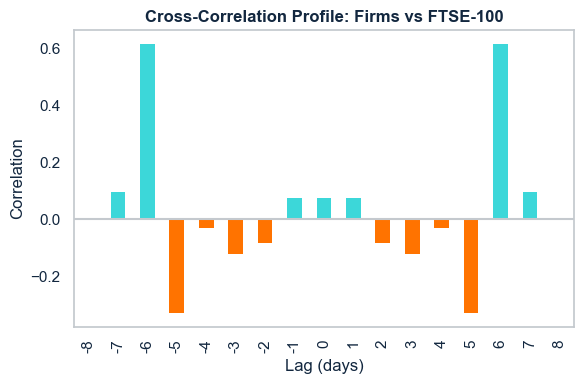

In [1522]:
# Plot the flips

colors = ['#3CD7D9' if val >= 0 else '#FF7300' for val in profile_1]
ax = profile_1.plot(kind='bar', figsize=(6, 4), color=colors, linewidth=0)
plt.axhline(0, color='#c4c9ce', linestyle='-')

# Change all spines to custom color
for spine in ax.spines.values():
    spine.set_color('#c4c9ce') 

# Styling
plt.title("Cross-Correlation Profile: Firms vs FTSE-100", fontweight='bold', color='#12273f')
plt.xlabel("Lag (days)", color='#12273f')
plt.ylabel("Correlation", color='#12273f')
plt.xticks(color='#12273f')
plt.yticks(color='#12273f')
plt.tight_layout()
plt.savefig("cross_corr_daily_firms_ftse100.png", dpi=300, bbox_inches='tight')
plt.show()

In [1217]:
# # Consider monthly mean instead of daily
# df_monthly_avg_1 = master_daily_subset[['financial_sector', 'households', 'firms',
#                        'central_bank', 'government', 
#                        'ftse250', 'ftse100', 'gilt_2y', 'gilt_10y', 'ois_1m', 'ois_3m', 'ois_6m', 'ois_12m', 'sonia', 'vix', 'gbp_usd_d']].resample('M').mean().ffill()
# df_monthly_subset_1 = df_monthly_avg_1[selected_cols_1].copy()

In [1282]:
profile_2 = full_lag_profile(df_subset_1['firms'], df_subset_1['ftse250'], max_lag=7)

# Show the lag where correlation flips from negative to positive
flip_lag_2 = profile_2[profile_2 > 0].index.min()
print("Lag where correlation becomes positive:", flip_lag_2)

Lag where correlation becomes positive: -7


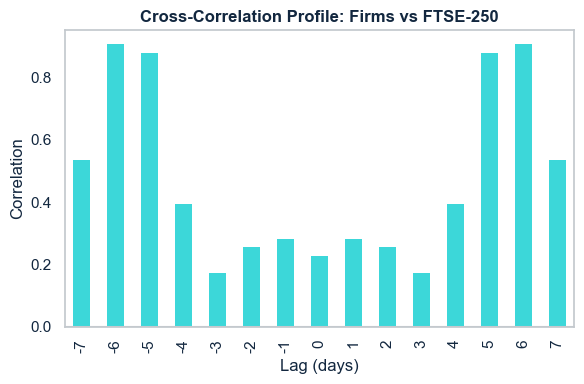

In [1284]:
# Plot the flips

colors = ['#3CD7D9' if val >= 0 else '#FF7300' for val in profile_2]
ax = profile_2.plot(kind='bar', figsize=(6, 4), color=colors, linewidth=0)
plt.axhline(0, color='#c4c9ce', linestyle='-')

# Change all spines to custom color
for spine in ax.spines.values():
    spine.set_color('#c4c9ce') 

# Styling
plt.title("Cross-Correlation Profile: Firms vs FTSE-250", fontweight='bold', color='#12273f')
plt.xlabel("Lag (days)", color='#12273f')
plt.ylabel("Correlation", color='#12273f')
plt.xticks(color='#12273f')
plt.yticks(color='#12273f')
plt.tight_layout()
plt.show()

In [1268]:
profile_3 = full_lag_profile(df_subset_1['financial_sector'], df_subset_1['gilt_10y'], max_lag=7)

# Show the lag where correlation flips from negative to positive
flip_lag_3 = profile_3[profile_3 > 0].index.min()
print("Lag where correlation becomes positive:", flip_lag_3)

Lag where correlation becomes positive: -6


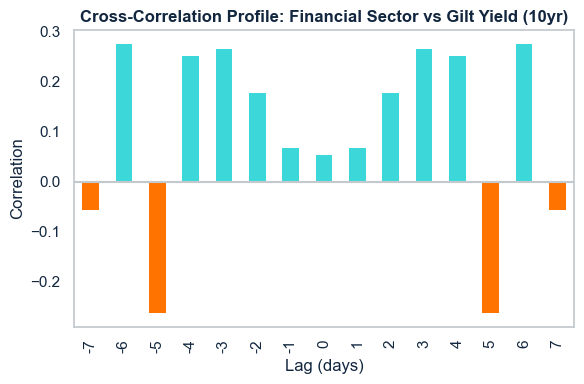

In [1524]:
# Plot the flips

colors = ['#3CD7D9' if val >= 0 else '#FF7300' for val in profile_3]
ax = profile_3.plot(kind='bar', figsize=(6, 4), color=colors, linewidth=0)
plt.axhline(0, color='#c4c9ce', linestyle='-')

# Change all spines to custom color
for spine in ax.spines.values():
    spine.set_color('#c4c9ce')

# Styling
plt.title("Cross-Correlation Profile: Financial Sector vs Gilt Yield (10yr)", fontweight='bold', color='#12273f')
plt.xlabel("Lag (days)", color='#12273f')
plt.ylabel("Correlation", color='#12273f')
plt.xticks(color='#12273f')
plt.yticks(color='#12273f')
plt.tight_layout()
plt.savefig("cross_corr_daily_finsec_gilt10yr.png", dpi=300, bbox_inches='tight')
plt.show()

In [1274]:
profile_4 = full_lag_profile(df_subset_1['households'], df_subset_1['vix'], max_lag=7)

# Show the lag where correlation flips from negative to positive
flip_lag_4 = profile_4[profile_4 > 0].index.min()
print("Lag where correlation becomes positive:", flip_lag_4)

Lag where correlation becomes positive: -7


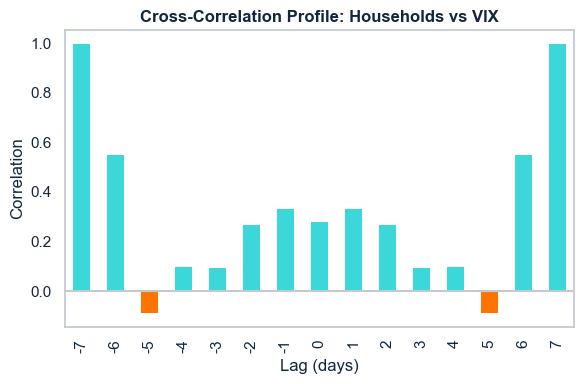

In [1276]:
# Plot the flips

colors = ['#3CD7D9' if val >= 0 else '#FF7300' for val in profile_4]
ax = profile_4.plot(kind='bar', figsize=(6, 4), color=colors, linewidth=0)
plt.axhline(0, color='#c4c9ce', linestyle='-')

# Change all spines to custom color
for spine in ax.spines.values():
    spine.set_color('#c4c9ce') 

# Styling
plt.title("Cross-Correlation Profile: Households vs VIX", fontweight='bold', color='#12273f')
plt.xlabel("Lag (days)", color='#12273f')
plt.ylabel("Correlation", color='#12273f')
plt.xticks(color='#12273f')
plt.yticks(color='#12273f')
plt.tight_layout()
plt.show()

In [1278]:
profile_5 = full_lag_profile(df_subset_1['financial_sector'], df_subset_1['gbp_usd_d'], max_lag=7)

# Show the lag where correlation flips from negative to positive
flip_lag_5 = profile_5[profile_5 > 0].index.min()
print("Lag where correlation becomes positive:", flip_lag_5)

Lag where correlation becomes positive: -7


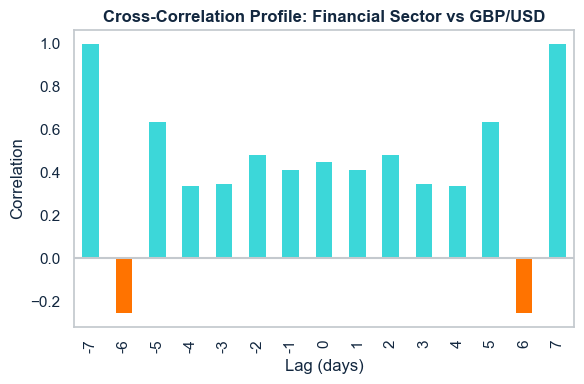

In [1280]:
# Plot the flips

colors = ['#3CD7D9' if val >= 0 else '#FF7300' for val in profile_5]
ax = profile_5.plot(kind='bar', figsize=(6, 4), color=colors, linewidth=0)
plt.axhline(0, color='#c4c9ce', linestyle='-')

# Change all spines to custom color
for spine in ax.spines.values():
    spine.set_color('#c4c9ce')

# Styling
plt.title("Cross-Correlation Profile: Financial Sector vs GBP/USD", fontweight='bold', color='#12273f')
plt.xlabel("Lag (days)", color='#12273f')
plt.ylabel("Correlation", color='#12273f')
plt.xticks(color='#12273f')
plt.yticks(color='#12273f')
plt.tight_layout()
plt.savefig("cross_corr_daily_finces_gbp_usd.png", dpi=300, bbox_inches='tight')
plt.show()

# Divergence during uncertainty

In [136]:
# Setup the work station
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import pandas as pd
import numpy as np

In [137]:
# Define custom diverging colormap
custom_cmap = LinearSegmentedColormap.from_list(
    name='custom_diverging',
    colors=['#FF7300', '#c4c9ce', '#3CD7D9'],  # from -1 to 0 to +1
    N=256
)

In [138]:
# Import dataset
cb_fn_lm_topic = pd.read_csv('cb_fn_lm_topic_local.csv')
convert_date_column(cb_fn_lm_topic)
cb_fn_lm_topic.shape

(1365, 32)

In [139]:
# cb_fn_lm_topic.info()

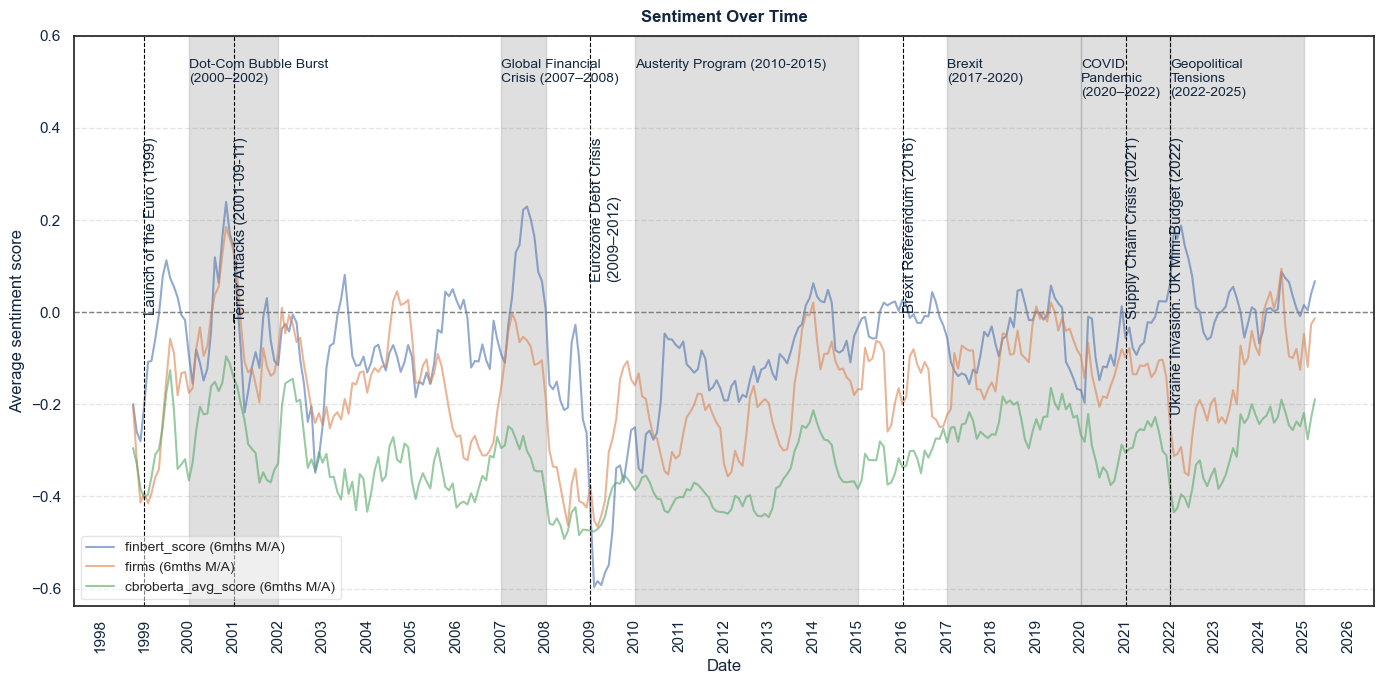

In [140]:
# Clean column names
cb_fn_lm_topic.columns = cb_fn_lm_topic.columns.str.strip()

# Set index and select numeric columns
df = cb_fn_lm_topic.set_index('date')
numeric_cols = df.select_dtypes(include='number')

# Resample monthly (month-end) and compute mean
monthly_data = numeric_cols.resample('ME').mean().reset_index()

# Compute 6-month moving average
cols_to_plot = [
    'finbert_score', 
    'firms', 
    'cbroberta_avg_score'
]
monthly_data_ma = monthly_data.copy()
monthly_data_ma[cols_to_plot] = monthly_data_ma[cols_to_plot].rolling(window=6, min_periods=1).mean()

# Plot
plt.figure(figsize=(14, 7))
for col in cols_to_plot:
    plt.plot(monthly_data_ma['date'], monthly_data_ma[col], 
             label=f"{col} (6mths M/A)", linewidth=1.5, alpha=0.6)

# Define periods to highlight
highlight_periods = {
    'Dot-Com Bubble Burst\n(2000–2002)': (2000, 2002),
    'Global Financial\nCrisis (2007–2008)': (2007, 2008),
    'Austerity Program (2010-2015)': (2010, 2015),
    'Brexit\n(2017-2020)': (2017, 2020),
    'COVID\nPandemic\n(2020–2022)': (2020, 2022),
    'Geopolitical\nTensions\n(2022-2025)': (2022, 2025)
}

# Highlight multiple periods
for label, (start_year, end_year) in highlight_periods.items():
    start = pd.to_datetime(f'{start_year}-01-01')
    end = pd.to_datetime(f'{end_year}-01-01')
    plt.axvspan(start, end, color='gray', alpha=0.25)
    # print(f'start={start}, end={end}, label={label}')
    plt.text(x=start, y=0.55, s=label, fontsize=10, color='#12273f', ha='left', va='top', wrap=False)

# Vertical event lines
event_lines = {
    # 'Asian Financial Crisis (1997)': 1997,
    'Launch of the Euro (1999)': 1999,
    'Terror Attacks (2001-09-11)': 2001,
    'Eurozone Debt Crisis\n(2009–2012)': 2009,
    'Brexit Referendum (2016)': 2016,
    'Supply Chain Crisis (2021)': 2021,
    'Ukraine Invasion. UK Mini-Budget (2022)': 2022
}
for label, year in event_lines.items():
    year = pd.to_datetime(f'{year}-01-01')
    plt.axvline(year, color='black', linestyle='--', linewidth=0.8)
    plt.text(year, plt.ylim()[1]*1.35, label, rotation=90, 
             va='top', ha='left', fontsize=11, color='#12273f')

# Horizontal line at 0
plt.axhline(0, color='grey', linestyle='--', linewidth=1)

# X-axis formatting
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=90)

# Final formatting
plt.ylim(top=0.6)  # pushes plot down by lowering the bottom y-limit
plt.xlabel("Date", color='#12273f')
plt.ylabel("Average sentiment score", color='#12273f')
plt.xticks(color='#12273f')
plt.yticks(color='#12273f')
plt.title("Sentiment Over Time", color='#12273f', fontweight='bold', pad=10)
plt.legend(title=None, loc='lower left', fancybox=True, framealpha=0.5, fontsize=10)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

In [141]:
# Subset for the key period
sub_period = cb_fn_lm_topic[
(cb_fn_lm_topic['date'] >= '2003-07-01') &
(cb_fn_lm_topic['date'] <= '2013-06-30')
]
sub_period

Unnamed: 0                custom_ref       date       author  is_gov  \
155         155     UK_2003-07-21_nickell 2003-07-21      nickell       0   
156         156        UK_2003-08-19_bean 2003-08-19         bean       0   
157         157      UK_2003-08-28_tucker 2003-08-28       tucker       0   
158         158     UK_2003-09-16_nickell 2003-09-16      nickell       0   
159         159        UK_2003-10-01_bean 2003-10-01         bean       0   
..          ...                       ...        ...          ...     ...   
579         579      UK_2013-06-13_hauser 2013-06-13       hauser       0   
580         580      UK_2013-06-13_tucker 2013-06-13       tucker       0   
581         581  UK_2013-06-14_mccafferty 2013-06-14   mccafferty       0   
582         582        UK_2013-06-19_King 2013-06-19  Mervyn King       1   
583         583       UK_2013-06-26_miles 2013-06-26        miles       0   

     central_bank  financial_sector     firms  government  households  ...  \
155     -0.541858         -0.474585 -0.205474   -0.609128   -0.522173  ...   
156     -0.496376         -0.668454 -0.239652   -0.764079    0.119484  ...   
157     -0.247115         -0.496579 -0.066628   -0.739378   -0.429291  ...   
158     -0.573714         -0.535439 -0.140640   -0.635031   -0.665239  ...   
159     -0.463756         -0.238783 -0.573293   -0.283540    0.109607  ...   
..            ...               ...       ...         ...         ...  ...   
579      0.014049         -0.368425  0.099130   -0.495246   -0.407612  ...   
580     -0.600985         -0.478889 -0.047258   -0.594404   -0.288854  ...   
581     -0.428734         -0.614312 -0.523452   -0.368594   -0.569731  ...   
582     -0.112281         -0.300780 -0.071960    0.042705    0.107647  ...   
583     -0.400319         -0.533054 -0.180489   -0.094369   -0.635361  ...   

      topic_0   topic_1   topic_2   topic_3   topic_4   topic_5   topic_6  \
155  0.000089  0.000089  0.000089  0.000089  0.000089  0.000089  0.999374   
156  0.048750  0.310137  0.000045  0.100411  0.000045  0.000045  0.000045   
157  0.000044  0.454698  0.000044  0.000044  0.000044  0.128763  0.000044   
158  0.000043  0.304502  0.000043  0.000043  0.000043  0.000043  0.093663   
159  0.247594  0.000046  0.000046  0.079112  0.020453  0.000046  0.016136   
..        ...       ...       ...       ...       ...       ...       ...   
579  0.000082  0.000082  0.000082  0.000082  0.322283  0.620924  0.056383   
580  0.000048  0.655907  0.000048  0.000048  0.307902  0.035950  0.000048   
581  0.030560  0.000067  0.000067  0.000067  0.000067  0.000067  0.000067   
582  0.000087  0.105255  0.000086  0.000086  0.627896  0.000087  0.000087   
583  0.000084  0.233919  0.000084  0.000084  0.000084  0.309534  0.000084   

      topic_7  dominant_topic              dominant_topic_name  
155  0.000089               6    Labour Markets & Productivity  
156  0.540522               7      Inflation & Monetary Policy  
157  0.416319               1         Credit & Housing Markets  
158  0.601621               7      Inflation & Monetary Policy  
159  0.636566               7      Inflation & Monetary Policy  
..        ...             ...                              ...  
579  0.000082               5        Liquidity & Asset Markets  
580  0.000048               1         Credit & Housing Markets  
581  0.969040               7      Inflation & Monetary Policy  
582  0.266416               4  Banking & Insurance Supervision  
583  0.456125               7      Inflation & Monetary Policy  

[429 rows x 32 columns]

In [142]:
# Columns to include in the correlation
cols_to_include = [
    'finbert_score', 
    'cbroberta_avg_score',
    'central_bank',
    'financial_sector',
    'firms',
    'government',
    'households',
]

In [143]:
# Optional: correlation matrix between agents
agent_correlation = sub_period[cols_to_include].corr()

In [144]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(agent_correlation, dtype=bool))
np.fill_diagonal(mask, False)

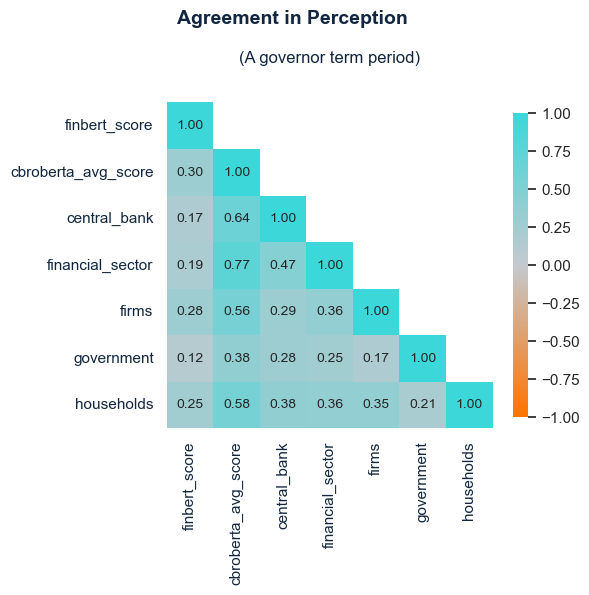

In [145]:
# Plot explanatory power btwn variables
sns.set_theme(style="white")
plt.figure(figsize=(6, 6))
sns.heatmap(agent_correlation, mask=mask, annot=True, cmap=custom_cmap, fmt = '.2f',
           vmin=-1, center=0, vmax=1, square=True, linewidths=0, annot_kws={"fontsize": 10}, cbar_kws={"shrink": .75})
plt.suptitle("Agreement in Perception", fontsize=14, weight='bold', color='#12273f')
plt.title("(A governor term period)", pad=5, color='#12273f', y=1.1)
plt.xticks(fontsize=11, color='#12273f')
plt.yticks(fontsize=11, color='#12273f')
plt.tight_layout()
# plt.savefig("perception_agreement.png", dpi=300, bbox_inches='tight')
plt.show()

In [146]:
# # Calculate rolling correlation (e.g. 30-day window)
# rolling_corr = (
#     sub_period['cbroberta_avg_score']
#     .rolling(window=30)
#     .corr(sub_period['finbert_score'])
# )

In [147]:
# # Plot the rolling agreement
# plt.figure(figsize=(12, 5))
# rolling_corr.plot()
# plt.axhline(0, color='black', linestyle='--', linewidth=1)
# plt.title('Rolling Correlation (30-Day) Between FinBERT and CentralBankRoBERTa', fontweight='bold')
# plt.xlabel('Date')
# plt.ylabel('Pearson Correlation')
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.show()

In [148]:
# Subset for the key period
sub_period = cb_fn_lm_topic[
(cb_fn_lm_topic['date'] >= '2003-07-01') &
(cb_fn_lm_topic['date'] <= '2013-06-30')
]
sub_period.head(1)

Unnamed: 0             custom_ref       date   author  is_gov  \
155         155  UK_2003-07-21_nickell 2003-07-21  nickell       0   

     central_bank  financial_sector     firms  government  households  ...  \
155     -0.541858         -0.474585 -0.205474   -0.609128   -0.522173  ...   

      topic_0   topic_1   topic_2   topic_3   topic_4   topic_5   topic_6  \
155  0.000089  0.000089  0.000089  0.000089  0.000089  0.000089  0.999374   

      topic_7  dominant_topic            dominant_topic_name  
155  0.000089               6  Labour Markets & Productivity  

[1 rows x 32 columns]

In [149]:
print(type(sub_period.index))
print(sub_period.index[:5])

<class 'pandas.core.indexes.base.Index'>
Index([155, 156, 157, 158, 159], dtype='int64')


In [150]:
sub_period['date'] = pd.to_datetime(sub_period['date'], errors='coerce')
sub_period = sub_period.set_index('date')
sub_period = sub_period[~sub_period.index.isna()]
sub_period = sub_period.sort_index()

C:\Users\victo\AppData\Local\Temp\ipykernel_43400\3166960571.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_period['date'] = pd.to_datetime(sub_period['date'], errors='coerce')


In [151]:
rolling_corr = (
    sub_period['cbroberta_avg_score']
    .rolling(window=30)
    .corr(sub_period['finbert_score'])
)

# Confirm correct dates
print(rolling_corr.index.min(), rolling_corr.index.max())
print(rolling_corr.index.dtype)

2003-07-21 00:00:00 2013-06-26 00:00:00
datetime64[ns]


## PLOT: perception agreement

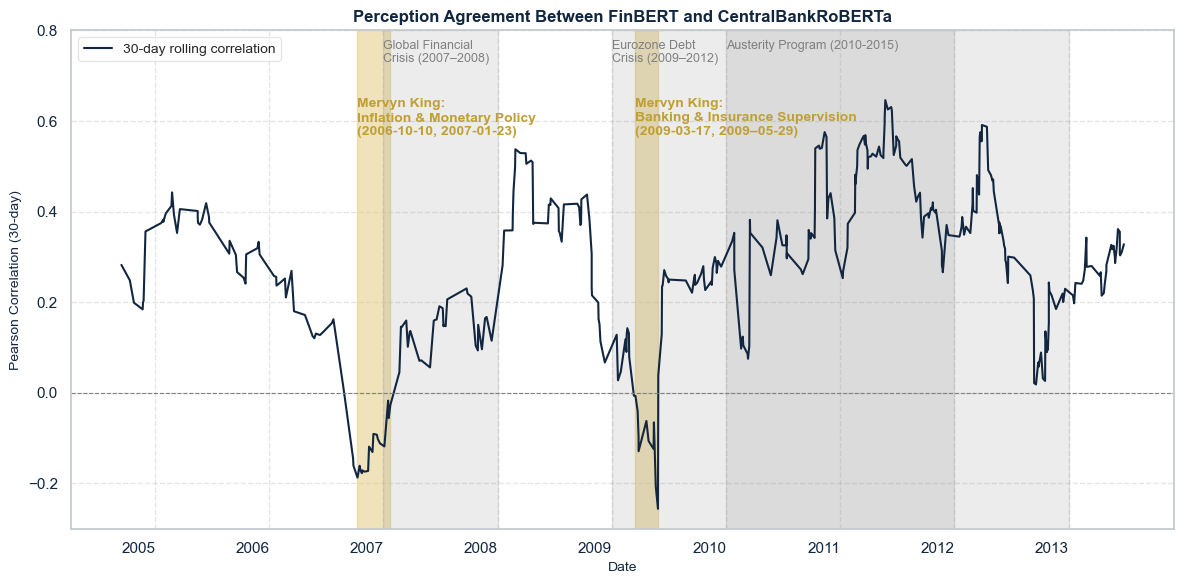

In [153]:
# Plot the rolling correlation
fig, ax = plt.subplots(figsize=(12, 6))
rolling_corr.plot(color='#12273f', label='30-day rolling correlation')
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)

# Define speeches periods to highlight
speeches_periods = {
    'Mervyn King:\nInflation & Monetary Policy\n(2006-10-10, 2007-01-23)': ('2006-10-10', '2007-01-23'),
    'Mervyn King:\nBanking & Insurance Supervision\n(2009-03-17, 2009–05-29)': ('2009-03-17', '2009-05-29')
}

# Highlight multiple periods
for label_s, (start_date, end_date) in speeches_periods.items():
    start_d = pd.to_datetime(start_date)
    end_d = pd.to_datetime(end_date)
    plt.axvspan(start_d, end_d, color='#dfc369', alpha=0.45)
    plt.text(x=start_d, y=0.65, s=label_s, fontsize=10, color='#C0A033', fontweight='bold', ha='left', va='top', wrap=False)

# Define periods to highlight
highlight_periods = {
    'Global Financial\nCrisis (2007–2008)': (2007, 2008),
    'Eurozone Debt\nCrisis (2009–2012)': (2009, 2012),
    'Austerity Program (2010-2015)': (2010, 2013)
}

# Highlight multiple periods
for label, (start_year, end_year) in highlight_periods.items():
    start = pd.to_datetime(f'{start_year}-01-01')
    end = pd.to_datetime(f'{end_year}-01-01')
    plt.axvspan(start, end, color='grey', alpha=0.15)
    plt.text(x=start, y=0.78, s=label, fontsize=9, color='grey', ha='left', va='top', wrap=False)

# Change all spines to custom color
for spine in ax.spines.values():
    spine.set_color('#c4c9ce')

# Final formatting
plt.ylim(top=0.8)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('Perception Agreement Between FinBERT and CentralBankRoBERTa', fontweight='bold', color='#12273f')
ax.set_xlabel("Date", fontsize=10, color='#12273f')
ax.set_ylabel("Pearson Correlation (30-day)", fontsize=10, color='#12273f')
ax.tick_params(axis='x', labelsize=11, colors='#12273f')
ax.tick_params(axis='y', labelsize=11, colors='#12273f')
plt.xticks(rotation=0)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10)
plt.savefig("perception_agreement_rolling.png", dpi=300, bbox_inches='tight')
plt.show()

In [154]:
# Subset for the key period
key_period = cb_fn_lm_topic[
(cb_fn_lm_topic['date'] >= '2003-07-01') &
(cb_fn_lm_topic['date'] <= '2013-06-30')
]

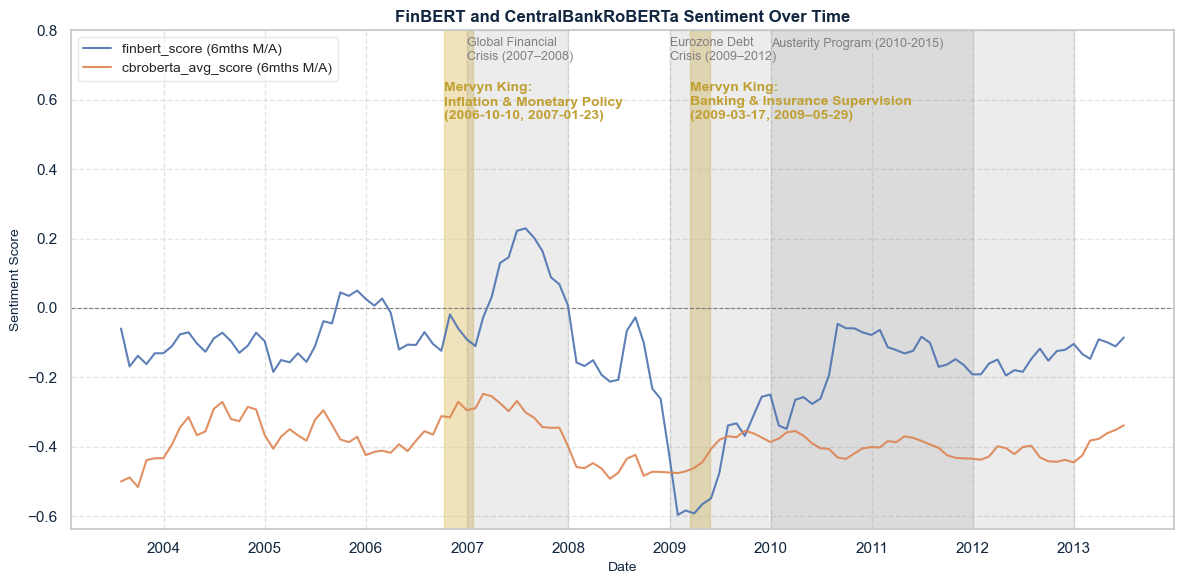

In [180]:
# Plot the sentiment
# Clean column names
key_period.columns = key_period.columns.str.strip()

# Set index and select numeric columns
df = key_period.set_index('date')
numeric_cols = df.select_dtypes(include='number')

# Resample monthly (month-end) and compute mean
monthly_data = numeric_cols.resample('ME').mean().reset_index()

# Compute 6-month moving average
cols_to_plot = [
    'finbert_score', 
    'cbroberta_avg_score'
]
monthly_data_ma = monthly_data.copy()
monthly_data_ma[cols_to_plot] = monthly_data_ma[cols_to_plot].rolling(window=6, min_periods=1).mean()

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
for col in cols_to_plot:
    plt.plot(monthly_data_ma['date'], monthly_data_ma[col], 
             label=f"{col} (6mths M/A)", linewidth=1.5, alpha=0.9)

plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)

# Define speeches periods to highlight
speeches_periods = {
    'Mervyn King:\nInflation & Monetary Policy\n(2006-10-10, 2007-01-23)': ('2006-10-10', '2007-01-23'),
    'Mervyn King:\nBanking & Insurance Supervision\n(2009-03-17, 2009–05-29)': ('2009-03-17', '2009-05-29')
}

# Highlight multiple periods
for label_s, (start_date, end_date) in speeches_periods.items():
    start_d = pd.to_datetime(start_date)
    end_d = pd.to_datetime(end_date)
    plt.axvspan(start_d, end_d, color='#dfc369', alpha=0.45)
    plt.text(x=start_d, y=0.65, s=label_s, fontsize=10, color='#C0A033', fontweight='bold', ha='left', va='top', wrap=False)

# Define periods to highlight
highlight_periods = {
    'Global Financial\nCrisis (2007–2008)': (2007, 2008),
    'Eurozone Debt\nCrisis (2009–2012)': (2009, 2012),
    'Austerity Program (2010-2015)': (2010, 2013)
}

# Highlight multiple periods
for label, (start_year, end_year) in highlight_periods.items():
    start = pd.to_datetime(f'{start_year}-01-01')
    end = pd.to_datetime(f'{end_year}-01-01')
    plt.axvspan(start, end, color='grey', alpha=0.15)
    plt.text(x=start, y=0.78, s=label, fontsize=9, color='grey', ha='left', va='top', wrap=False)

# Change all spines to custom color
for spine in ax.spines.values():
    spine.set_color('#c4c9ce')

# Final formatting
plt.ylim(top=0.8)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.title('FinBERT and CentralBankRoBERTa Sentiment Over Time', fontweight='bold', color='#12273f')
ax.set_xlabel("Date", fontsize=10, color='#12273f')
ax.set_ylabel("Sentiment Score", fontsize=10, color='#12273f')
ax.tick_params(axis='x', labelsize=11, colors='#12273f')
ax.tick_params(axis='y', labelsize=11, colors='#12273f')
plt.xticks(rotation=0)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=10)
# plt.savefig("models_sentiment_over_time.png", dpi=300, bbox_inches='tight')
plt.show()

In [156]:
# cb_fn_lm_topic.info()

In [157]:
# Search speeches within the disagreement range
speech_period = cb_fn_lm_topic[
(cb_fn_lm_topic['date'] >= '2006-10-10') &
(cb_fn_lm_topic['date'] <= '2007-01-23')
]
speech_period = speech_period[['date','author', 'is_gov', 'dominant_topic_name', 'text']]
speech_period

date       author  is_gov               dominant_topic_name  \
239 2006-10-10  Mervyn King       1       Inflation & Monetary Policy   
240 2006-10-17        gieve       0          Credit & Housing Markets   
241 2006-10-20        clark       0          Credit & Housing Markets   
242 2006-10-24         bean       0       Inflation & Monetary Policy   
243 2006-10-26         bond       0  Financial Stability & Governance   
244 2006-10-29  Mervyn King       1   Banking & Insurance Supervision   
245 2006-11-01        lomax       0  Financial Stability & Governance   
246 2006-11-13        gieve       0   Banking & Insurance Supervision   
247 2006-11-16  Mervyn King       1     Labour Markets & Productivity   
248 2006-11-27        lomax       0       Inflation & Monetary Policy   
249 2006-11-30    jenkinson       0          Credit & Housing Markets   
250 2006-12-11      no_info       0          Credit & Housing Markets   
251 2006-12-14        gieve       0          Credit & Housing Markets   
252 2006-12-21  Mervyn King       1          Credit & Housing Markets   
253 2007-01-04      no_info       0     Labour Markets & Productivity   
254 2007-01-16     sentance       0       Inflation & Monetary Policy   
255 2007-01-18       besley       0     Labour Markets & Productivity   
256 2007-01-23  Mervyn King       1       Inflation & Monetary Policy   

                                                  text  
239  Thirty years ago, inflation reached 27% - the ...  
240  Hedge funds get a bad press. They often appear...  
241  It is now nearly twenty years since the first ...  
242  Madonna", given the 90 million hits that her n...  
243  The motivation for today's workshop really put...  
244  My Business here is Study in which I have been...  
245  Next month will be the thirty-fifth anniversar...  
246  My subject this evening is the challenge that ...  
247  The Black Country is where it all began. It be...  
248  The decade to 2004 was one of the most remarka...  
249  Historically, the commercial property sector h...  
250  It is a great privilege to give this lecture, ...  
251  Many of you will have seen the new that we pub...  
252  What does globalisation mean? Humpty Dumpty sa...  
253  Move permanently Move temporarily Try it out N...  
254  Committee and the issues it faces. Well, that ...  
255  Ladies and Gentlemen, it is a great pleasure t...  
256  Two weeks ago your Chamber of Commerce called ...

# Findings & Insights

- As 2025 proceeds more speeches are to take place, thus focus on period before 2025
- Correlation analysis identified need of focusing on different timeframes
- Cross-correlation analysis suggested time lags are indicator-specific - each economic indicator and agent experience different predictive power over time, at times one leads another and they swap.
- As per common practice markets respond to economic news/speeches from immediately or 5 days from the date of news/speeches.
- Very often speeches are not given on a consecutive day and sometimes on weekends, whereas gilt-yields data is daily but does not include weekends.
- A 2-day tolerance is introduced throughout merger of the two datasets to match a value of a gilt yield to weekend speeches.
- This will allow to check the common practice of market response taking place within 0-5 days within a speech.
- !!! Avoid duplicated dates by averaging estimated values for higher relationships precision.
- The findings inform predictive analysis - need to identify optimal time lags to evaluate the predictive power of sentiment.
- Check economic research findings to inform predictive analysis on what combination of indicators should be included in predictive models.

# Project Findings & Recommendations

- See the higher level findings & recommendations in the final project report.